In [1]:
import numpy as np
import os
#import ipdb

def connect_dataset(file_list, icond_file_list, outputdir,
                    topodx=10, roi=2500, offset=5000,gclass_num=5,test_data_num=500):
    """
    複数のデータセットを連結する
    """
    #ipdb.set_trace()
    
    #Reading and combining files Decide start and end points of the learning area and convert them to grid numbers
    H = np.loadtxt(file_list[0], delimiter = ',')
    icond = np.loadtxt(icond_file_list[0], delimiter = ',')
    
    #Reading and combining files
    if len(file_list) > 1:
        for i in range(1, len(file_list)):
            H_temp = np.loadtxt(file_list[i], delimiter = ',')
            icond_temp = np.loadtxt(icond_file_list[i], delimiter = ',')
            H = np.concatenate((H,H_temp),axis=0)
            icond = np.concatenate((icond,icond_temp),axis = 0)
    
    roi_grids = int(roi / topodx)
    num_grids = int(H.shape[1] / gclass_num)
    H_subset = np.zeros([H.shape[0], roi_grids * gclass_num])
    for i in range(gclass_num):
        H_subset[:, i*roi_grids:(i+1)*roi_grids] = H[:, i*num_grids:(i*num_grids+roi_grids)]
    
    #Obtain the maximum and minimum values of data
    max_x = np.max(H_subset)
    min_x = np.min(H_subset)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    #Split the data into tests and training
    H_train = H_subset[0:-test_data_num,:]
    H_test = H_subset[H_subset.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    #Save the data
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.savetxt(outputdir + '/x_train.txt',H_train,delimiter = ',')
    np.savetxt(outputdir + '/x_test.txt',H_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_train.txt',icond_train,delimiter = ',')
    np.savetxt(outputdir + '/icond_test.txt',icond_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_min.txt',icond_min,delimiter = ',')
    np.savetxt(outputdir + '/icond_max.txt',icond_max,delimiter = ',')
    np.savetxt(outputdir + '/x_minmax.txt',[min_x, max_x],delimiter = ',')
    
    
if __name__=="__main__":
    original_data_dir = "/home/rimali2009/Journal_2"
    parent_dir = "/home/rimali2009/Journal_2"
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    outputdir = parent_dir + "/data_g5_j2_roi770_jogan_5500_400grid"
    file_list = ['/home/rimali2009/Journal_2/eta_5500_g6_300grid_jogan_gs5_rw820_400grid.csv']
    initial_conditions = ['/home/rimali2009/Journal_2/start_param_random_5500_jogan_gs5_rw820_400grid.csv']
    connect_dataset(file_list, initial_conditions, outputdir, test_data_num=500, gclass_num=5, topodx=10., roi=770)
    

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:43:18 2017

@author: hanar
"""
import time
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.models import load_model
#from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

#Global variables for normalizing parameters
max_x = 1.0
min_x = 0.0
max_y = 1.0
min_y = 0.0


def deep_learning_tsunami(resdir, X_train_raw, y_train_raw, X_test_raw, y_test_raw,
                            _lr=0.02, _decay=0,
                            _validation_split=0.2, _batch_size=32,
                            _momentum=0.9, _nesterov=True,
                            num_layers=4, dropout=0.5,
                            node_num = 2500,
                            _epochs=2000):
    """
    Creating the inversion model of turbidity currents by deep learning
    """
    #Normalizing dataset
    X_train = get_normalized_data(X_train_raw, min_x, max_x)
    X_test = get_normalized_data(X_test_raw, min_x, max_x)
    y_train = get_normalized_data(y_train_raw, min_y, max_y)
    y_test = get_normalized_data(y_test_raw, min_y, max_y)
    
    #Generation of neural network model
    model = Sequential()
    model.add(Dense(node_num, input_dim=X_train.shape[1], activation='relu', kernel_initializer ='glorot_uniform'))#1st layer
    model.add(Dropout(dropout))
    for i in range(num_layers - 2):
        model.add(Dense(node_num, activation='relu', kernel_initializer ='glorot_uniform'))#2nd layer
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1], activation = 'relu', kernel_initializer ='glorot_uniform')) #last layer
    
    #Compiling the model
    model.compile(loss="mean_squared_error", 
              optimizer=SGD(lr=_lr, decay=_decay, momentum=_momentum, nesterov=_nesterov),
              #optimizer=Adadelta(),
              metrics=["mean_squared_error"])    
    
    #Perform learning
    t = time.time()
    check = ModelCheckpoint("model3.hdf5")
    #es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    #tb_cb = TensorBoard(log_dir=resdir, histogram_freq=2, write_graph=True, write_images=True)
    history = model.fit(X_train, y_train, epochs=_epochs, 
                    validation_split=_validation_split, batch_size=_batch_size,
                    callbacks=[check])
    
    #Evaluate learning result
    loss_and_metrics = model.evaluate(X_test,y_test)
    print("\nloss:{} mse:{}".format(loss_and_metrics[0],loss_and_metrics[1]))
    
    print("Elapsed time: {:.1f} sec.".format(time.time()-t))
    
    #Visualize learning result   
    #plot(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    # model The state of change when letting you learnplot
    plot_history(history)
    
    return model, history

def apply_model(model, X, min_x, max_x, min_y, max_y):
    """
    Apply model
    Maximum and minimum values ​​of X and Y are required to normalize
    """
    X_norm =  (X - min_x) / (max_x - min_x)
    Y_norm = model.predict(X_norm)
    Y = Y_norm*(max_y - min_y)+min_y
    return Y

def plot_history(history):
    # Plot accuracy history
    plt.plot(history.history['mean_squared_error'],"o-",label="mse")
    plt.plot(history.history['val_mean_squared_error'],"o-",label="val mse")
    plt.title('model mse')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(loc="upper right")
    plt.show()

#    # 損失の履歴をプロット
#    plt.plot(history.history['loss'],"o-",label="loss",)
#    plt.plot(history.history['val_loss'],"o-",label="val_loss")
#    plt.title('model loss')
#    plt.xlabel('epoch')
#    plt.ylabel('loss')
#    plt.legend(loc='upper right')
#    plt.show()

def test_model(model, x_test):
    #Test the results
    
    x_test_norm = get_normalized_data(x_test, min_x, max_x)
    test_result_norm = model.predict(x_test_norm)
    test_result = get_raw_data(test_result_norm, min_y, max_y)
    
    return test_result


def save_result(savedir, model, history, test_result):
    
    
    np.savetxt(savedir + 'test_result.txt',test_result,delimiter=',')
    np.savetxt(savedir+'loss.txt',history.history.get('loss'),delimiter=',')
    np.savetxt(savedir+'val_loss.txt',history.history.get('val_loss'),delimiter=',')
    
    #Serialize model and save
    print('save the model')
    model.save(savedir + 'model3.hdf5')

def load_data(datadir):
    """
    This function load training and test data sets, and returns variables
    """
    global min_x, max_x, min_y, max_y
    
    x_train = np.loadtxt(datadir + 'x_train.txt',delimiter=',')
    x_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
    y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
    y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
    min_y = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
    max_y = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')
    [min_x, max_x] = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
    
    return x_train, y_train, x_test, y_test

def set_minmax_data(_min_x, _max_x, _min_y, _max_y):
    global min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = _min_x, _max_x, _min_y, _max_y
    return
    


def get_normalized_data(x, min_val, max_val):
    """
    Normalizing the training and test dataset
    """
    x_norm = (x - min_val) / (max_val - min_val)
    
    return x_norm

def get_raw_data(x_norm, min_val, max_val):
    """
    
    Get raw data from the normalized dataset
    """
    x = x_norm * (max_val - min_val) + min_val
    
    return x

if __name__ == "__main__":
    
    #Reading data  
    datadir = '/home/rimali2009/Journal_2/data_g5_j2_roi770_jogan_5500_400grid/'
    resdir = '/home/rimali2009/Journal_2/result_g5_j2_roi770_jogan_5500_400grid/'
    if not os.path.exists(resdir):
        os.mkdir(resdir)
    
    x_train, y_train, x_test, y_test = load_data(datadir)
    
     
    #Execution of learning
    testcases = [4500,5000]
    for i in range(len(testcases)):
        resdir_case = resdir + '{}/'.format(testcases[i])        
        if not os.path.exists(resdir_case):
            os.mkdir(resdir_case)
        x_train_sub = x_train[0:testcases[i],:]
        y_train_sub = y_train[0:testcases[i],:]
        model, history = deep_learning_tsunami(resdir_case, x_train_sub, y_train_sub, x_test, y_test, num_layers=5)
        #Verify and save results
        result = test_model(model, x_test)
        save_result(resdir_case,model,history,result)

Using TensorFlow backend.


Train on 3600 samples, validate on 900 samples
Epoch 1/2000
3600/3600 [==============================] - 10s 3ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0601 - val_mean_squared_error: 0.0601
Epoch 2/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 3/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 4/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 5/2000
3600/3600 [==============================] - 1s 240us/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 6/2000
3600/3600 [==============================] - 1s 242us/step - loss: 0.0353 - mean_squared_error: 0.035

3600/3600 [==============================] - 1s 236us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 98/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 99/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 100/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 101/2000
3600/3600 [==============================] - 1s 234us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 102/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0106 - val_mean_squared_error: 0.01

3600/3600 [==============================] - 1s 237us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 194/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 195/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 196/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 197/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 198/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0085 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 237us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 290/2000
3600/3600 [==============================] - 1s 240us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 291/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 292/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 293/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 294/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0082 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 237us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 386/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 387/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 388/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 389/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 390/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0075 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 237us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 482/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 483/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 484/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 485/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 486/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0061 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 238us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 578/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 579/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 580/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 581/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 582/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0062 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 237us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 674/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 675/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 676/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 677/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 678/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0049 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 238us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 770/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 771/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 772/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 773/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 774/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0048 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 237us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 866/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 867/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 868/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 869/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 870/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0054 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 236us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 962/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 963/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 964/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 965/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 966/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0050 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 238us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1058/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 1059/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1060/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 1061/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 1062/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0054 - val_mean_squared_erro

3600/3600 [==============================] - 1s 236us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1106/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1107/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1108/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1109/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1110/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0051 - val_mean_squared_erro

3600/3600 [==============================] - 1s 238us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1154/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1155/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 1156/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 1157/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1158/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0060 - val_mean_squared_erro

3600/3600 [==============================] - 1s 236us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 1202/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1203/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 1204/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1205/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1206/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0052 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 1250/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1251/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1252/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1253/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 1254/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0048 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1298/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1299/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1300/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1301/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1302/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0057 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1346/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1347/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1348/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1349/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1350/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0045 - val_mean_squared_erro

3600/3600 [==============================] - 1s 238us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1394/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1395/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1396/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1397/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 1398/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0054 - val_mean_squared_erro

3600/3600 [==============================] - 1s 239us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1442/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1443/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1444/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1445/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1446/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0055 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1490/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1491/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1492/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1493/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1494/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0048 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1538/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1539/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1540/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1541/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1542/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0046 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1586/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1587/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1588/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1589/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1590/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0045 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1634/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1635/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1636/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1637/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1638/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0047 - val_mean_squared_erro

3600/3600 [==============================] - 1s 236us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1682/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1683/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1684/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1685/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1686/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0041 - val_mean_squared_erro

3600/3600 [==============================] - 1s 236us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1730/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1731/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1732/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1733/2000
3600/3600 [==============================] - 1s 236us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1734/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0041 - val_mean_squared_erro

3600/3600 [==============================] - 1s 236us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1778/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 1779/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1780/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1781/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1782/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0043 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1826/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1827/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1828/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1829/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 1830/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0042 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1874/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1875/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 1876/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1877/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1878/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0048 - val_mean_squared_erro

3600/3600 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1922/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1923/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1924/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1925/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1926/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0040 - val_mean_squared_erro

3600/3600 [==============================] - 1s 237us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1970/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1971/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1972/2000
3600/3600 [==============================] - 1s 235us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1973/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1974/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0049 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model
Train on 4000 samples, validate on 1000 samples
Epoch 1/2000
4000/4000 [==============================] - 1s 327us/step - loss: 0.0865 - mean_squared_error: 0.0865 - val_loss: 0.0574 - val_mean_squared_error: 0.0574
Epoch 2/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0545 - mean_squared_error: 0.0545 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 3/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 4/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 5/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 6/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0340 - mean_squ

4000/4000 [==============================] - 1s 237us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 98/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 99/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 100/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 101/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 102/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0103 - val_mean_squared_error: 0.01

4000/4000 [==============================] - 1s 238us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 194/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 195/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 196/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 197/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 198/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0087 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 236us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 290/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 291/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 292/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 293/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 294/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0067 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 236us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 386/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 387/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 388/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 389/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 390/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0058 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 237us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 482/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 483/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 484/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 485/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 486/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0065 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 237us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 578/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 579/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 580/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 581/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 582/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0065 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 236us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 674/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 675/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 676/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 677/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 678/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0055 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 237us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 770/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 771/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 772/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 773/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 774/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0052 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 235us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 866/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 867/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 868/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 869/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 870/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0050 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 236us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 962/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 963/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 964/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 965/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 966/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0047 - val_mean_squared_error: 0.

Epoch 1057/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1058/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1059/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1060/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 1061/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 1062/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_m

Epoch 1105/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1106/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1107/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1108/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1109/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1110/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0055 - val_m

Epoch 1153/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1154/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1155/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1156/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1157/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1158/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0048 - val_m

Epoch 1201/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1202/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 1203/2000
4000/4000 [==============================] - 1s 234us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1204/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1205/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 1206/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0049 - val_m

Epoch 1249/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1250/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1251/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1252/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1253/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1254/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0043 - val_m

Epoch 1297/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1298/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1299/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1300/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1301/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1302/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_m

Epoch 1345/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1346/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1347/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1348/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1349/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1350/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0046 - val_m

Epoch 1393/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1394/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1395/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1396/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1397/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1398/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_m

Epoch 1441/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1442/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1443/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1444/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1445/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1446/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0041 - val_m

Epoch 1489/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1490/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1491/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1492/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1493/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1494/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0042 - val_m

Epoch 1537/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1538/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1539/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1540/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1541/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1542/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0046 - val_m

Epoch 1585/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1586/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1587/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1588/2000
4000/4000 [==============================] - 1s 234us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1589/2000
4000/4000 [==============================] - 1s 239us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1590/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0042 - val_m

Epoch 1633/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1634/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1635/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1636/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1637/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1638/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0041 - val_m

Epoch 1681/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1682/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1683/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1684/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1685/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1686/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0042 - val_m

Epoch 1729/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1730/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1731/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1732/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1733/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1734/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0038 - val_m

Epoch 1777/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1778/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1779/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1780/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1781/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1782/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0044 - val_m

Epoch 1825/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1826/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1827/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1828/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1829/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1830/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0041 - val_m

Epoch 1873/2000
4000/4000 [==============================] - 1s 238us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1874/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1875/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1876/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1877/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1878/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0044 - val_m

Epoch 1921/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1922/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1923/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1924/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1925/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1926/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0041 - val_m

Epoch 1969/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1970/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1971/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1972/2000
4000/4000 [==============================] - 1s 235us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1973/2000
4000/4000 [==============================] - 1s 236us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1974/2000
4000/4000 [==============================] - 1s 237us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0042 - val_m

<Figure size 640x480 with 1 Axes>

save the model


(500, 8)
Standard Deviation: 153.12440866298058
Standard Deviation sample: 153.2777631417387
Mean: 56.5115432971645
CV: 2.712326618576518


/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


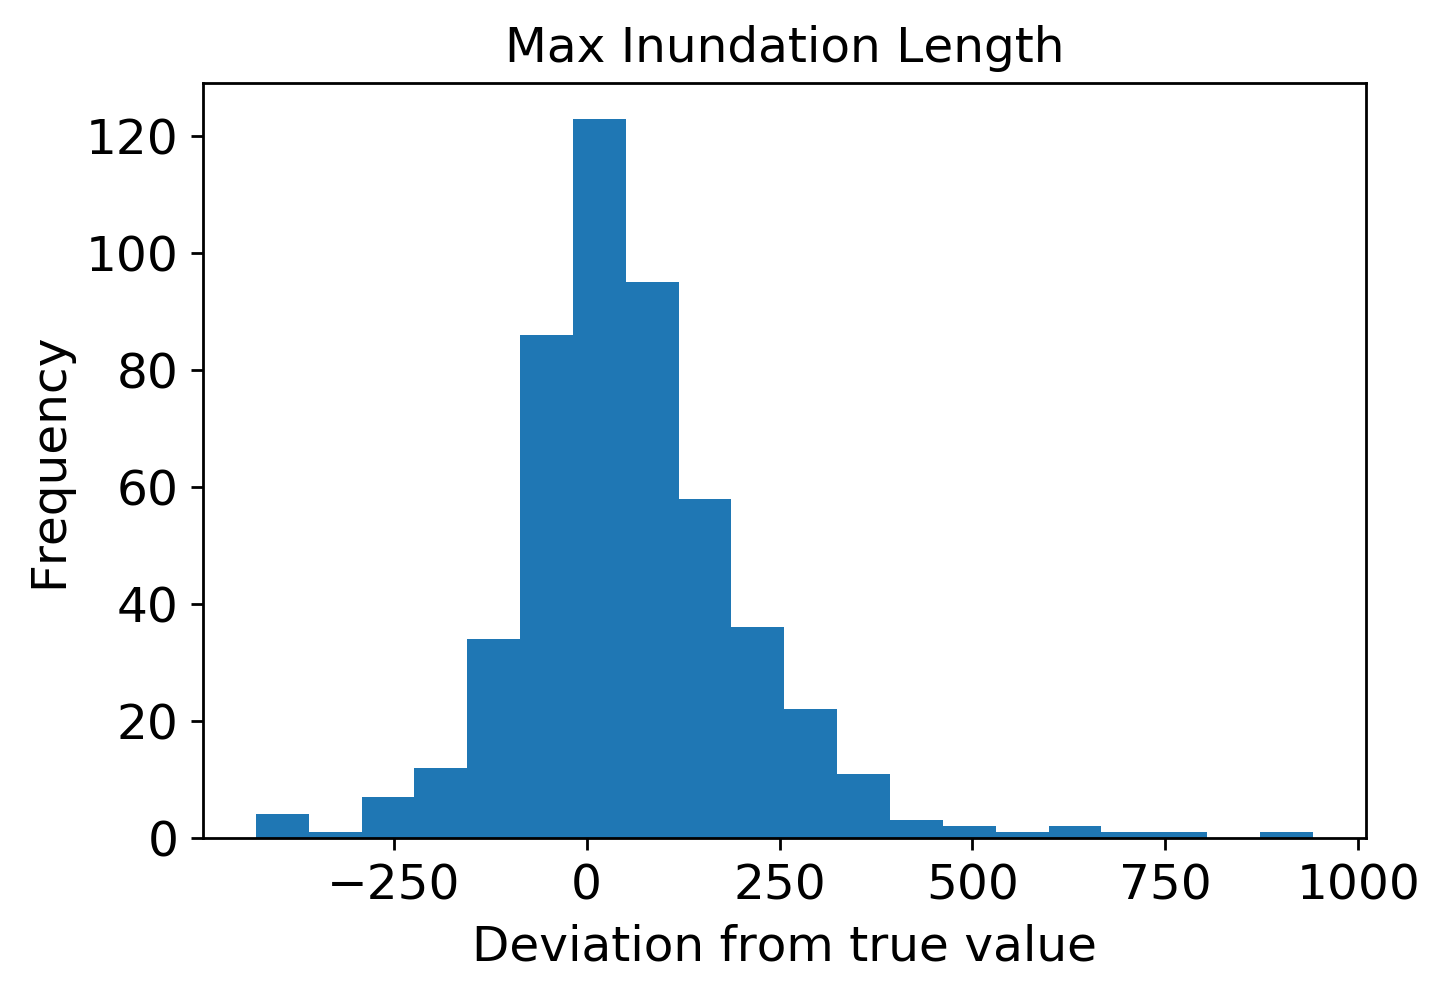

Standard Deviation: 0.3719331782035591
Standard Deviation sample: 0.37230567021299305
Mean: 0.05597416231338056
CV: 6.651384403549954


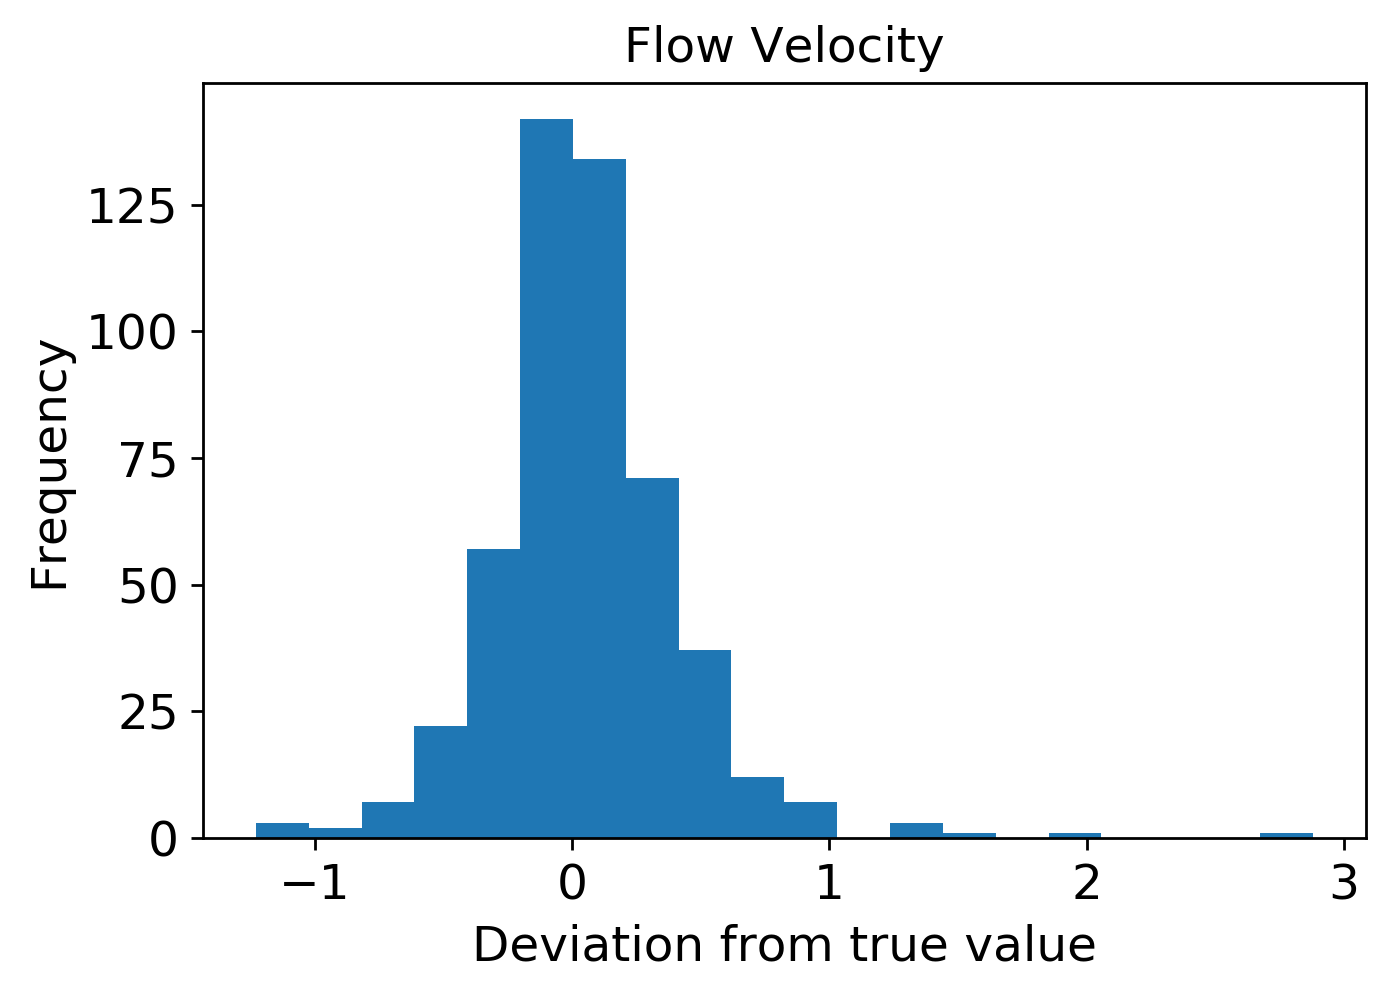

Standard Deviation: 0.6137027771313466
Standard Deviation sample: 0.6143174019995903
Mean: -0.5559434480638125
CV: -1.1049998055361154


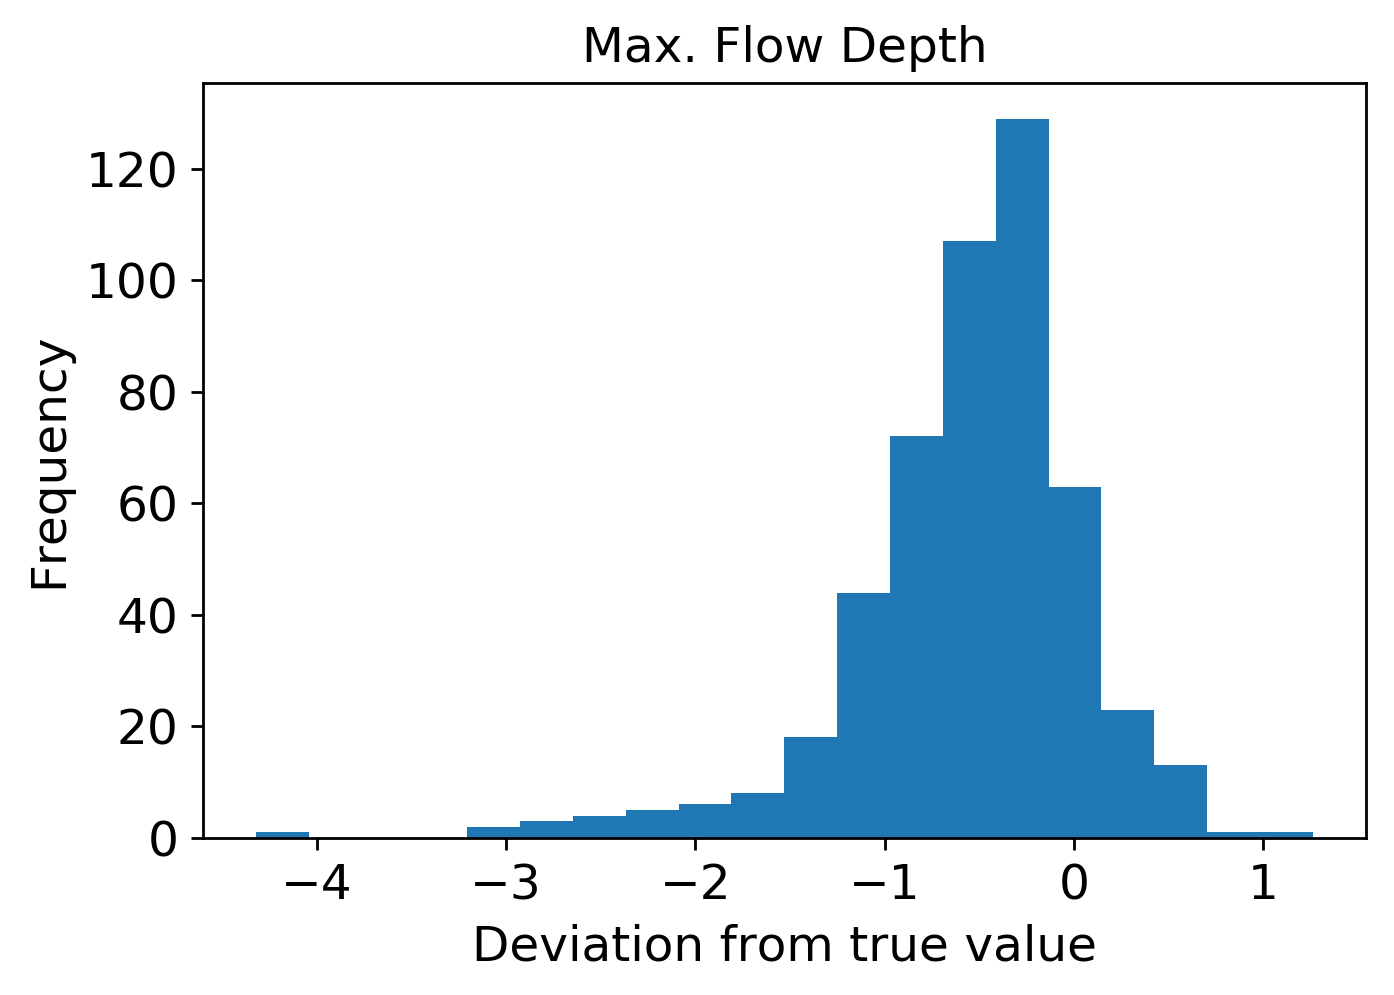

Standard Deviation: 0.0009715744305481989
Standard Deviation sample: 0.0009725474647735873
Mean: 0.00032311255166390696
CV: 3.0099340300008066


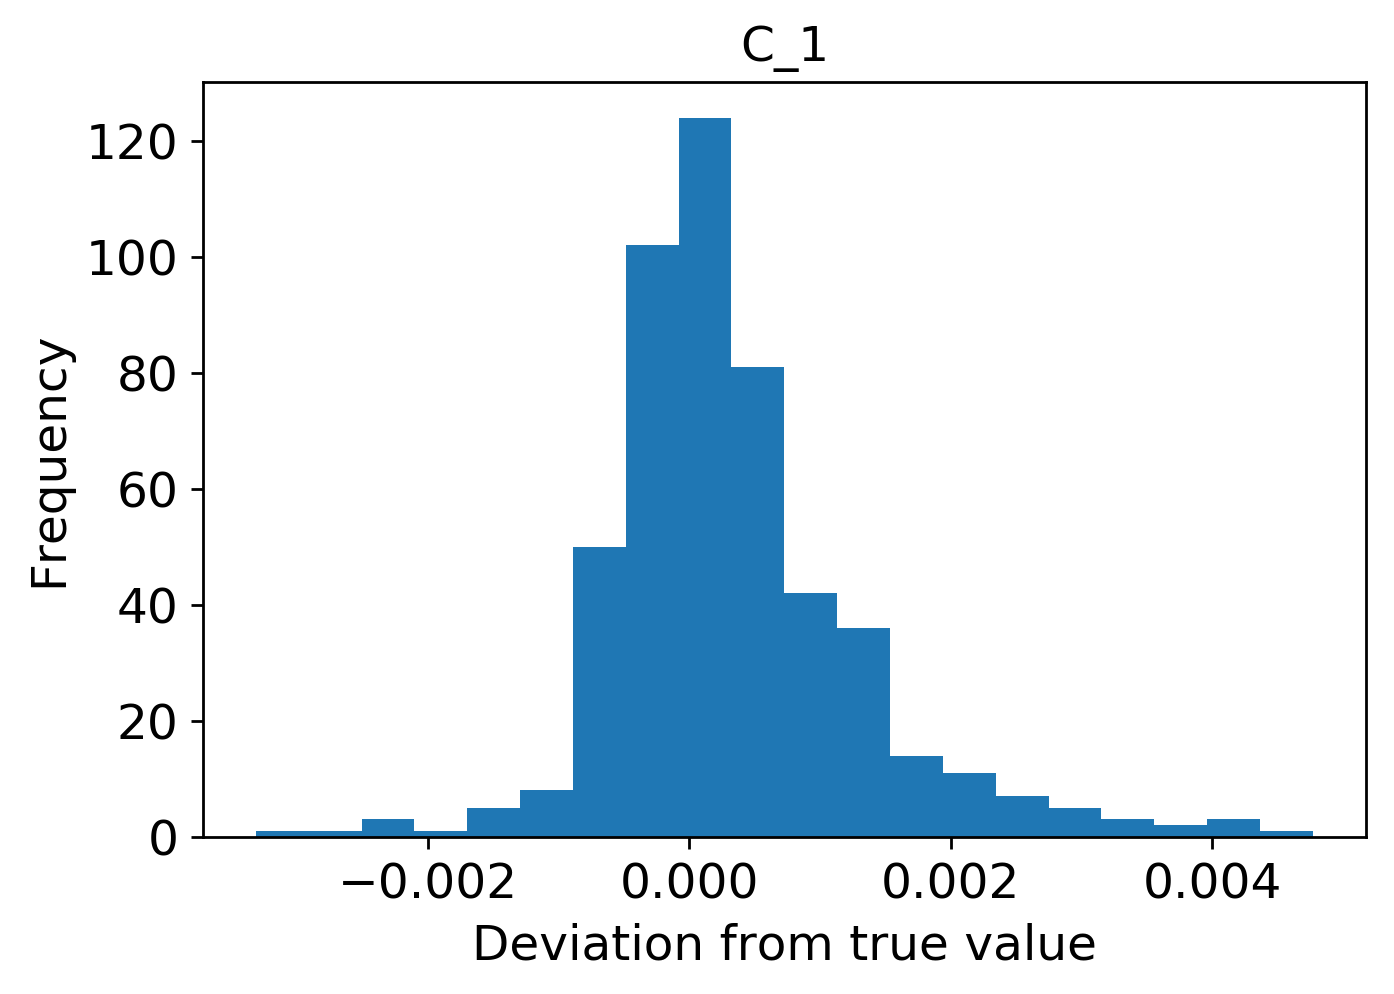

Standard Deviation: 0.0009860737188835754
Standard Deviation sample: 0.0009870612741825434
Mean: 0.0003741272346797907
CV: 2.638303717790962


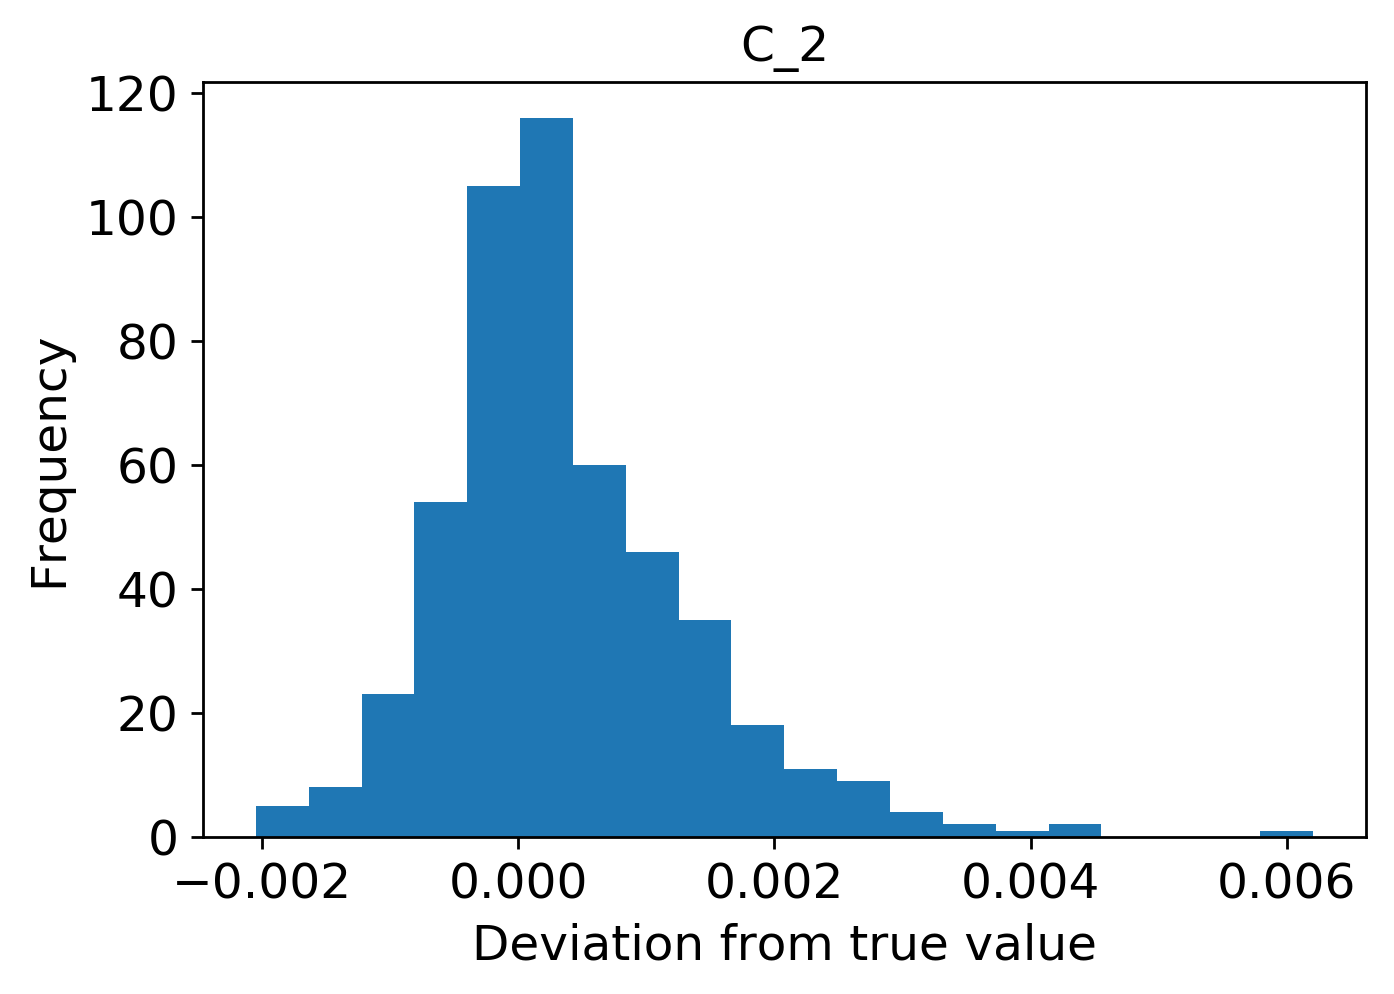

Standard Deviation: 0.0009591529567089498
Standard Deviation sample: 0.00096011355079718
Mean: 0.00020779036312269198
CV: 4.620587482347634


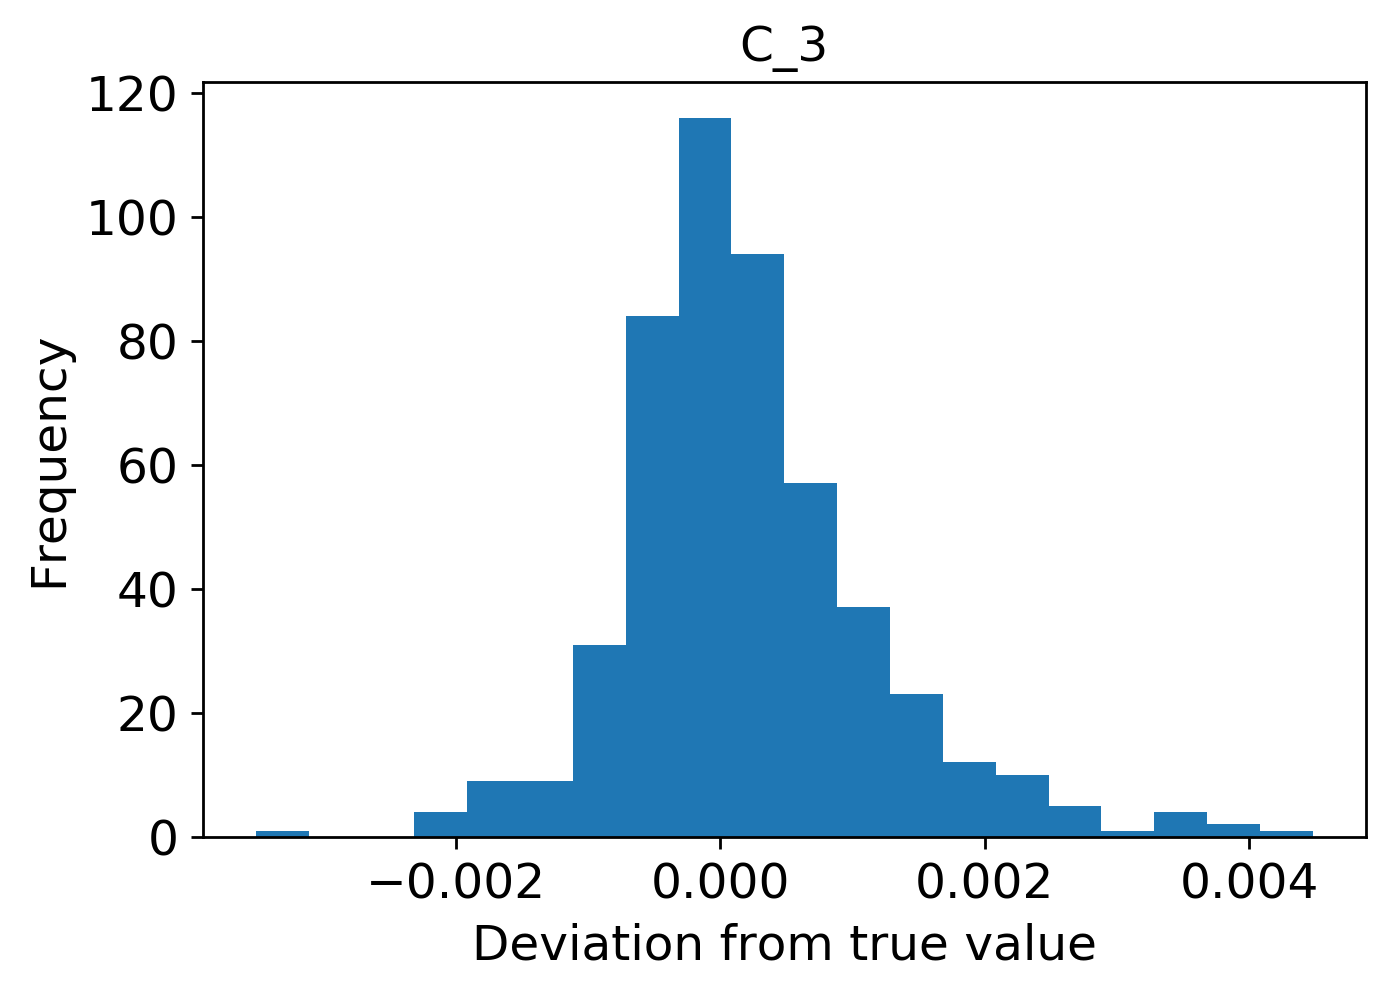

Standard Deviation: 0.0010111611118449498
Standard Deviation sample: 0.001012173792230797
Mean: 0.00016932044493894665
CV: 5.977859275031821


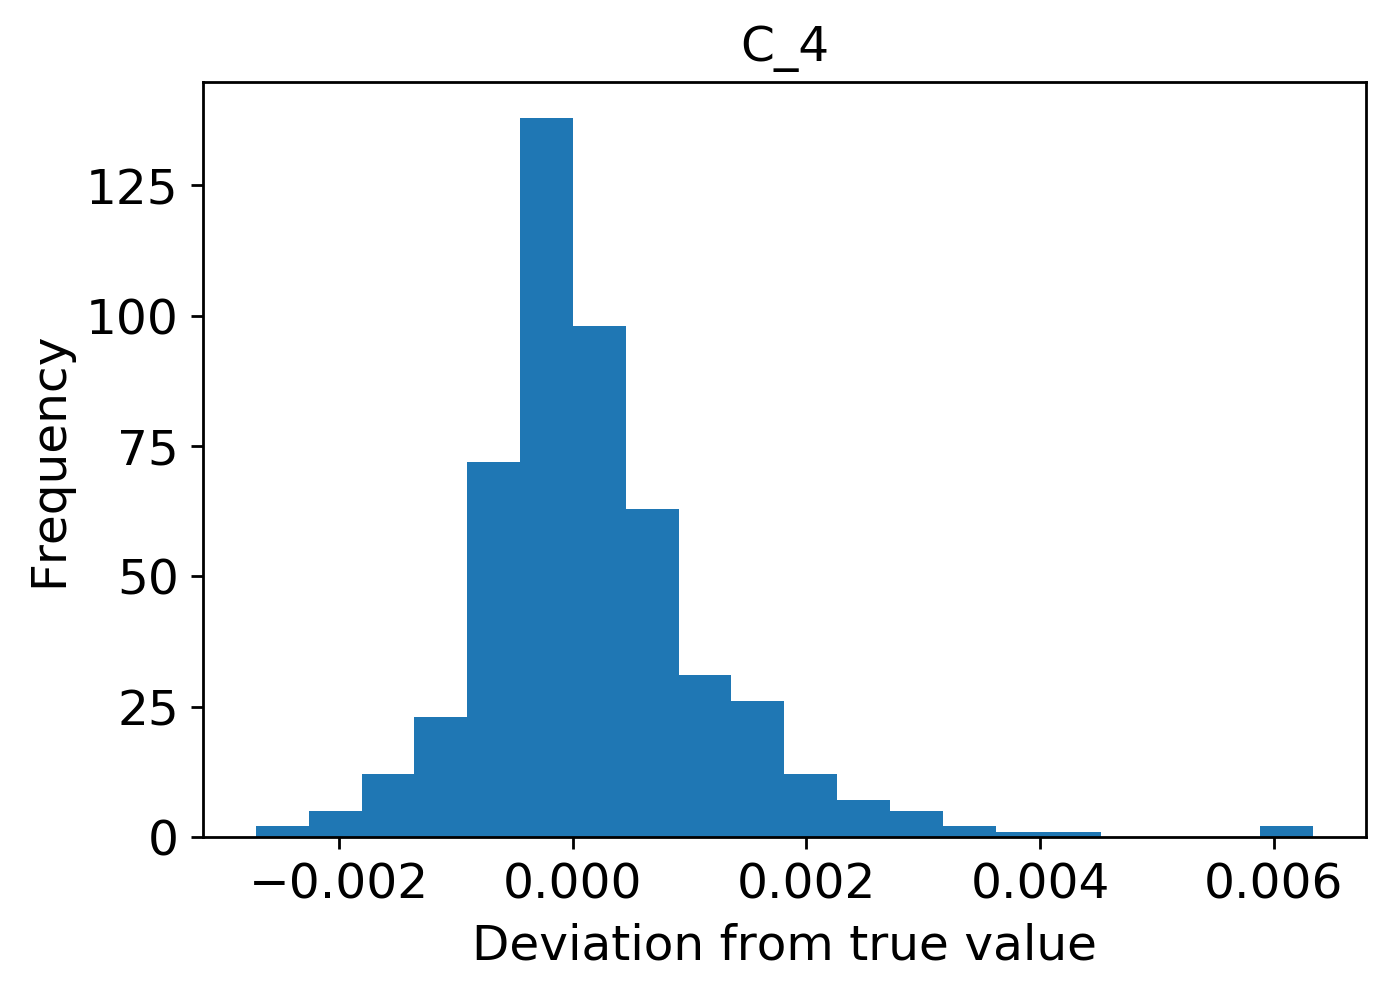

Standard Deviation: 0.0009779705621361524
Standard Deviation sample: 0.0009789500021033445
Mean: 0.00026946930821013313
CV: 3.6328812680216473


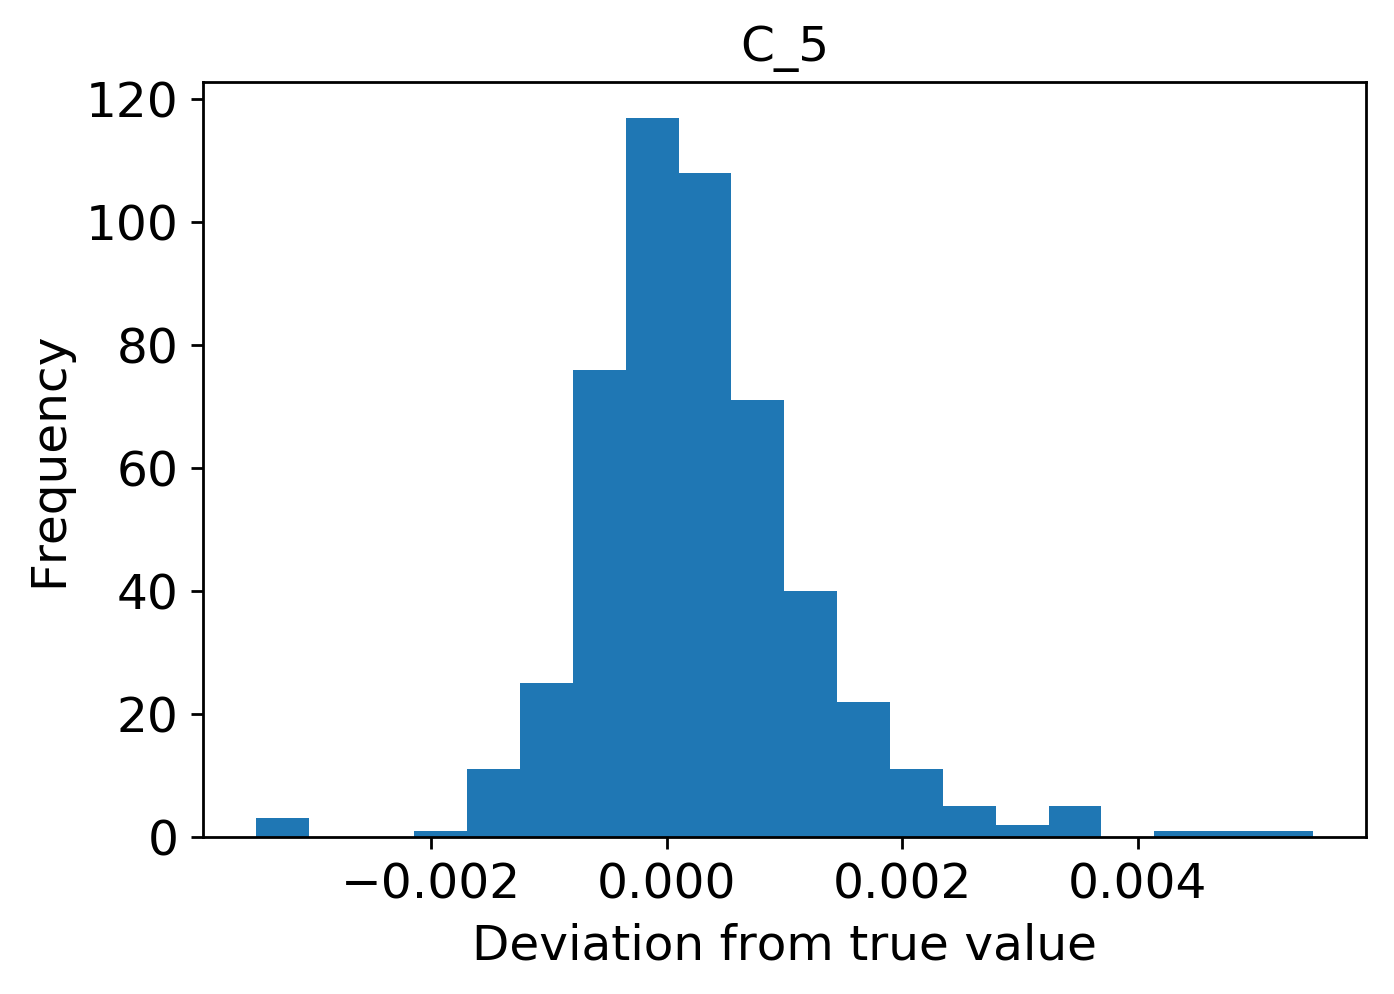

In [3]:
from scipy.stats import variation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

hfont = {'fontname':'Century Gothic'}
textcol = 'k'

datadir = '/home/rimali2009/Journal_2/data_g5_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g5_j2_roi770_jogan_5500_400grid/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
resi = test_result - icond
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5']

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation:', np.std(resi[:,i]))
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('CV:', np.std(resi[:,i],ddof=1)/np.mean(resi[:,i]))                           
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

(500, 8)


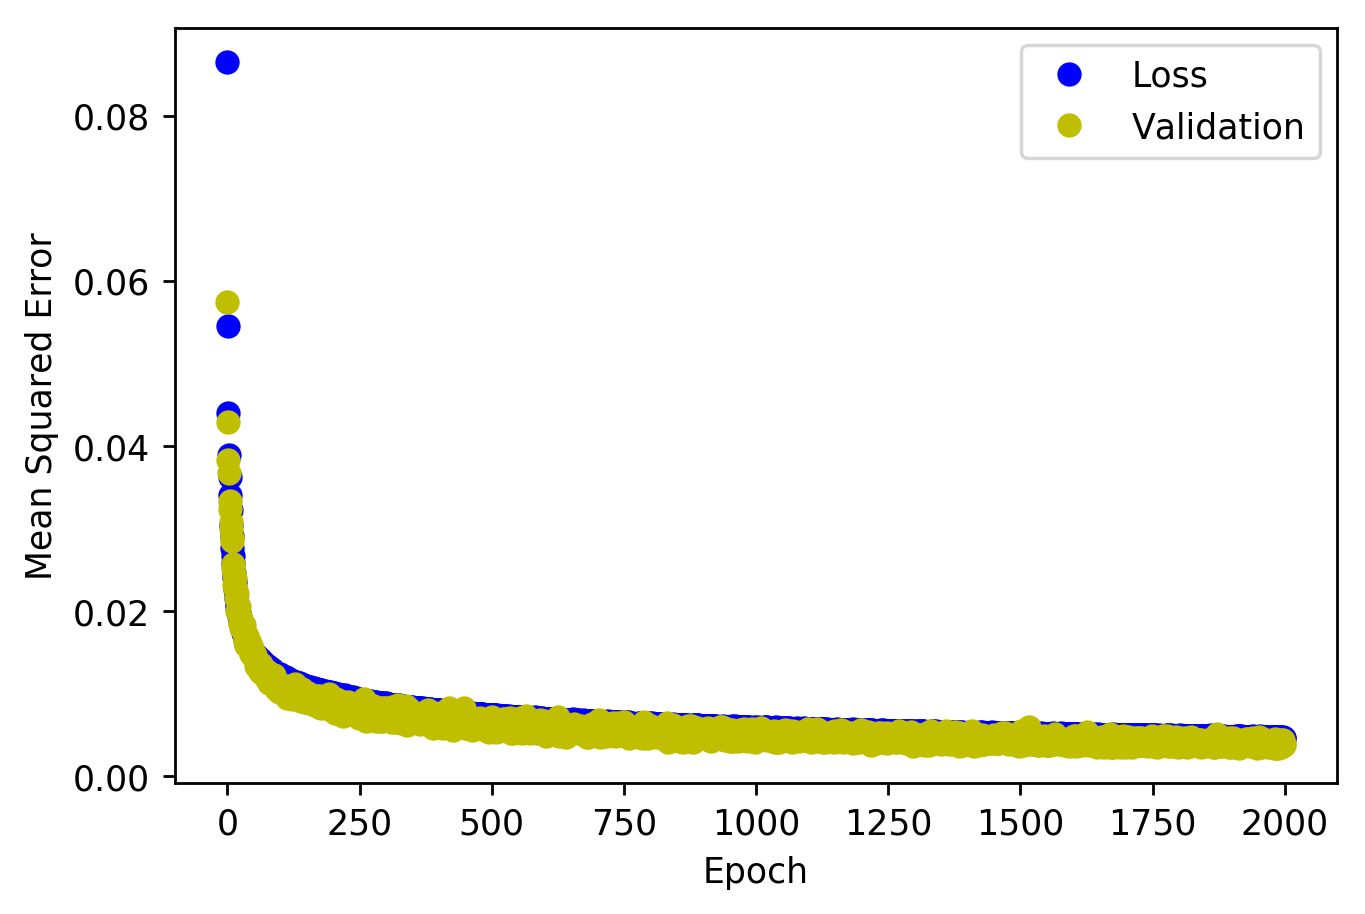

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

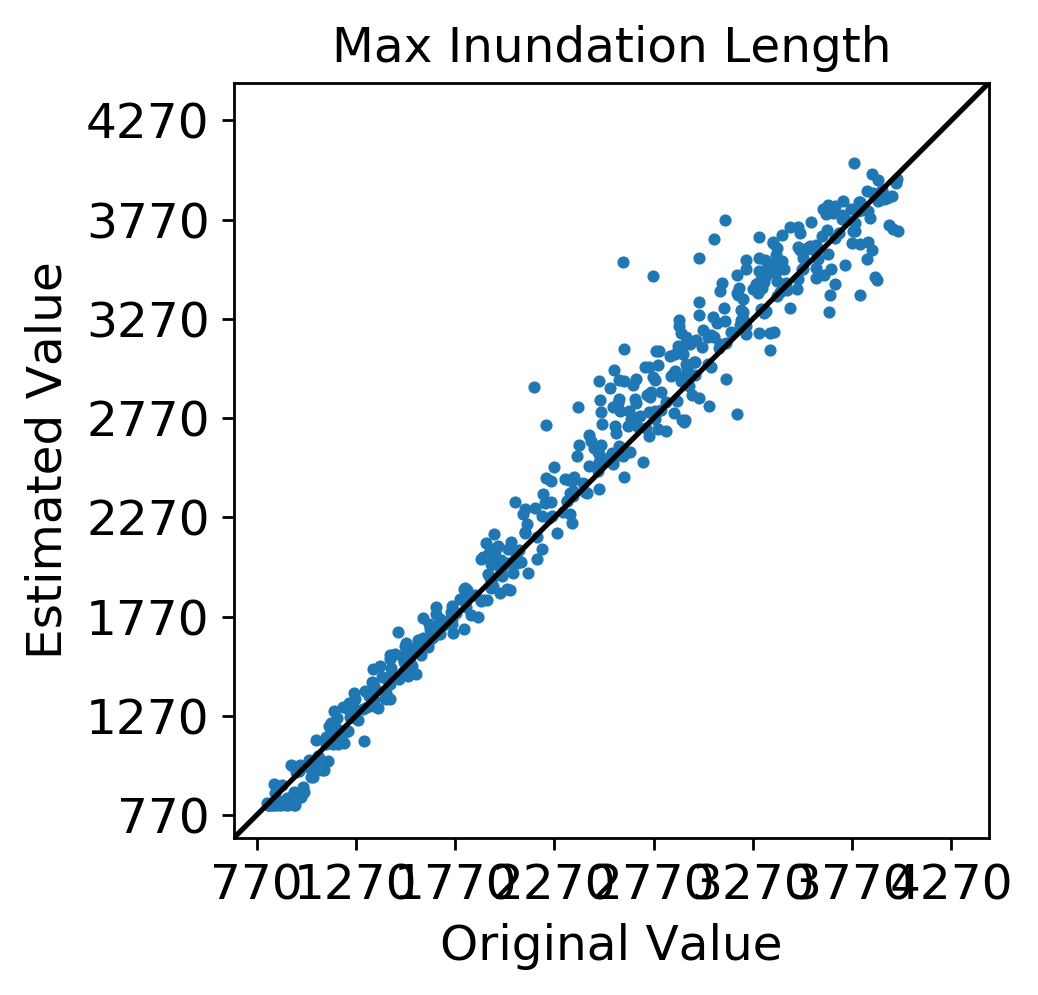

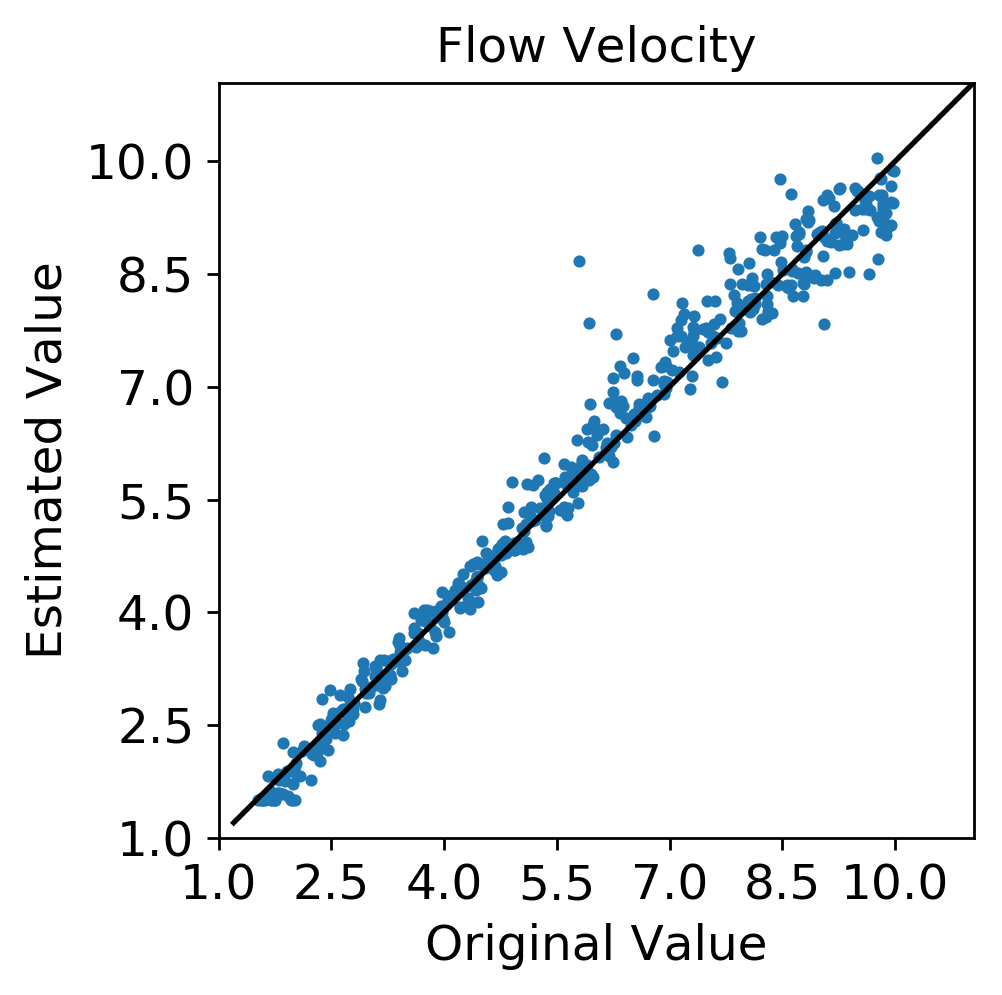

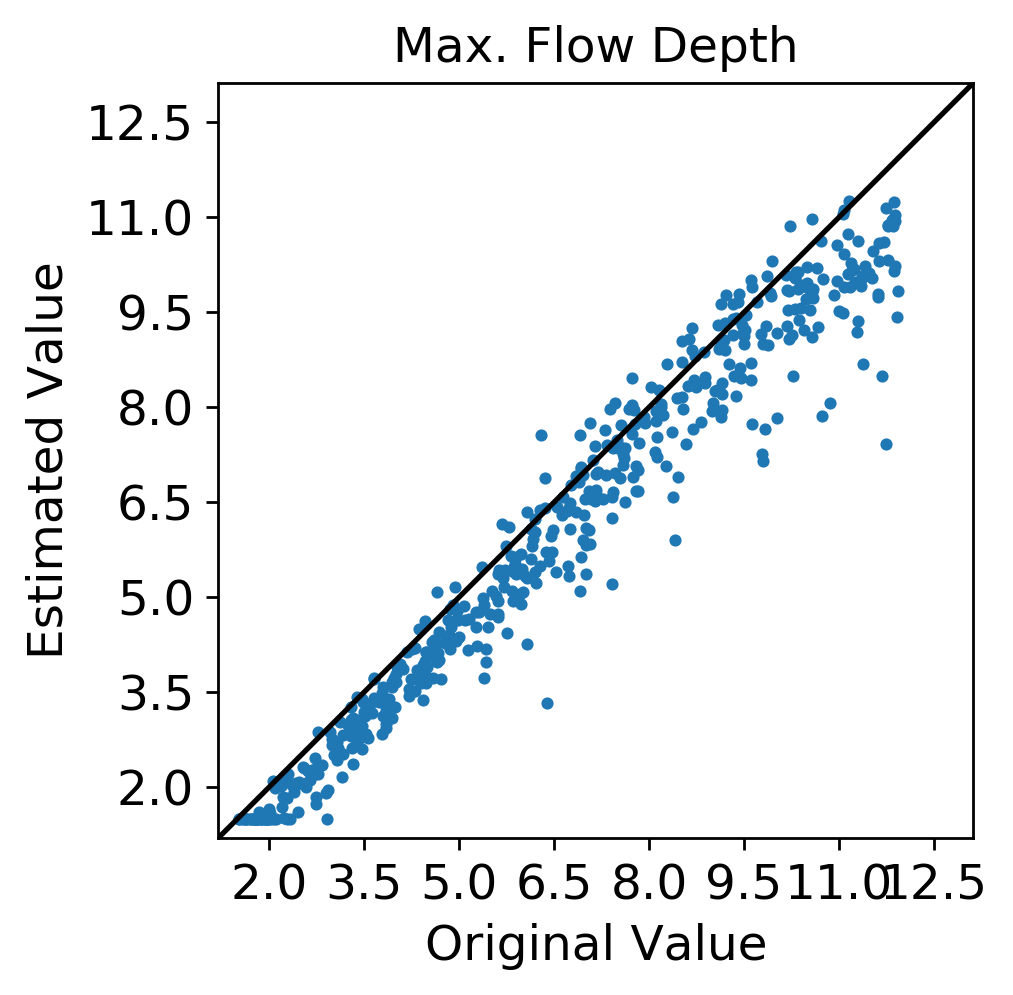

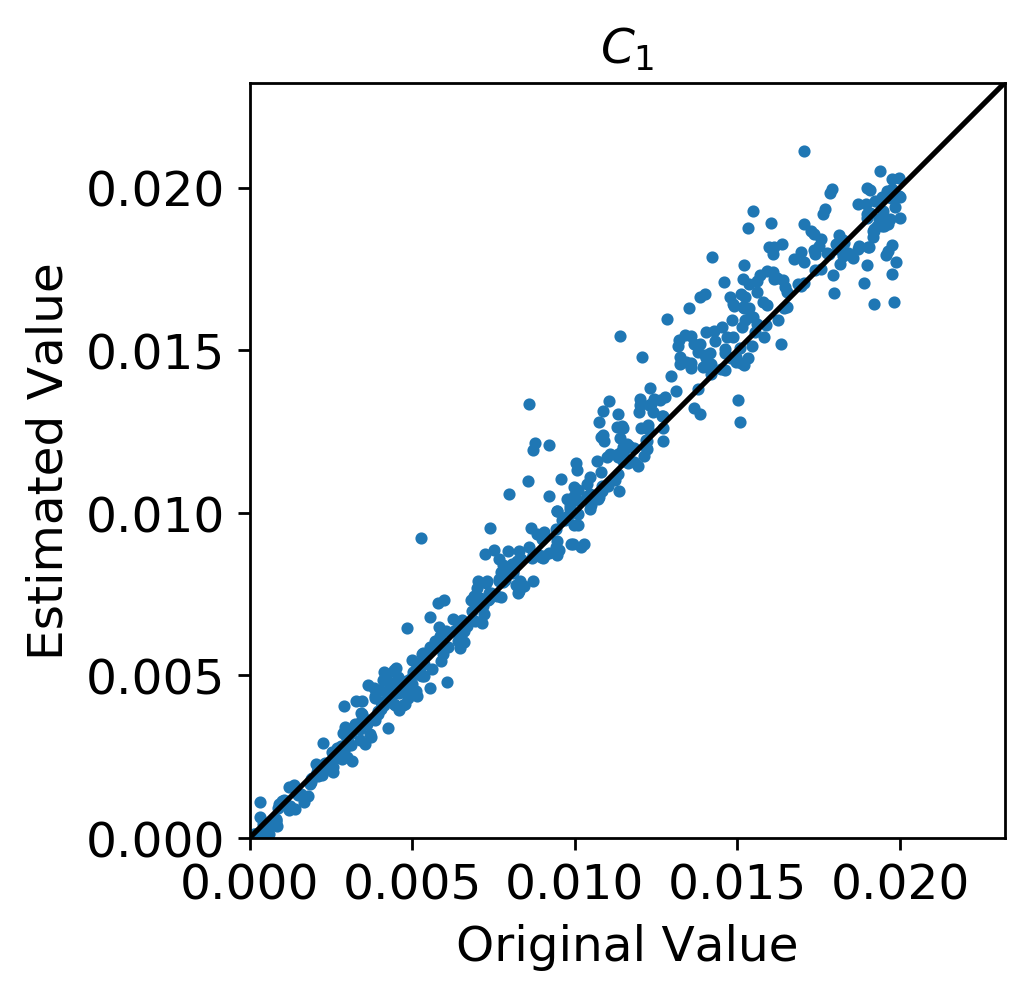

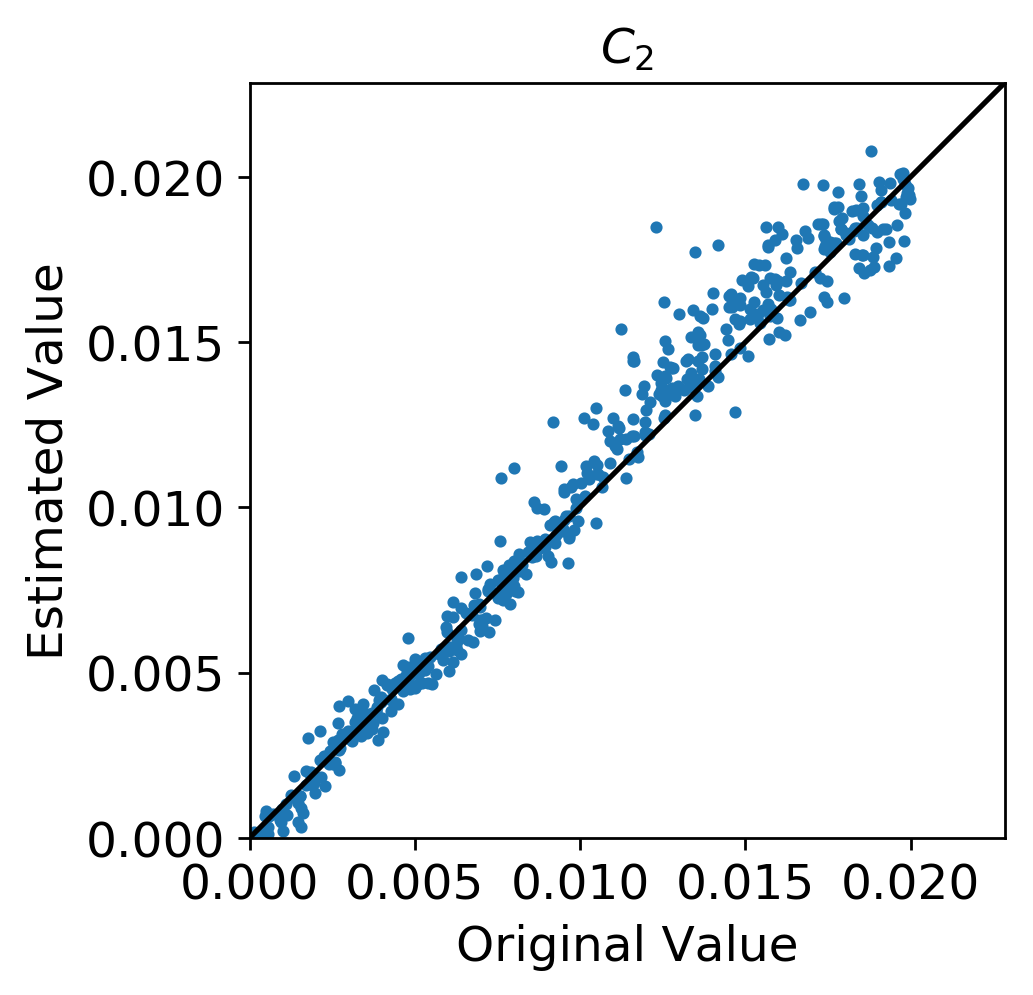

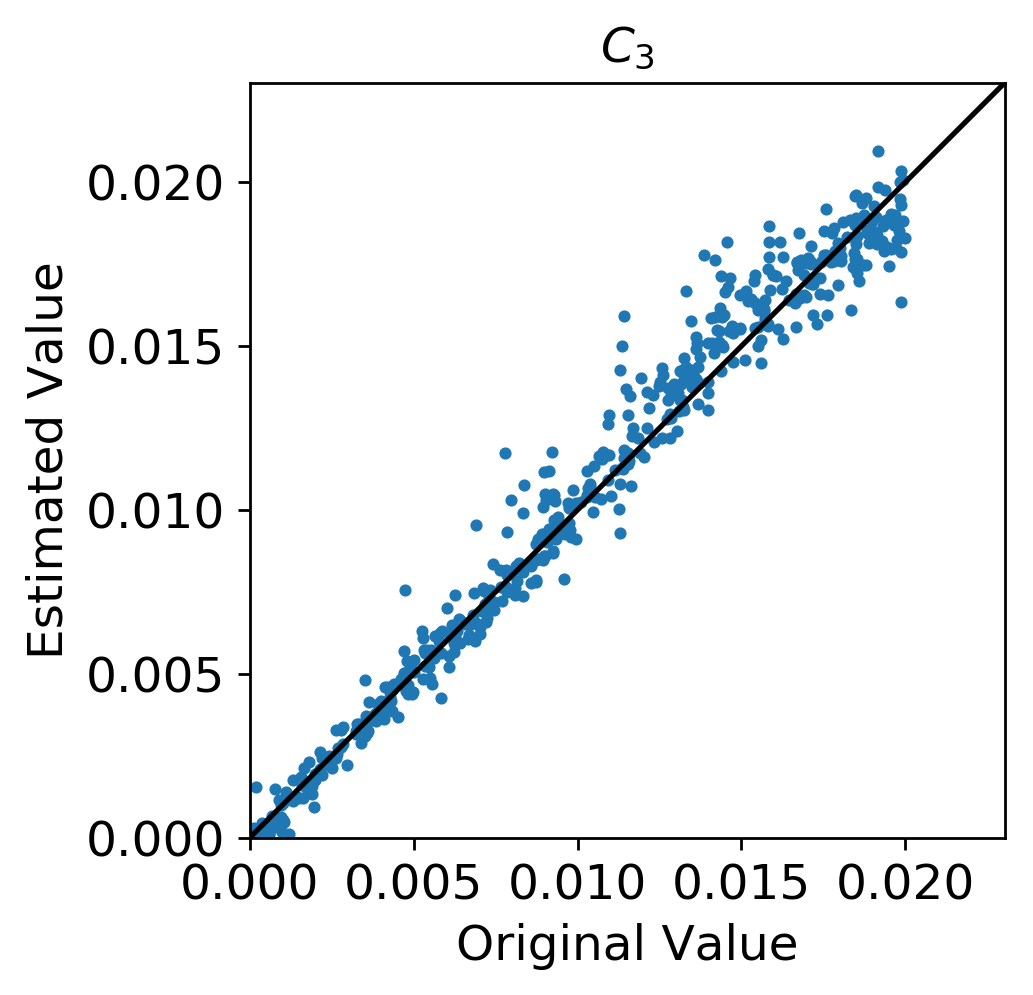

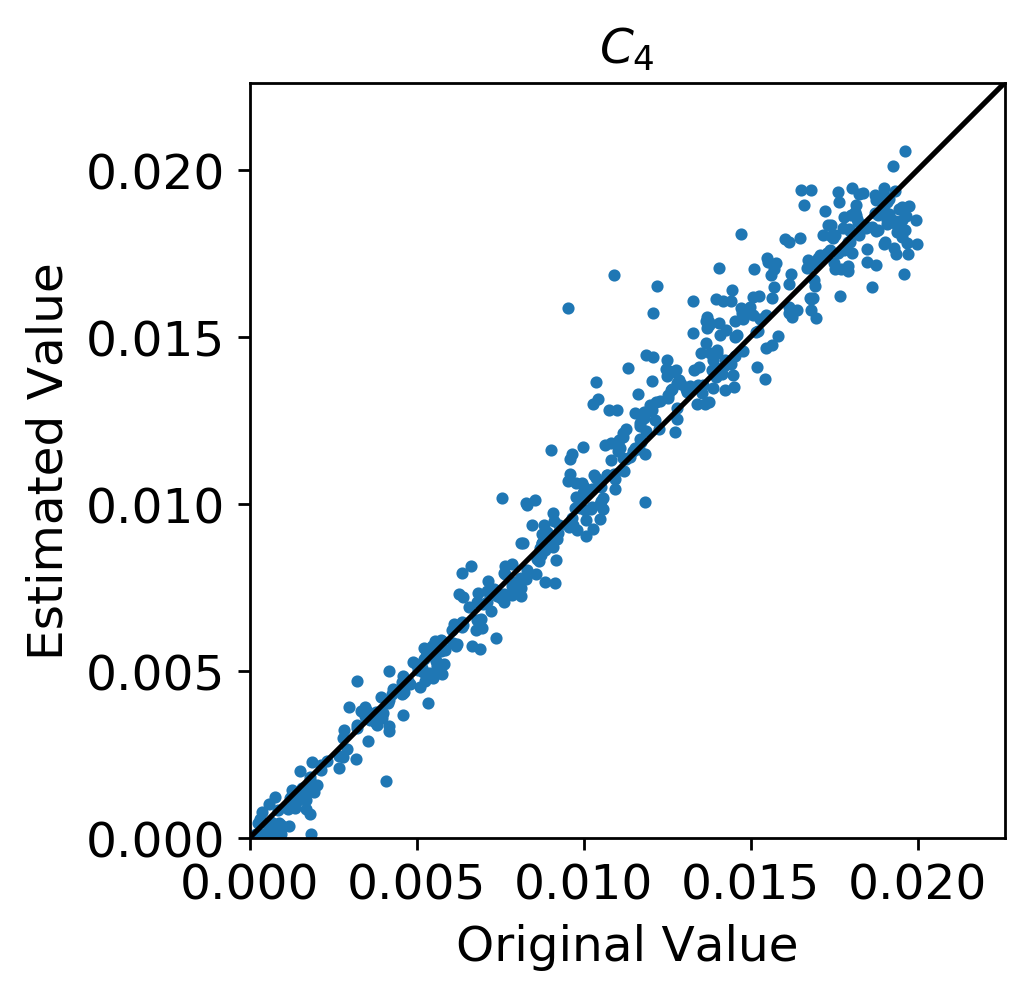

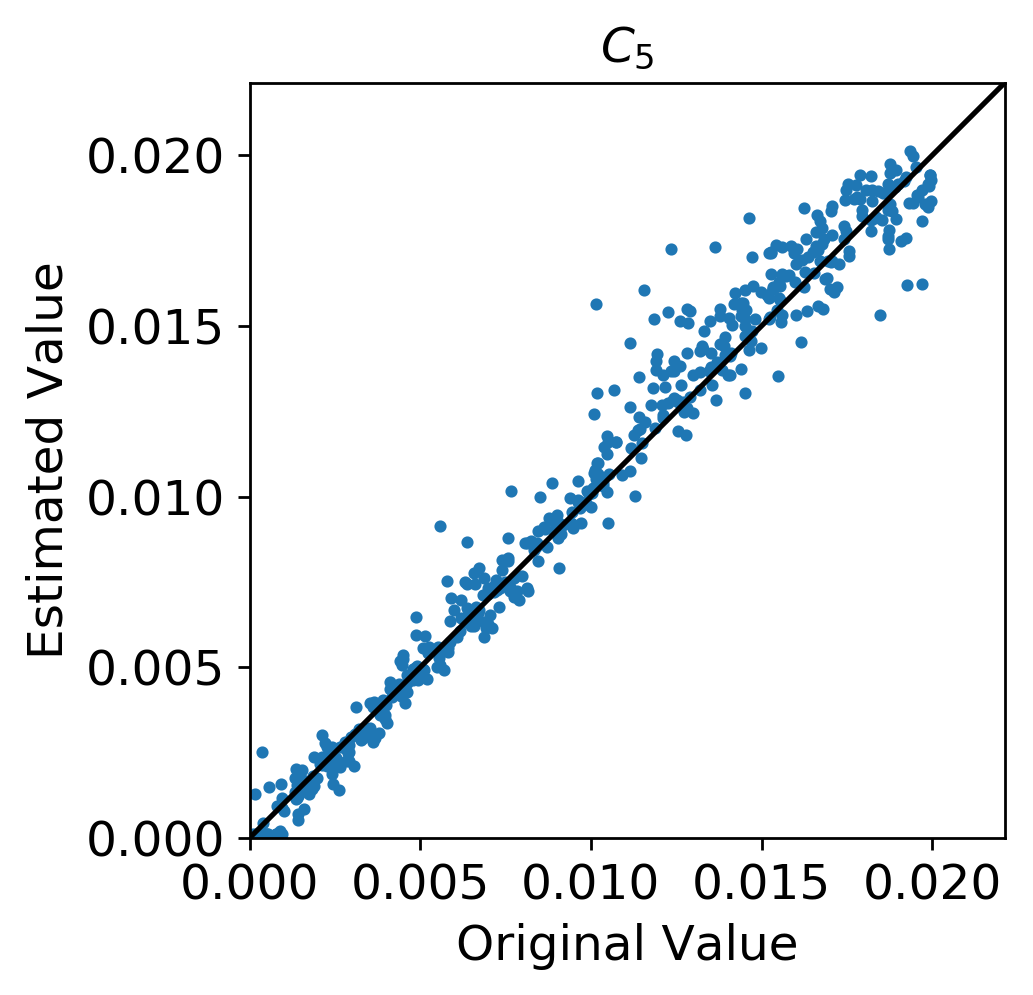

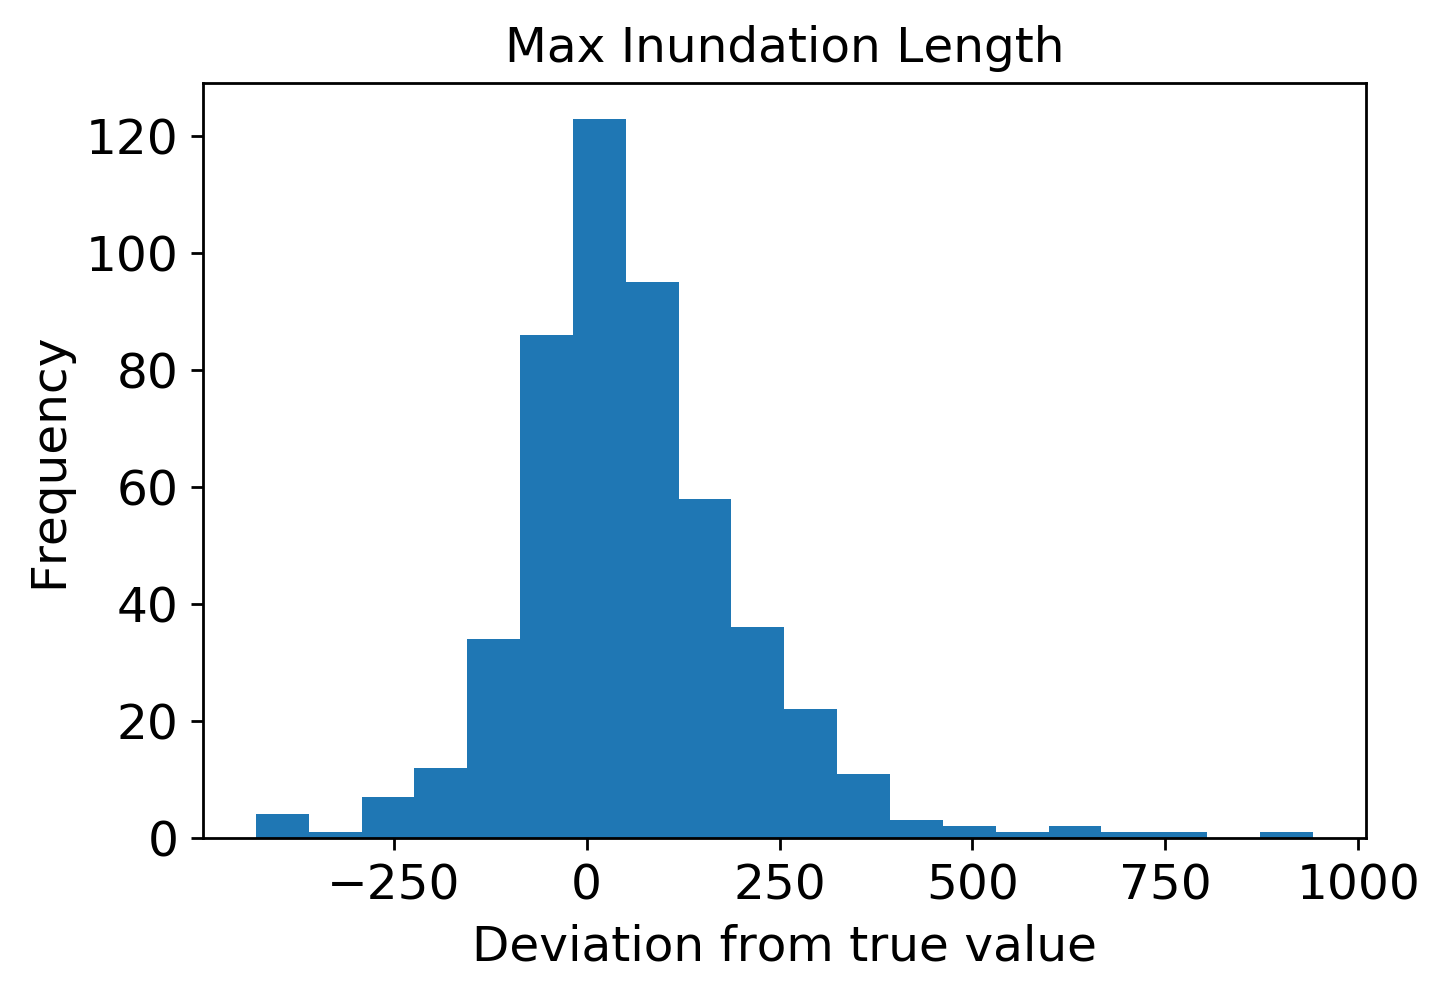

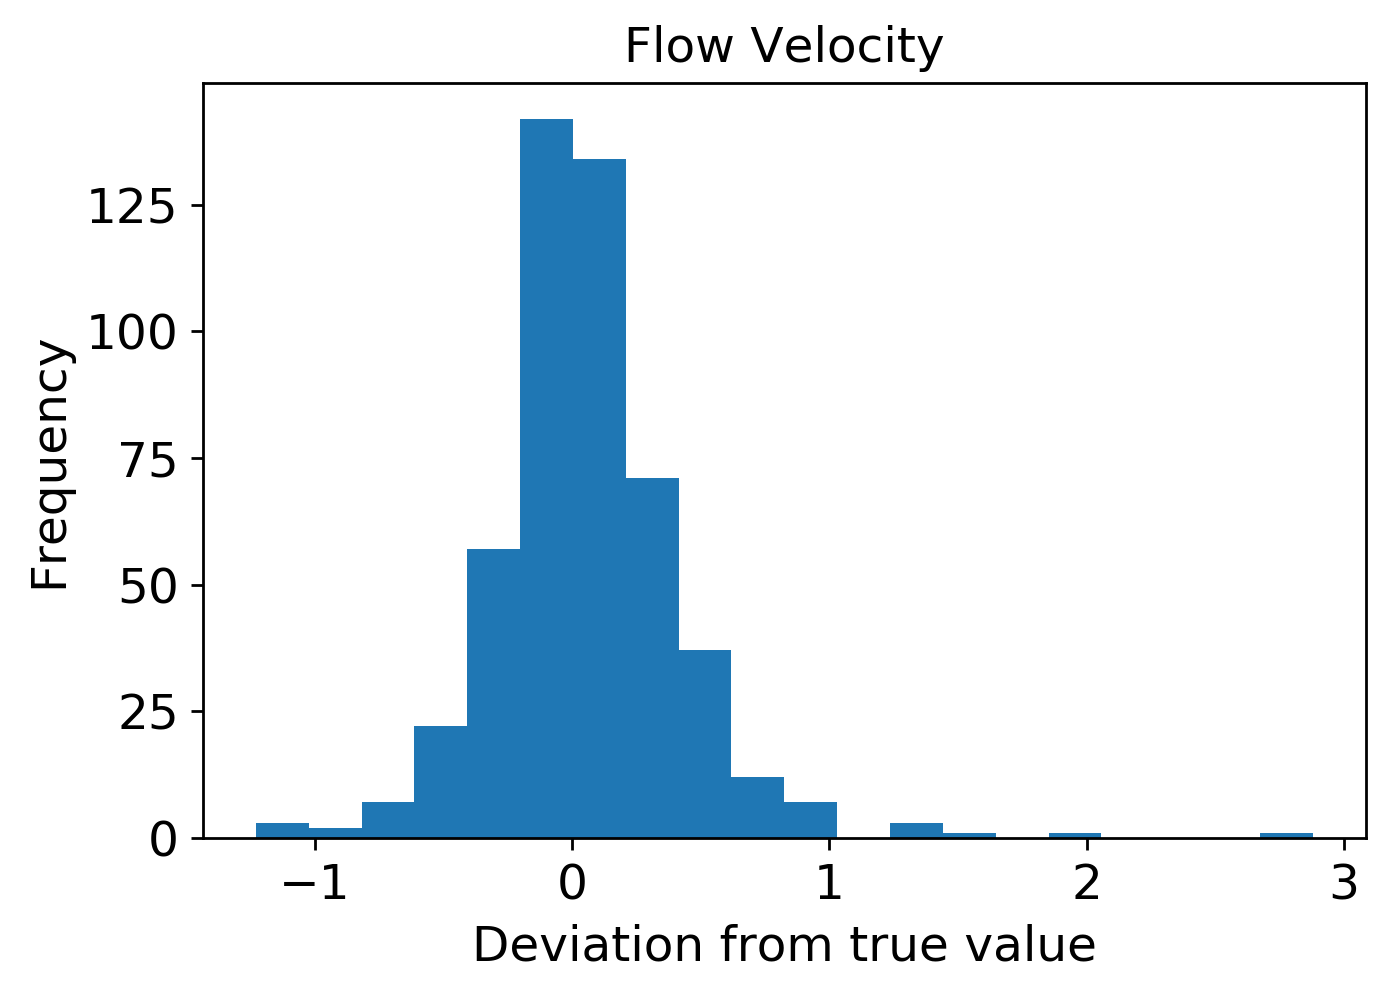

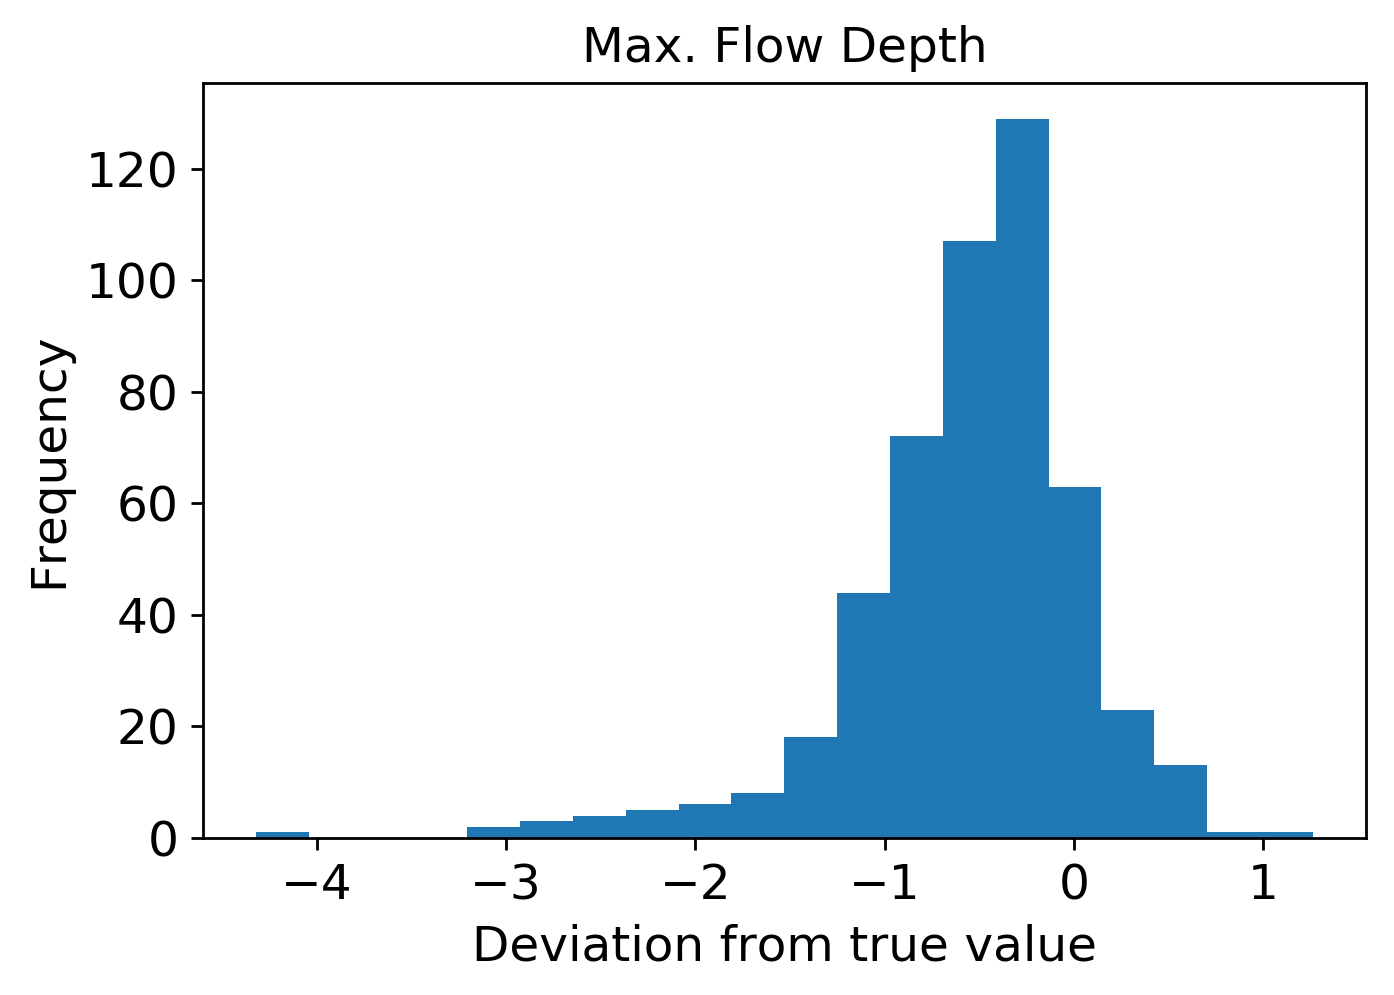

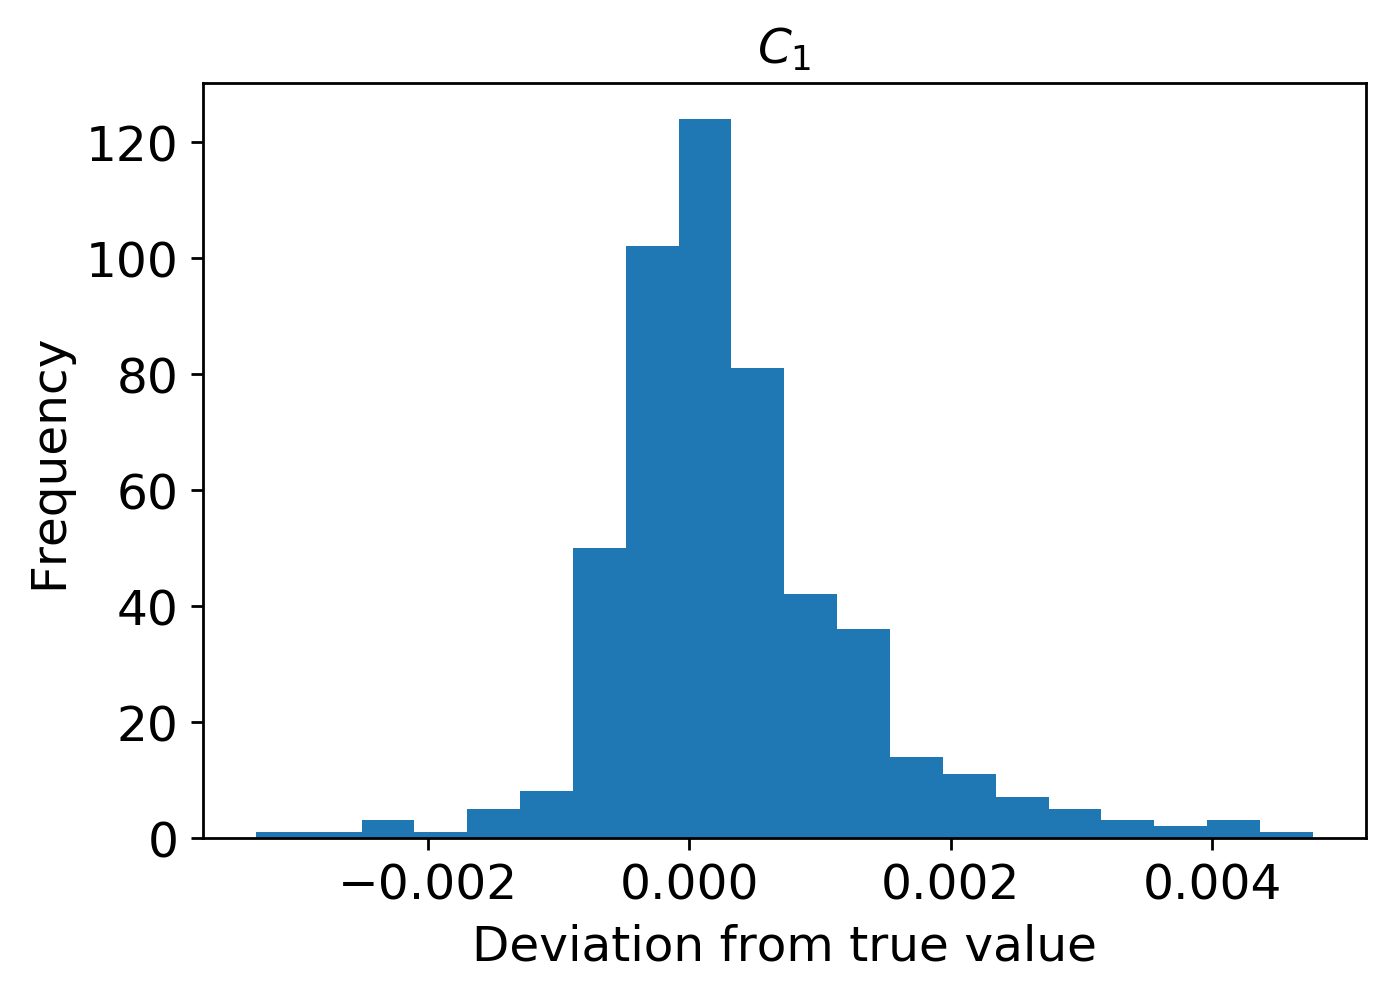

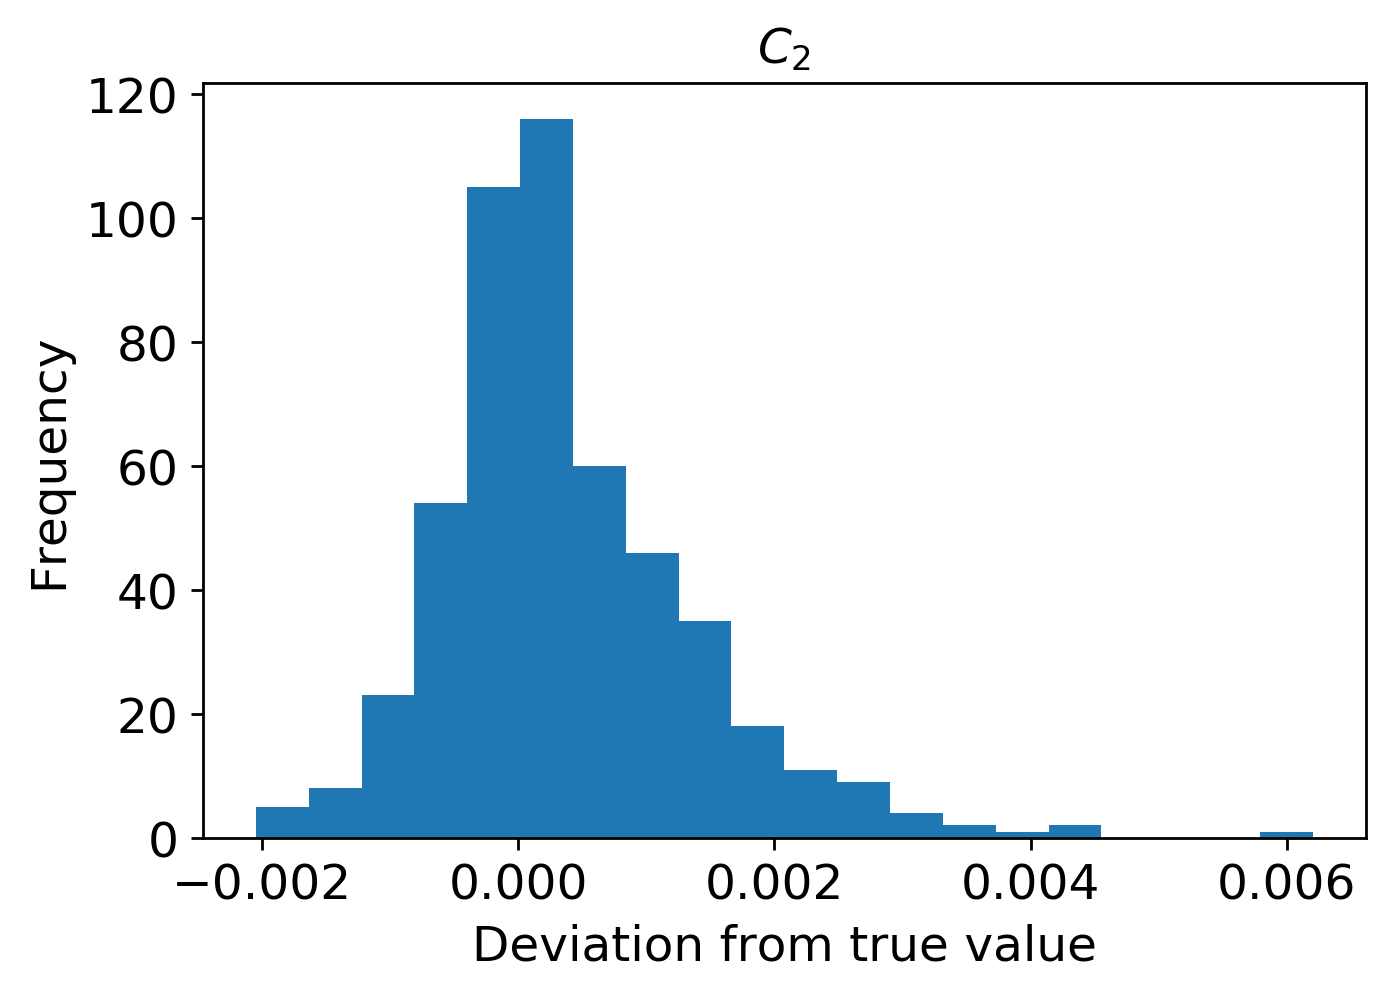

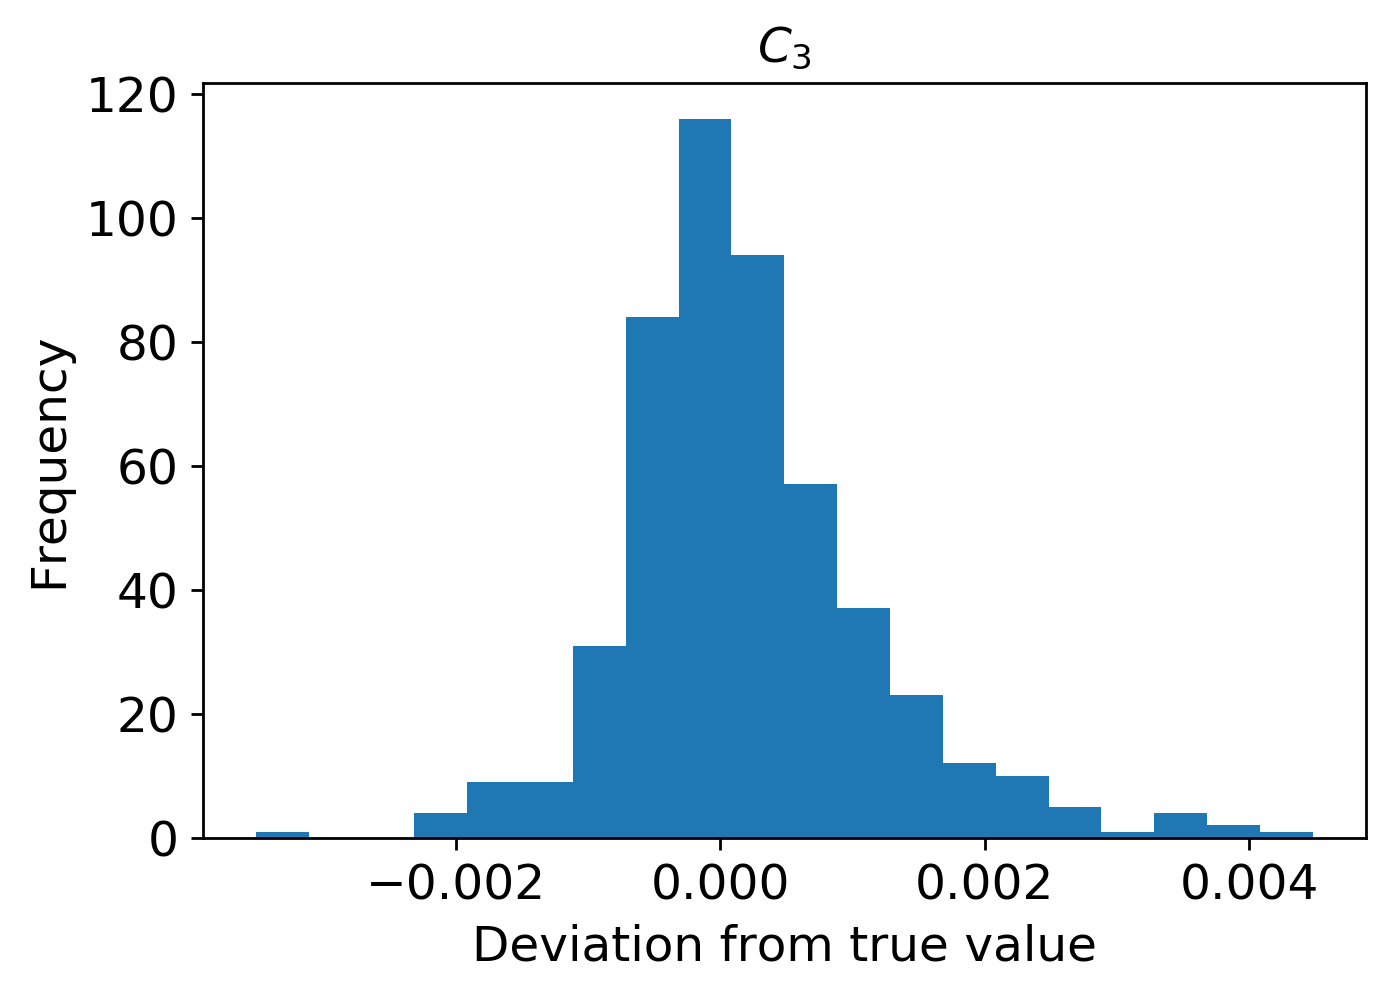

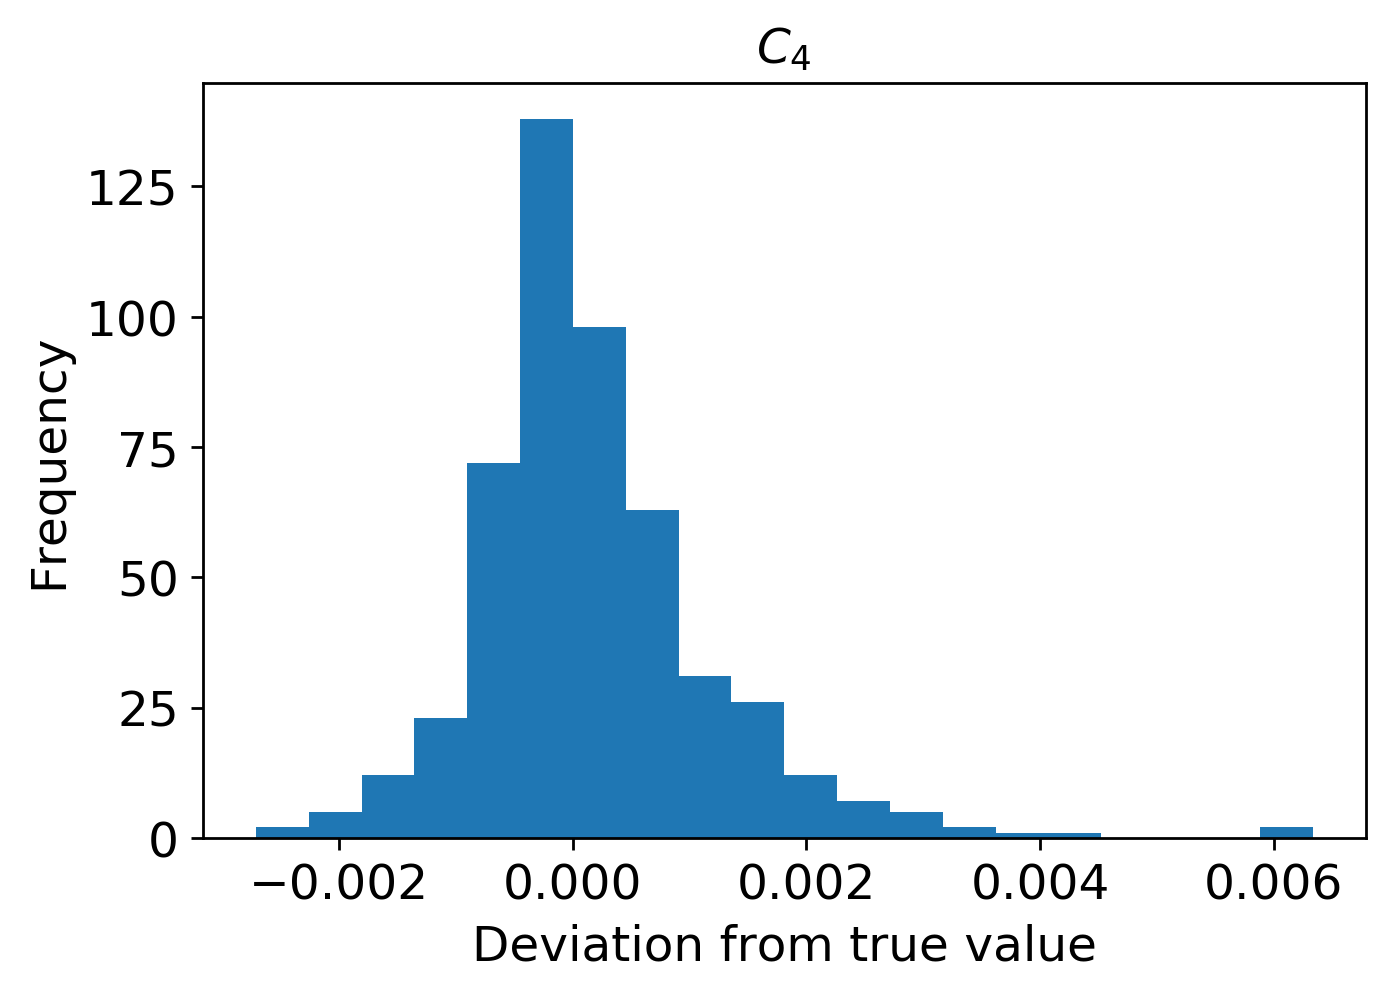

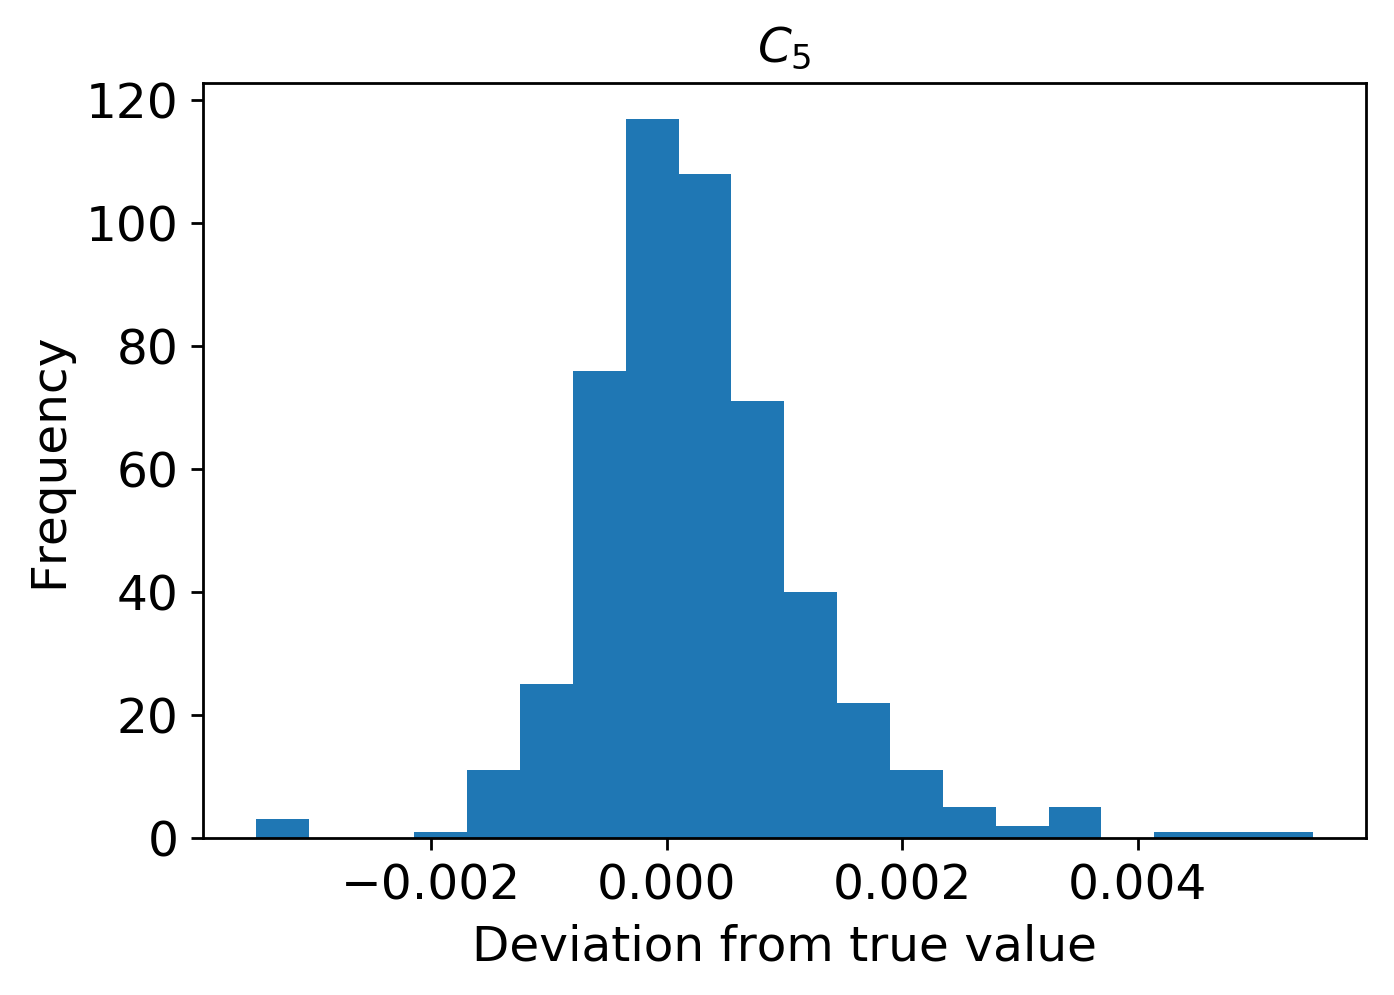

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g5_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g5_j2_roi770_jogan_5500_400grid/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
loss = np.loadtxt(resdir+'loss.txt',delimiter=',')
epoch = range(0,2000)
vloss = np.loadtxt(resdir+'val_loss.txt',delimiter=',')
resi = test_result - icond

fig = plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
plt.plot(epoch, loss, 'bo',label='Loss')
plt.plot(epoch, vloss, 'yo',label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(loc="upper right")
plt.savefig(resdir+ 'mse.pdf')
plt.show()

fig2 = plt.figure()
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$C_5$']
xymin=[770,1.5,1.5,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005]
stepmin=[770,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025]
    
for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(icond[:,i],test_result[:,i],"o",markersize = 2.5)
    x=icond[:,i]
    y=test_result[:,i]
    max_value = np.max([x, y])
    min_value = np.min([x, y])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    #plt.plot([xymin[i],xymax[i]],[xymin[i],xymax[i]],"-",color = 'k')
    plt.axes().set_aspect('equal')
    #plt.ylim(xymin[i],xymax[i])
    #plt.xlim(xymin[i],xymax[i])
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.xlabel('Original Value',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated Value',color=textcol,size=14,**hfont)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + '.eps')
    plt.savefig(resdir+titlelabel[i] + '.pdf')
    #plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb


datadir = '/home/rimali2009/Journal_2/data_g5_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g5_j2_roi770_jogan_5500_400grid/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')
#gclass = 3
#gclass_label = ["500 $\mu$m","125 $\mu$m","63 $\mu$m"]
gclass = 5
gclass_label =  ["500${\mu}m$","420 ${\mu}m$", "354 ${\mu}m$","2970${\mu}m$", "250${\mu}m$"]
gclass_name=['500','420','354','297','250']
topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#Read outcrop data
#dist_max = 22200. #Distance of distal end of learning data
outcrop = pd.read_csv('../Journal_2/jogan_gs5.csv')
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
#d = pd.DataFrame(np.zeros((1, 7)),columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#print(d)
#v=np.concatenate((outcrop, d))
#print(v)
#outcrop=pd.DataFrame(v,columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#outcrop['distance'].iloc[-1]=4000
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0,0]], columns=outcrop.columns))
print(outcrop)

#Preparation under interpolation
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#Complement data
for j in range(gclass):
    #f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="quadratic",bounds_error=False,fill_value='extrapolate')
    #f = interp1d(outcrop['distance'],np.log10(outcrop.iloc[:,j+1]), kind="cubic",bounds_error=False,fill_value='extrapolate') 
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="cubic",bounds_error=False,fill_value='extrapolate') 
    #Interpolation function of jth granularity level
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data


#Normalize data
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
#add=np.array(3000)
#test_result_outcrop_add=np.concatenate((add,test_result_outcrop), axis=None)
#Output results
#print(test_result_outcrop_add)
np.savetxt('outcrop_result_g5_g300_j2_roi770_jogan_5500_400grid.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
for i in range(gclass):
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
plt.legend()
plt.show()

     distance       500       420       354       297       250
0    0.000000  0.030224  0.028134  0.020009  0.003374  0.002354
1  109.646182  0.022025  0.019906  0.013748  0.001795  0.001411
2  450.682215  0.008047  0.007314  0.005040  0.000500  0.000398
3  543.078703  0.015263  0.015181  0.011333  0.001466  0.001100
4  674.221738  0.013651  0.016576  0.014186  0.004167  0.001401
5  766.825235  0.006614  0.009019  0.008032  0.003086  0.000726
6  879.030860  0.001077  0.001459  0.001314  0.000535  0.000121
7  965.302169  0.003922  0.005742  0.005548  0.003179  0.000562
[[5.52551292e+03 4.67423053e+00 3.17357344e+00 1.36131516e-02
  1.21227469e-02 1.09916775e-02 2.82910419e-03 5.25408588e-03]]


<Figure size 640x480 with 1 Axes>

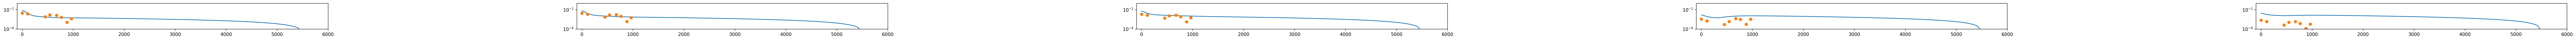

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_jogan_5gs_Rw820_400grid as fmodel
import time
import ipdb
%matplotlib inline


#dist_max = 3000.
gclass = 5
topodx=10.0
#gclass_name = ['840microm','594microm','420microm','297microm','210microm','148microm']#gclass_name = ['500micron', '125micron', '63micron']
gclass_name=['500','420','354','297','250']
gname_tex = ["500${\mu}m$","420 ${\mu}m$", "354 ${\mu}m$","297${\mu}m$","250${\mu}m$"]


estimated_icond=np.loadtxt('outcrop_result_g5_g300_j2_roi770_jogan_5500_400grid.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g5_400grid_gs1.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g5_j2_roi770_400grid.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g5_j2_roi770_400grid.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('eta_estimated_thickness_5K_g5_j2_roi770_400grid.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['500','420','354','297','250'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('eta_estimated_Distance_5K_g5_j2_roi770_400grid.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g5_j2_roi770_400grid.csv',estimated_dep_5000,delimiter=',')
#data_estim=pd.DataFrame(estimated_dep_5000,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#print(estimated_dep_5000)

#Formatting the loaded data
#estimated_dep_df = pd.DataFrame(estimated_dep,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:]]).T,columns=['distance','500micron','125micron','63micron'])
#estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))
#print(estimated_dep_5000)
#Read original data
outcrop = pd.read_csv('F:/Nature/Manuscript/final/jogan_gs5.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','500','420','354','297','250'])
#Plot
plt.figure(num=None, figsize=(100, 1), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.10, wspace=0.8)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    plt.ylim([0.0001,1.0])
    plt.xlim(-100,6000)
    plt.savefig("thickness_distance_curve_joganfinal_g5_2.png")
    plt.savefig("thickness_distance_curve_joganfinal_g5_2_600.eps")
    


Using TensorFlow backend.


     distance       500       420       354       297       250
0    0.000000  0.030224  0.028134  0.020009  0.003374  0.002354
1  109.646182  0.022025  0.019906  0.013748  0.001795  0.001411
2  450.682215  0.008047  0.007314  0.005040  0.000500  0.000398
3  543.078703  0.015263  0.015181  0.011333  0.001466  0.001100
4  674.221738  0.013651  0.016576  0.014186  0.004167  0.001401
5  766.825235  0.006614  0.009019  0.008032  0.003086  0.000726
6  879.030860  0.001077  0.001459  0.001314  0.000535  0.000121
7  965.302169  0.003922  0.005742  0.005548  0.003179  0.000562
     distance       500       420       354       297       250
0  109.646182  0.022025  0.019906  0.013748  0.001795  0.001411
1  450.682215  0.008047  0.007314  0.005040  0.000500  0.000398
2  543.078703  0.015263  0.015181  0.011333  0.001466  0.001100
3  674.221738  0.013651  0.016576  0.014186  0.004167  0.001401
4  766.825235  0.006614  0.009019  0.008032  0.003086  0.000726
5  879.030860  0.001077  0.001459  0.001

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


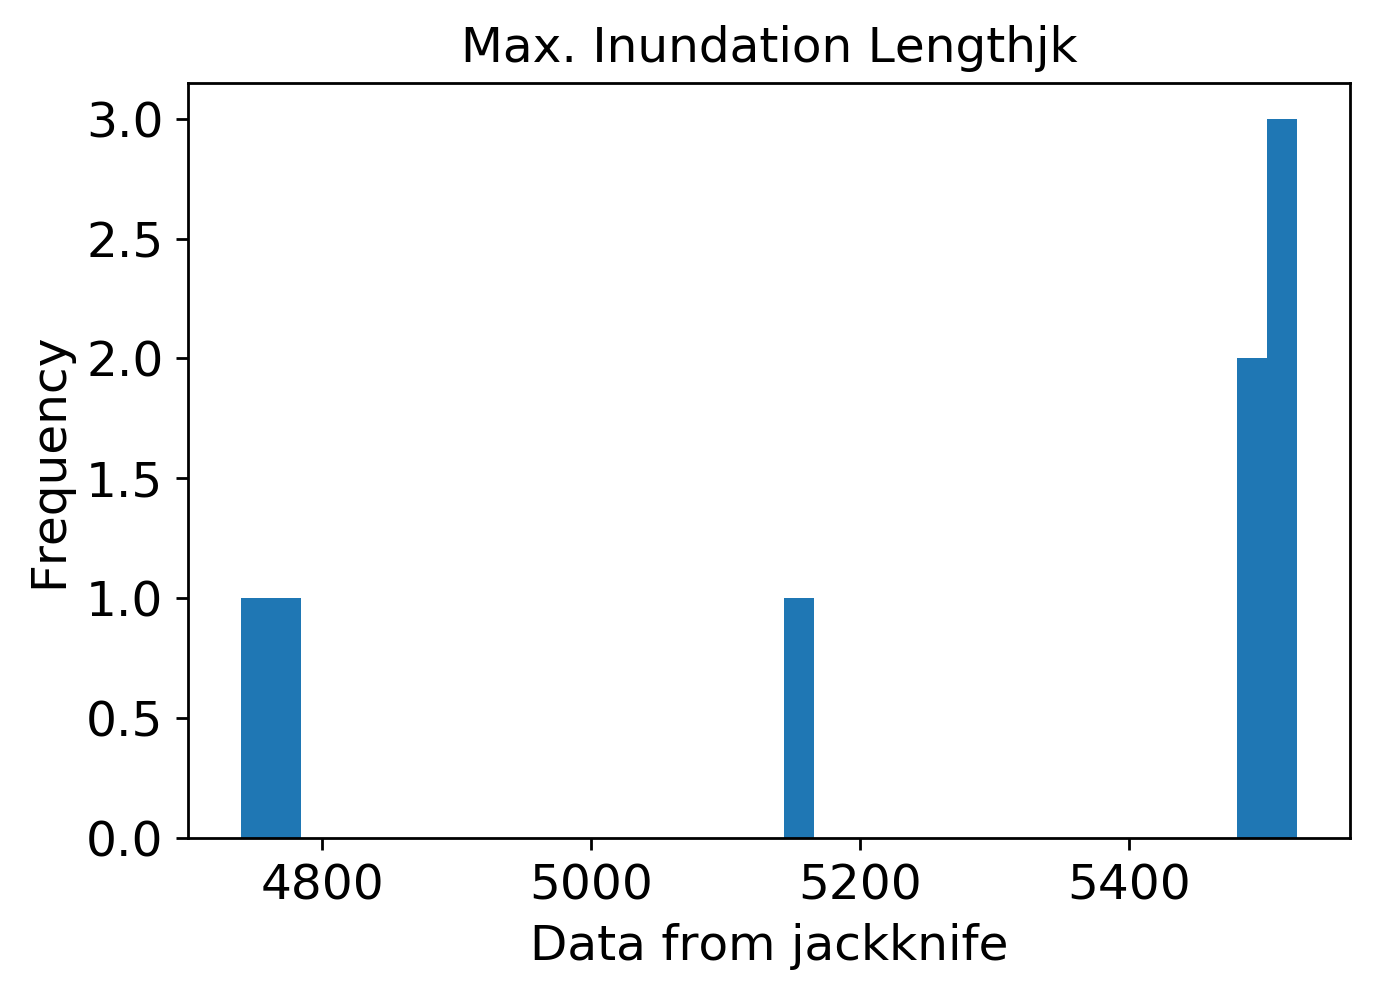

mean: 4.341938545999506
jk_e: 0.704806484517783
CI 1.3814207096548548


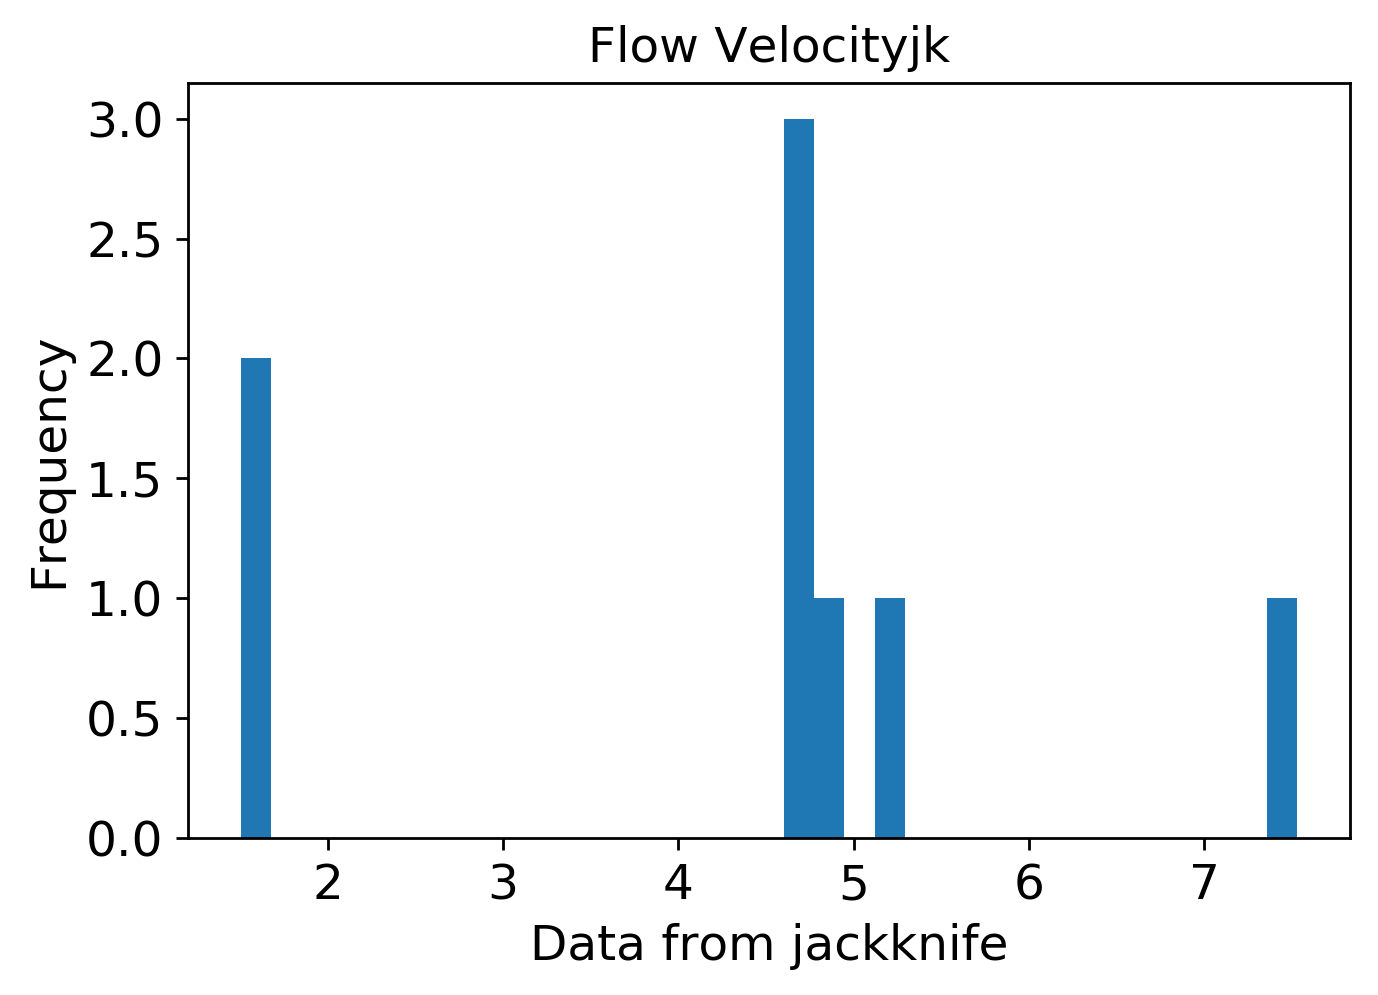

mean: 3.538124234307222
jk_e: 0.5118375606837872
CI 1.0032016189402229


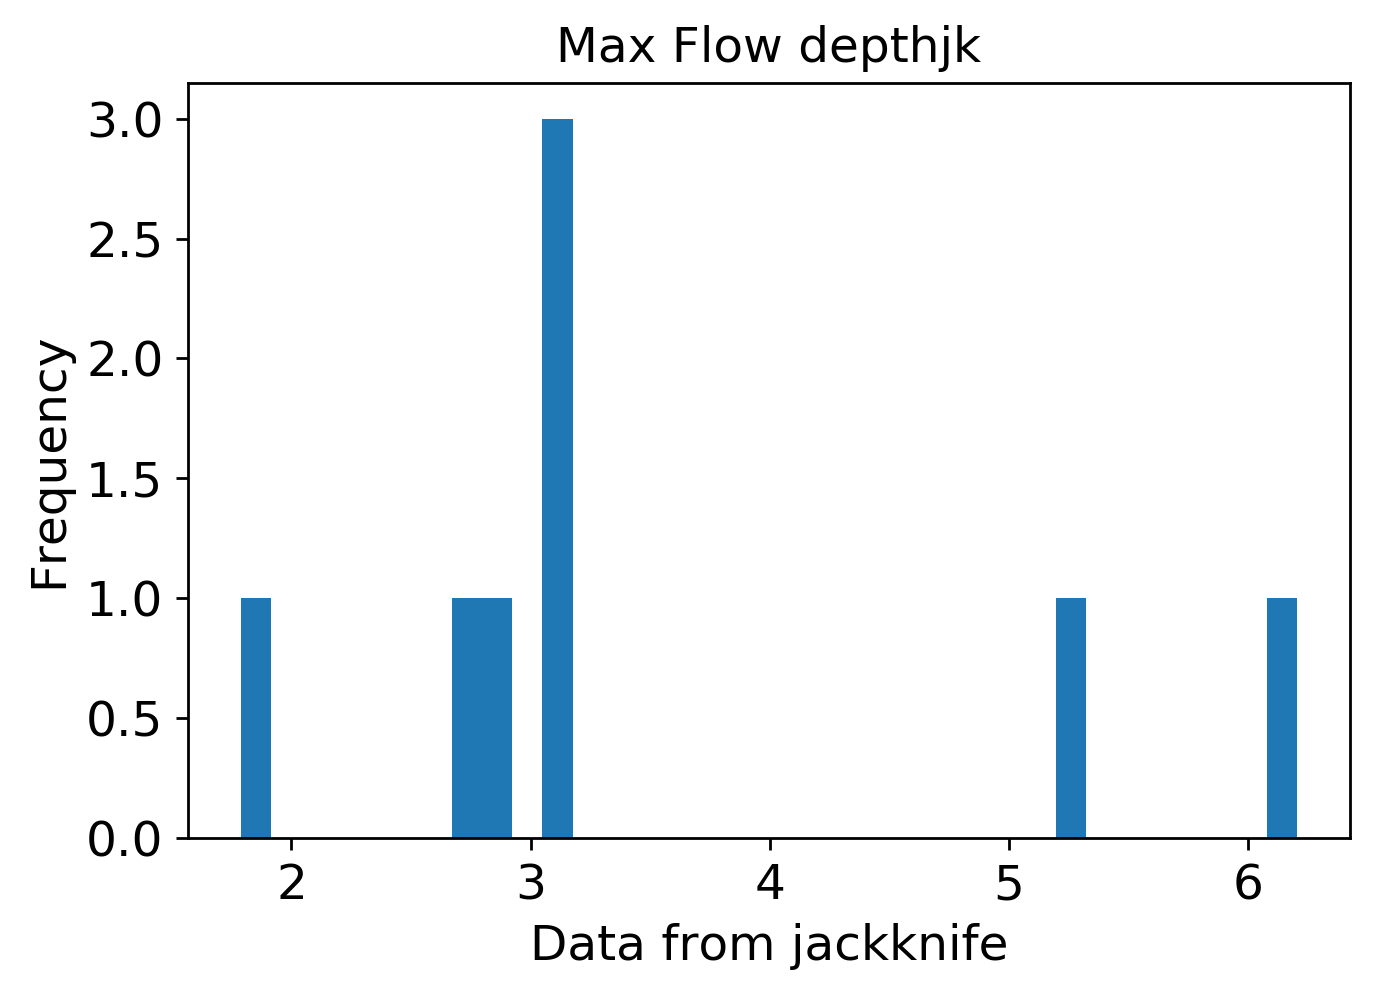

mean: 0.01264782573504106
jk_e: 0.0011815914495858213
CI 0.0023159192411882096


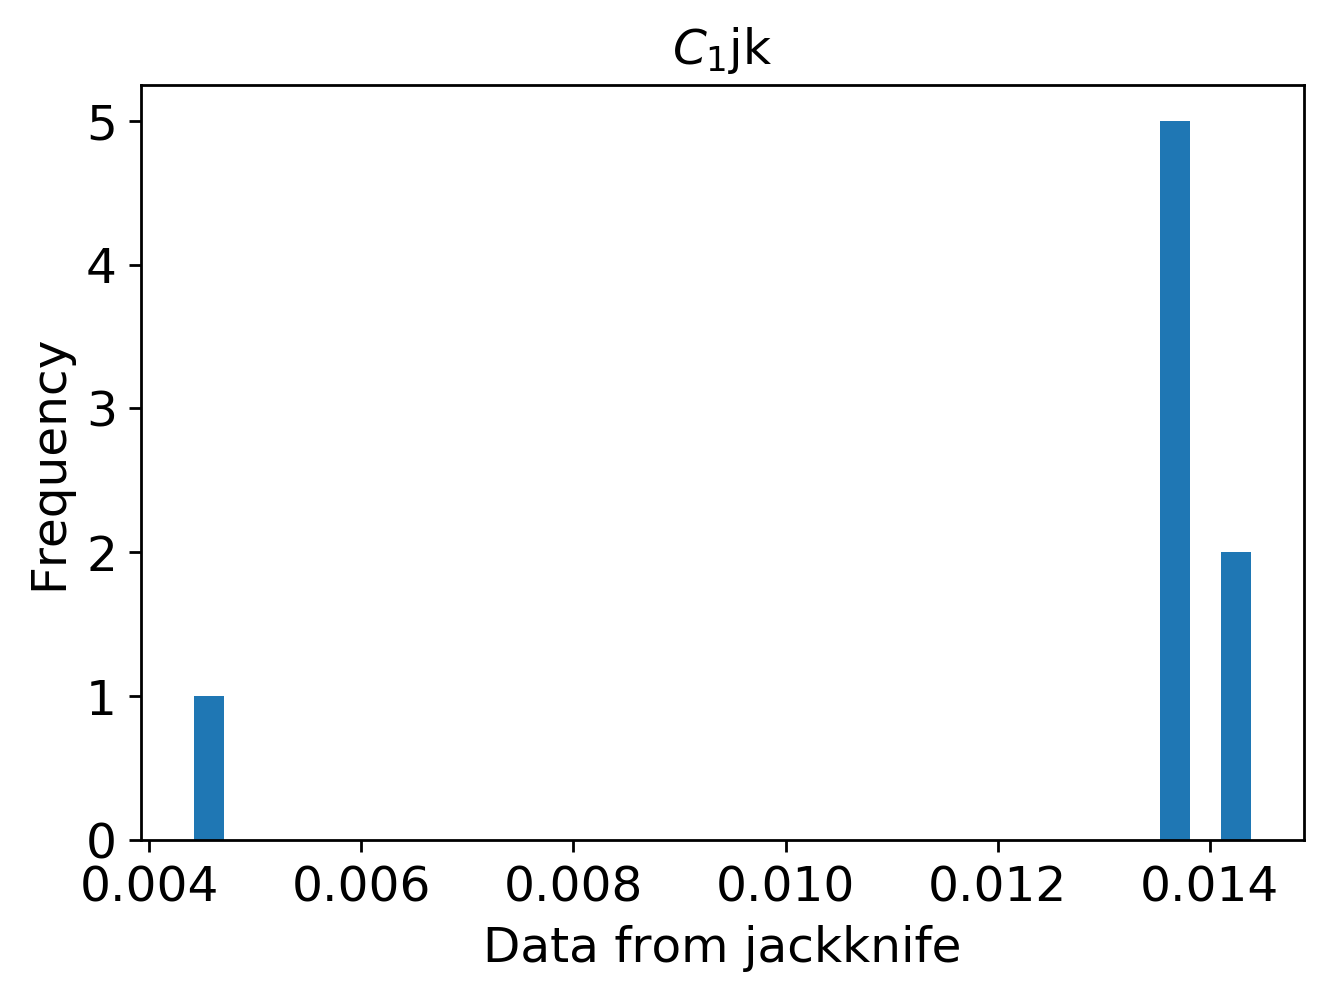

mean: 0.011490973994428834
jk_e: 0.0009745579942474383
CI 0.001910133668724979


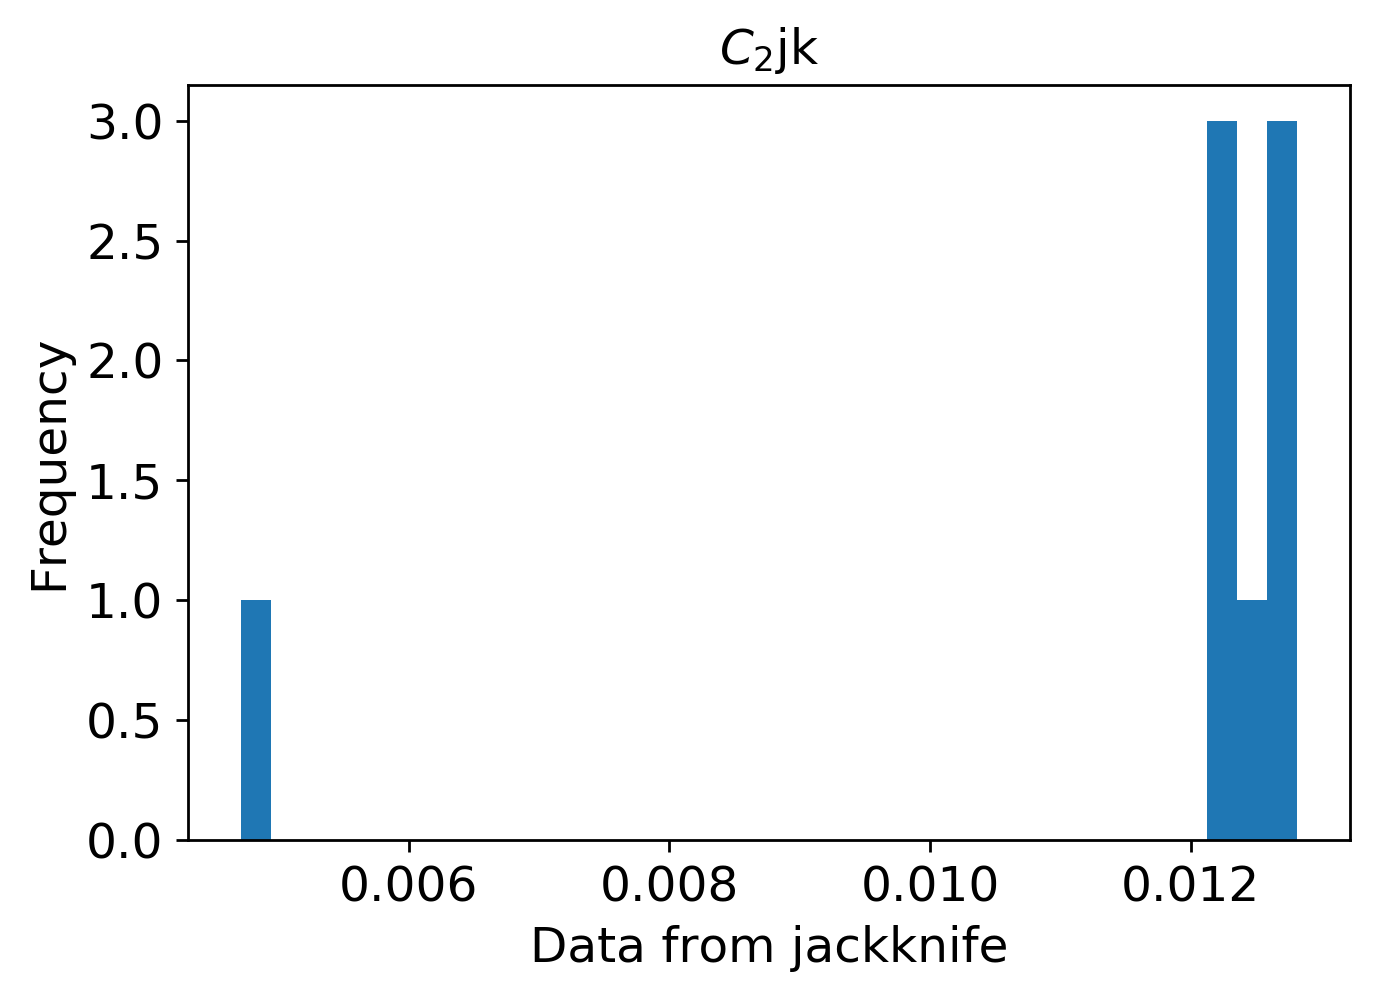

mean: 0.01005850430379559
jk_e: 0.0009127921474572503
CI 0.0017890726090162106


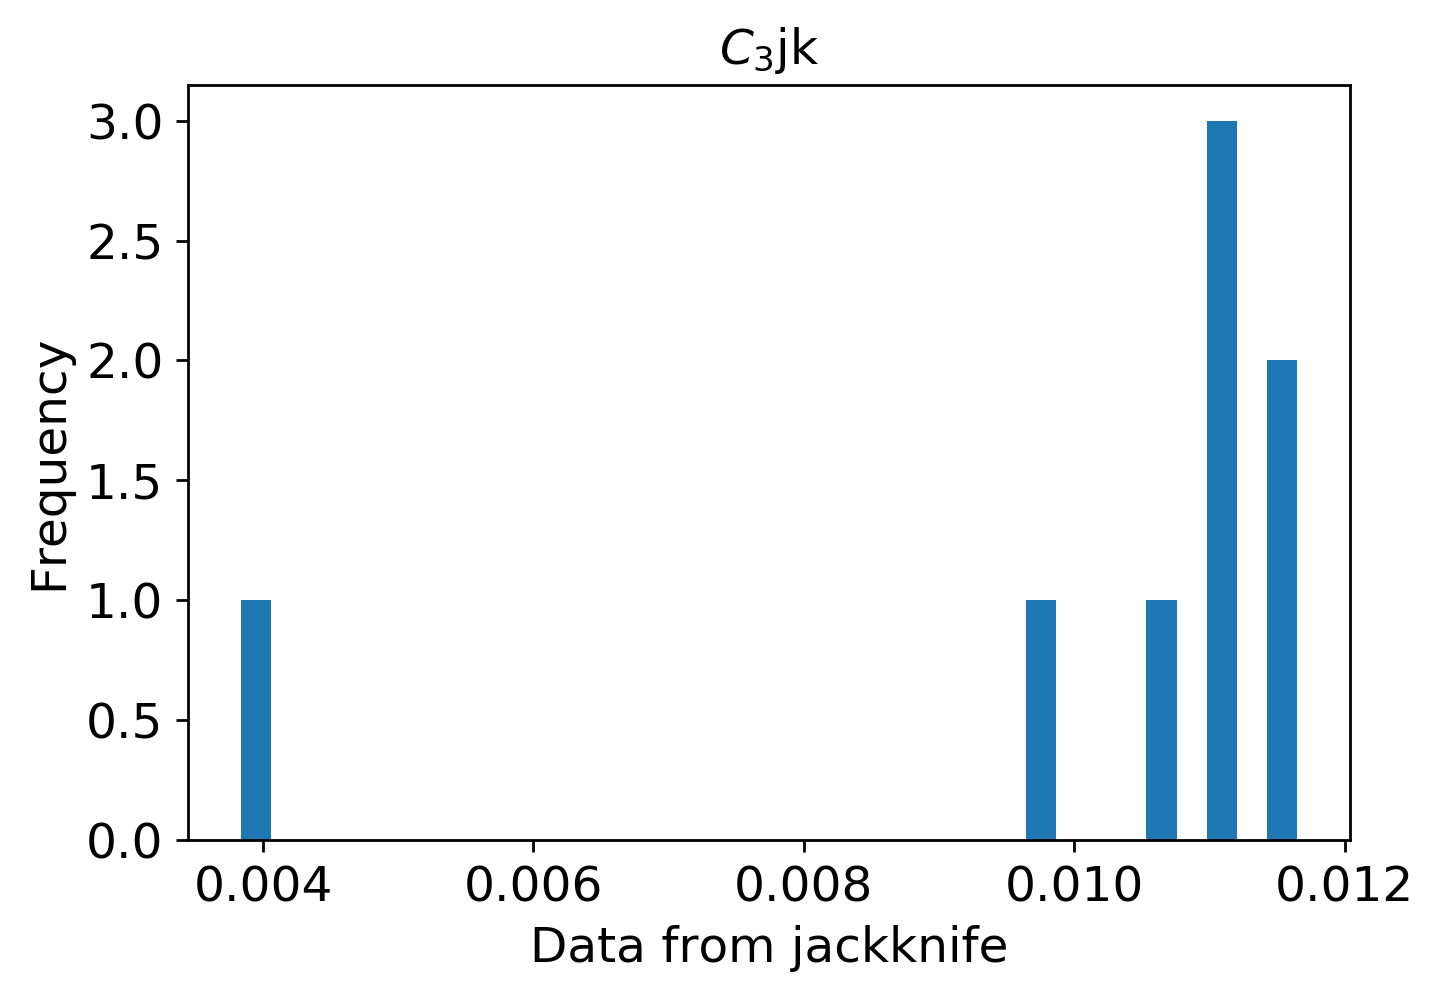

mean: 0.0022558493963697824
jk_e: 0.0003900627024162156
CI 0.0007645228967357826


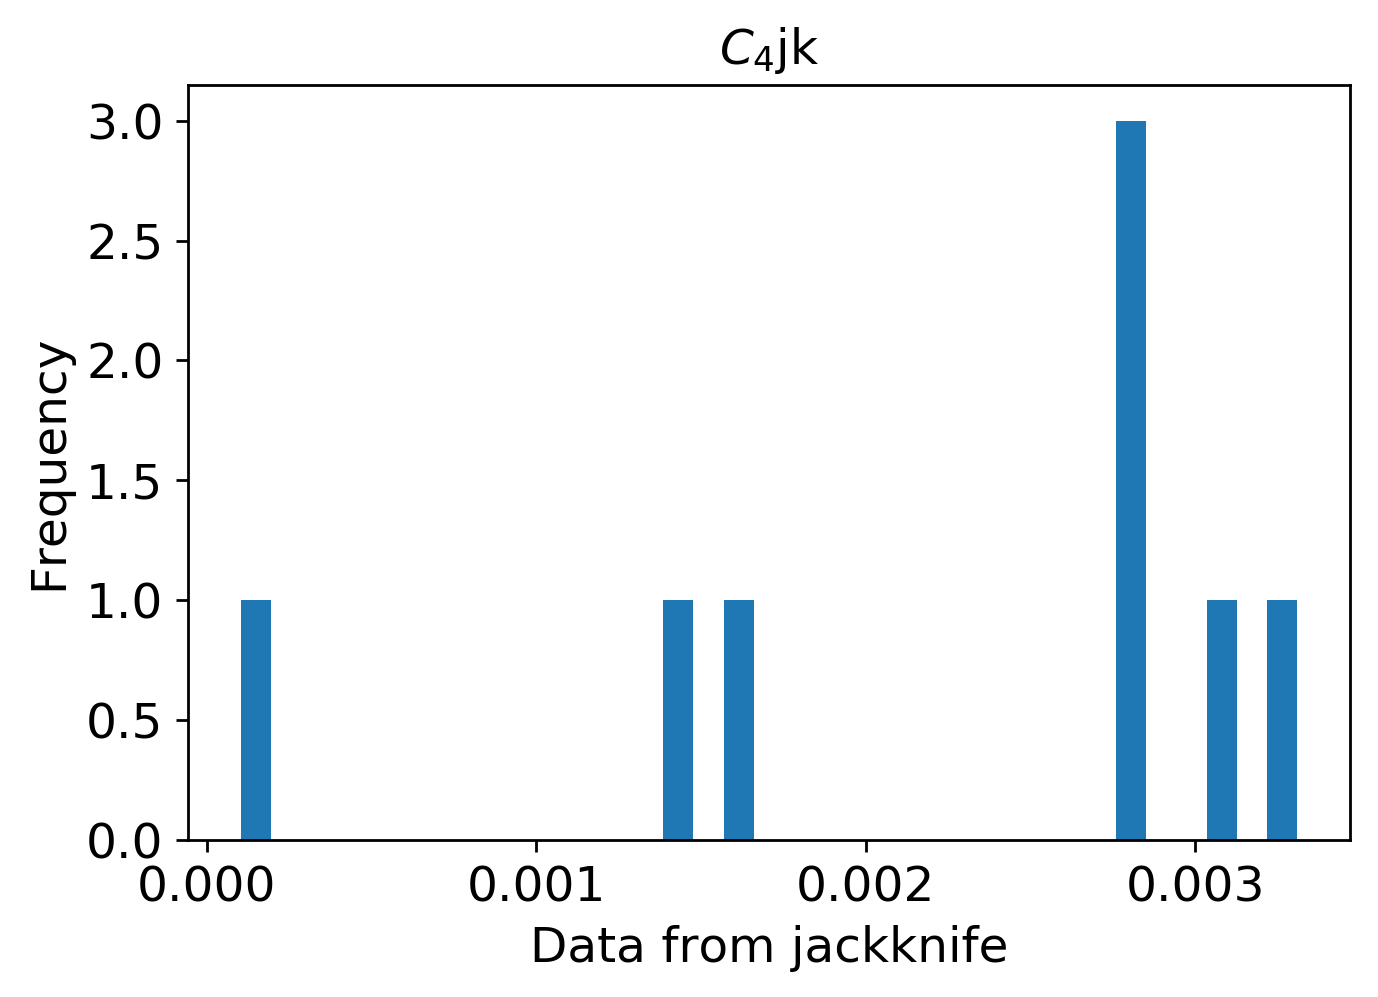

mean: 0.0040264712342941615
jk_e: 0.0007401100301895232
CI 0.0014506156591714654


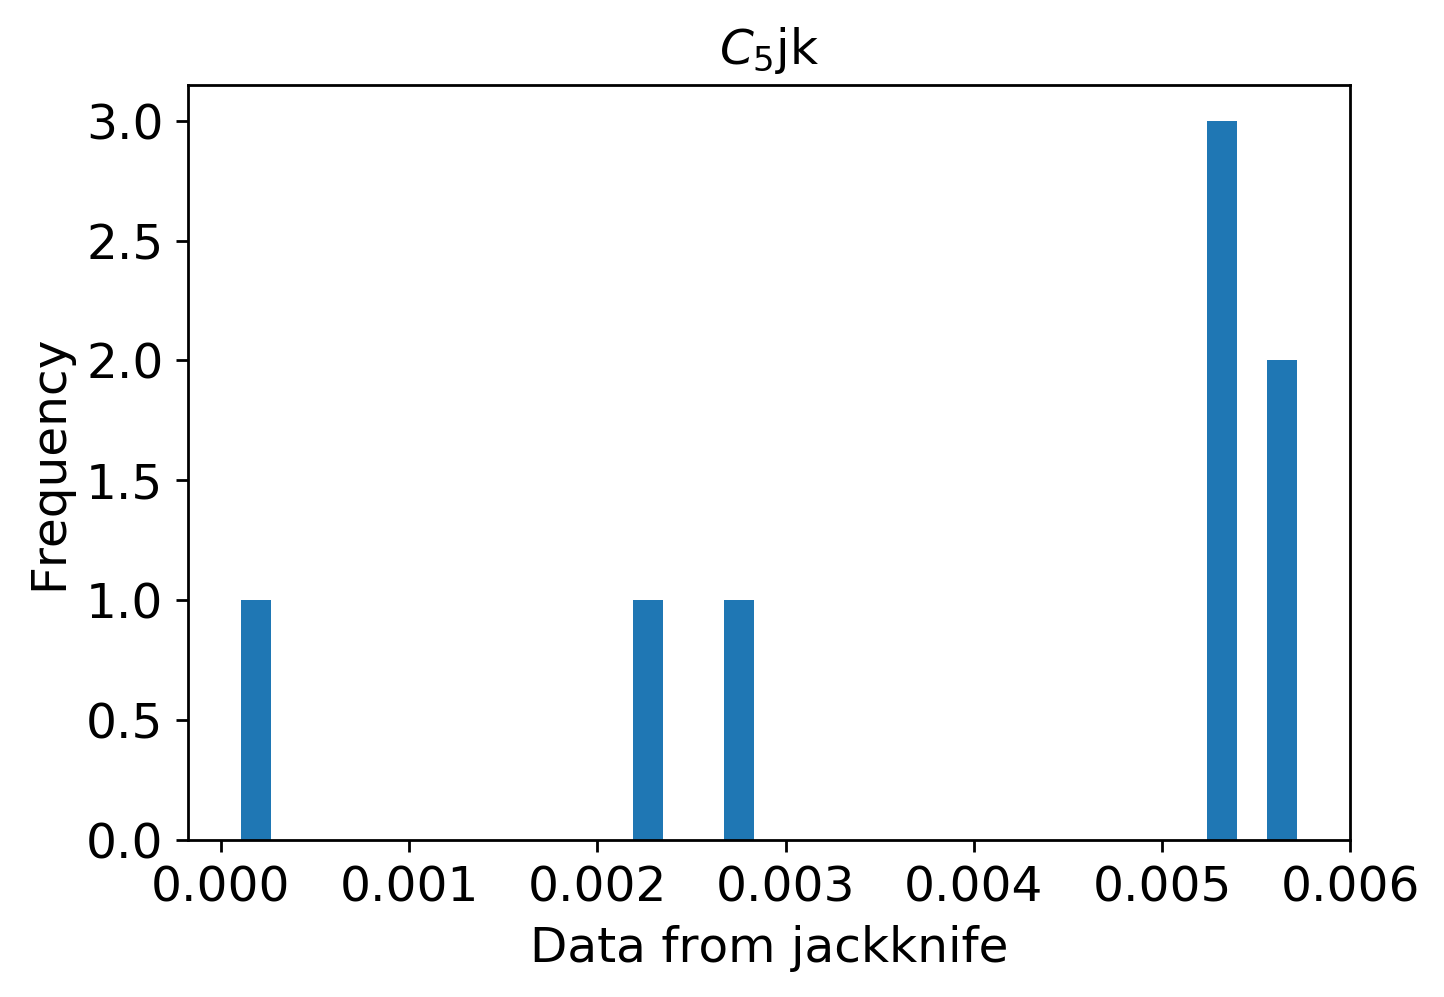

In [17]:
# Jackknife Method
import csv
import numpy as np
import pandas as pd
import math
from keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g5_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g5_j2_roi770_jogan_5500_400grid/5000/'
# Initial setting
if not "model" in locals():
    model = load_model(resdir+'model3.hdf5')
gclass = 5
#gclass_label = ["406 ${\mu}m$", "268 ${\mu}m$",
                #"177 ${\mu}m$", "117 ${\mu}m$"]
topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt', delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt', delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt', delimiter=',')


a = pd.read_csv(
    '../Journal_2/jogan_gs5.csv', delimiter=',')
print(a)
y = pd.DataFrame()
output = []

with open('output_final_jogan_gs5.csv', 'w') as outfile:

    # x=[]
    for index in range(len(a)):
        df = y.append(pd.read_csv(
            '../Journal_2/jogan_gs5.csv', skiprows=[index+1]))
        print(df)
        df = df.sort_values('distance')
        thick_interp = np.zeros([1, coord_num*gclass])
        x = np.arange(0, coord_num*topodx, topodx)
        for j in range(gclass):
            # Interpolation function of jth granularity level
            f = interp1d(df['distance'], df.iloc[:, j+1],
                         kind="cubic", bounds_error=False,fill_value='extrapolate')
            thick_interp[0, coord_num*j:coord_num*(j+1)] = f(x)
        thick_interp[thick_interp < 0] = 0
        thick_interp_norm = (thick_interp - min_x) / (max_x - min_x)
        test_result_outcrop = model.predict(thick_interp_norm)
        test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
        print(test_result_outcrop.shape)
        print(test_result_outcrop)
    # output.append(test_result_outcrop)
        np.savetxt(outfile,test_result_outcrop, delimiter=',')
        # outfile.write('# New iteration\n')
hfont = {'fontname': 'Century Gothic'}
textcol = 'k'
resi = np.loadtxt('output_final_jogan_gs5.csv', delimiter=',')
titlelabel = ['Max. Inundation Lengthjk','Flow Velocityjk', 'Max Flow depthjk',
              '$C_1$jk', '$C_2$jk', '$C_3$jk', '$C_4$jk','$C_5$jk']
jk_er=[]
with open('jk_e_770jogan_g5','wb') as ftext:
    for i in range(len(titlelabel)):
        plt.figure(num=None, dpi=250, facecolor='w', edgecolor='k')
        plt.hist(resi[:, i], bins=35)
        mean = sum(resi[:,i]) / len(resi[:,i])
        print("mean:",mean)
        var_jk  = sum(pow(x-mean,2) for x in resi[:,i]) / ((len(resi[:,i])-1)*(len(resi[:,i])))
        jk_e= math.sqrt(var_jk)
        #ci_u=mean+(1.96*jk_e)
        #ci_l=mean-(1.96*jk_e)
        CI=(1.96*jk_e)
        print("jk_e:",jk_e)
        #print("CI_u", ci_u)
        #print("CI_l",ci_l)
        print("CI",CI)
        e=np.append(jk_e,jk_er)
        np.savetxt(ftext,e,delimiter=',')
        plt.title(titlelabel[i], color=textcol, size=14, **hfont)
        plt.xlabel('Data from jackknife', color=textcol, size=14, **hfont)
        plt.ylabel('Frequency', color=textcol, size=14, **hfont)
        plt.tick_params(labelsize=14, colors=textcol)
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.eps')
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.pdf')
        plt.show()

     distance       500       420       354       297       250
0    0.000000  0.030224  0.028134  0.020009  0.003374  0.002354
1  109.646182  0.022025  0.019906  0.013748  0.001795  0.001411
2  450.682215  0.008047  0.007314  0.005040  0.000500  0.000398
3  543.078703  0.015263  0.015181  0.011333  0.001466  0.001100
4  674.221738  0.013651  0.016576  0.014186  0.004167  0.001401
5  766.825235  0.006614  0.009019  0.008032  0.003086  0.000726
6  879.030860  0.001077  0.001459  0.001314  0.000535  0.000121
7  965.302169  0.003922  0.005742  0.005548  0.003179  0.000562
[[0.08112881 0.0707247  0.06100824 ... 0.0084344  0.00815505 0.00787582]
 [0.07487111 0.07091245 0.0671303  ... 0.09408671 0.09288205 0.09169099]
 [0.53075615 0.5123778  0.49440569 ... 0.03461164 0.03311391 0.03160286]
 ...
 [0.19934951 0.17392856 0.15014885 ... 0.00740536 0.00730862 0.00721227]
 [0.22776678 0.19914731 0.17237904 ... 0.0128969  0.01265288 0.01241652]
 [0.35955043 0.34620226 0.33336363 ... 0.19970592 0.19

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


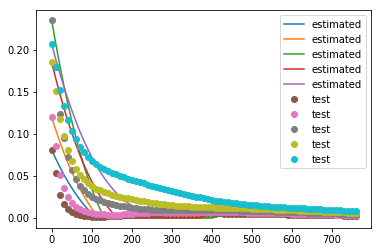

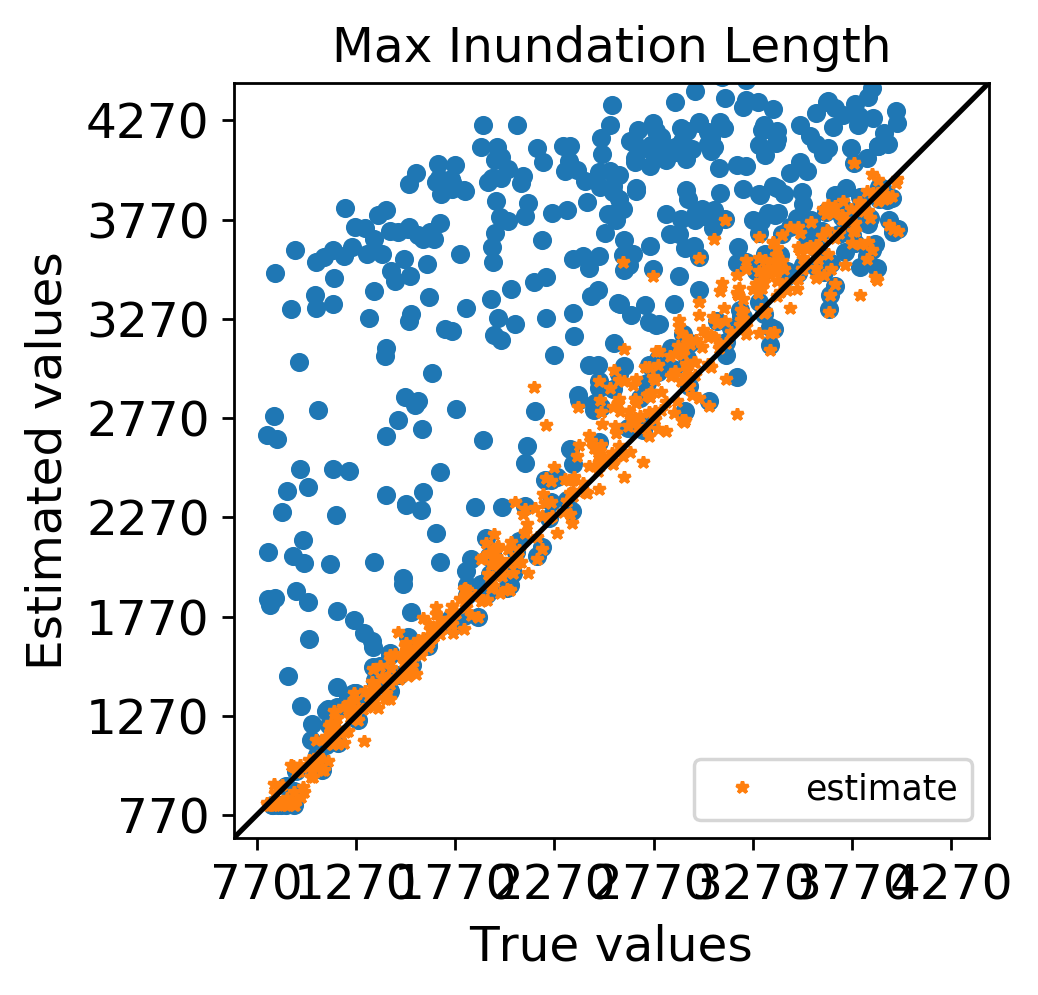

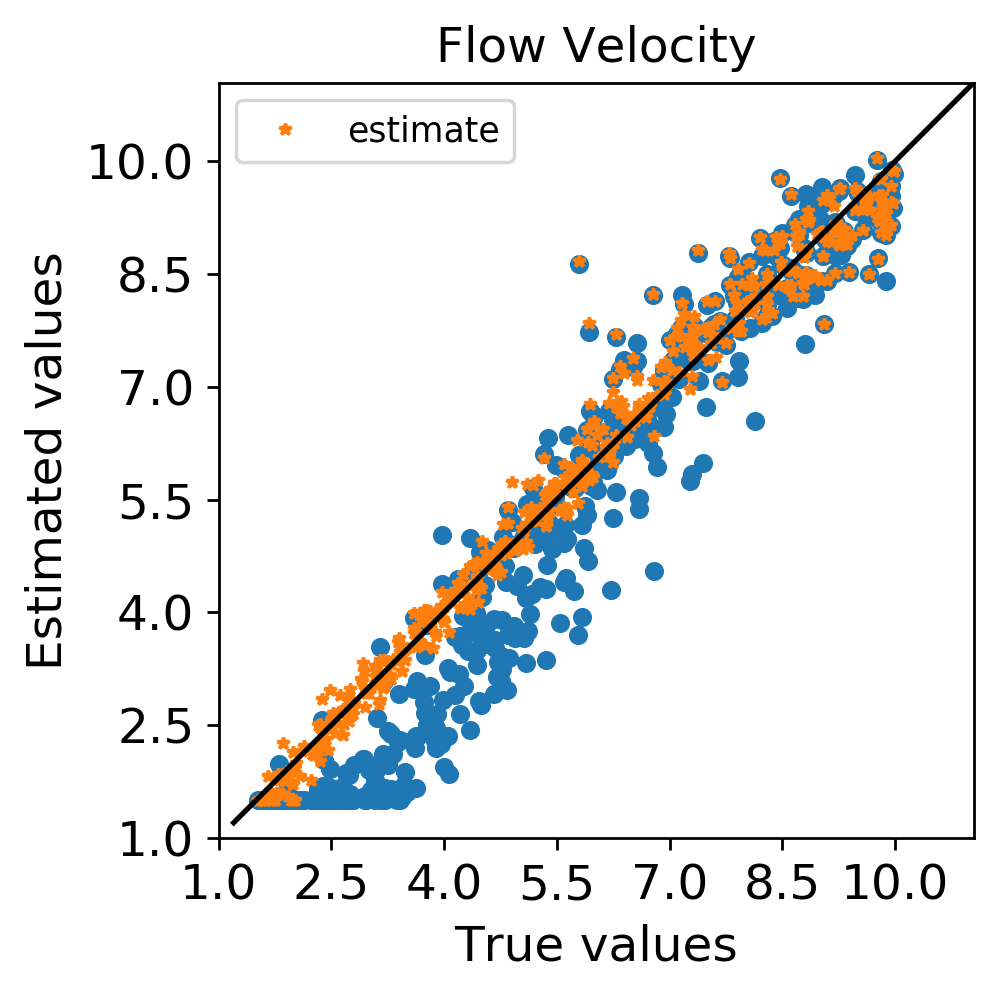

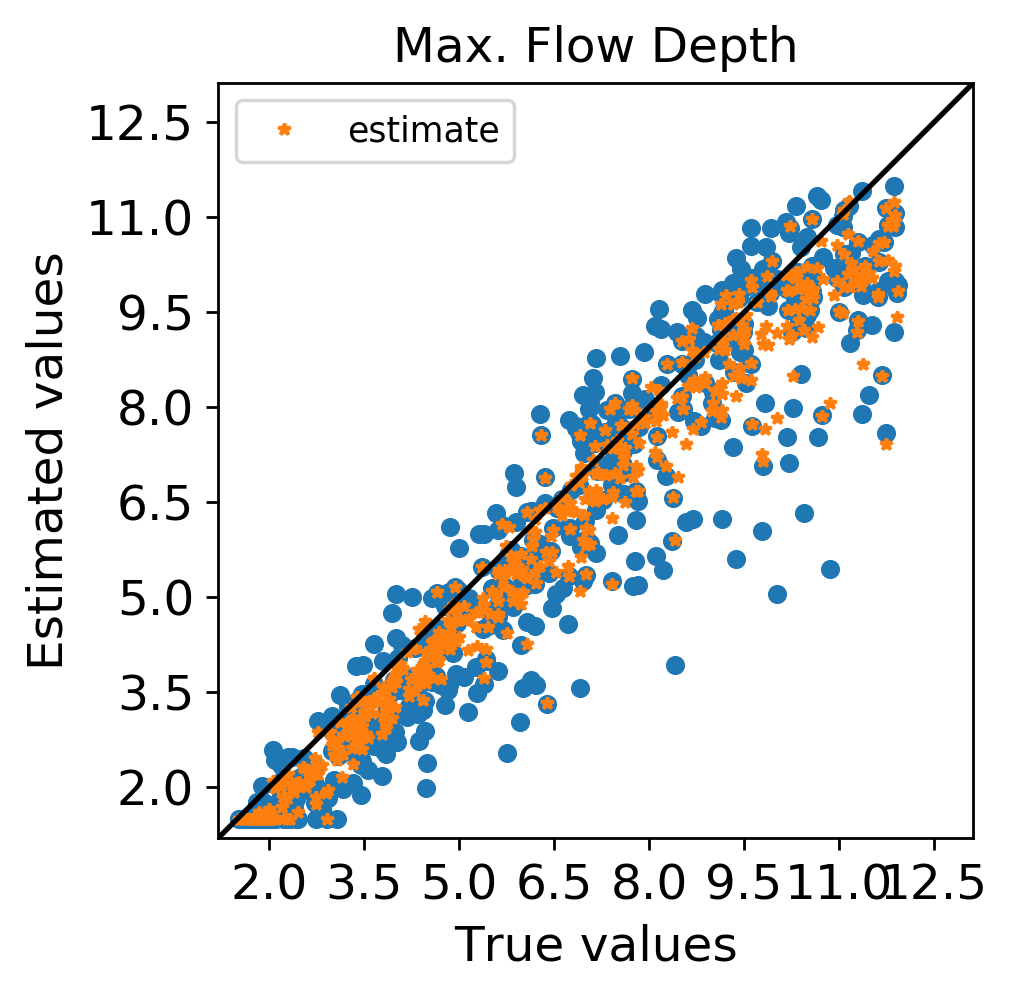

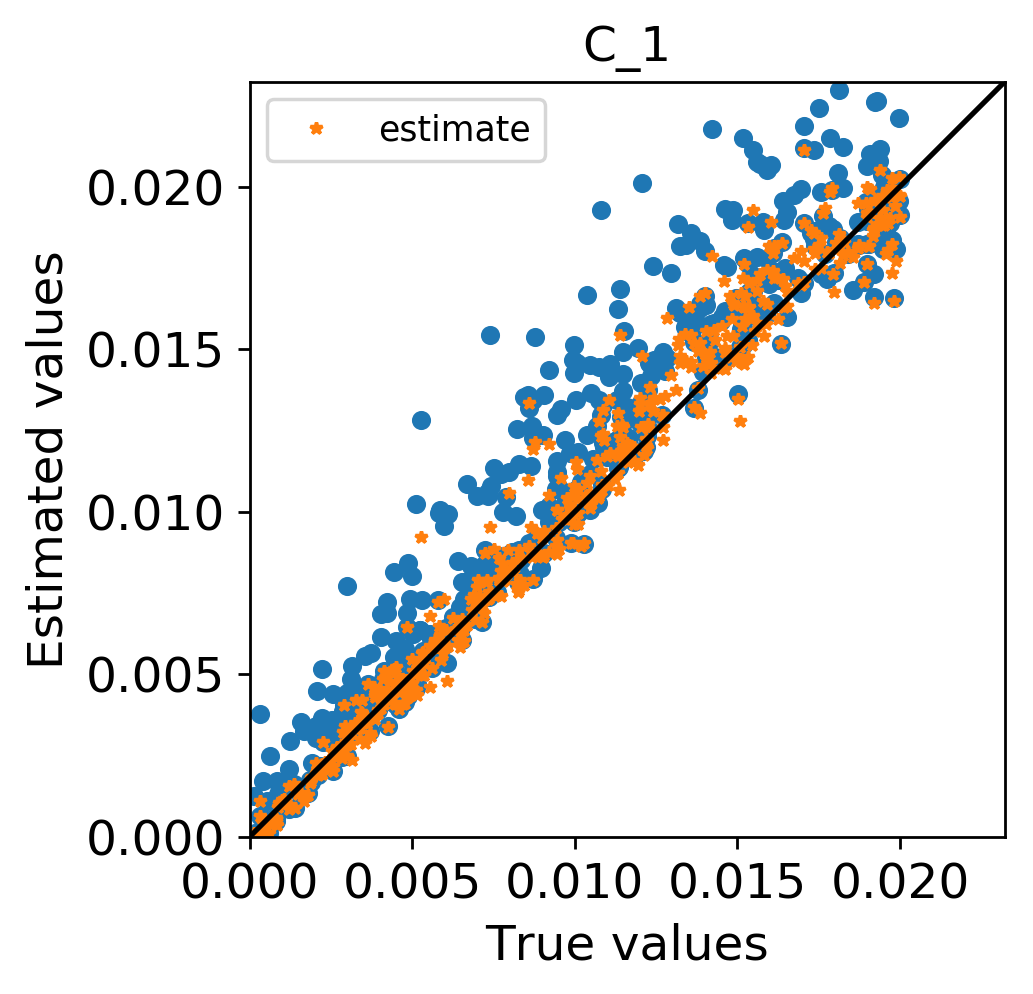

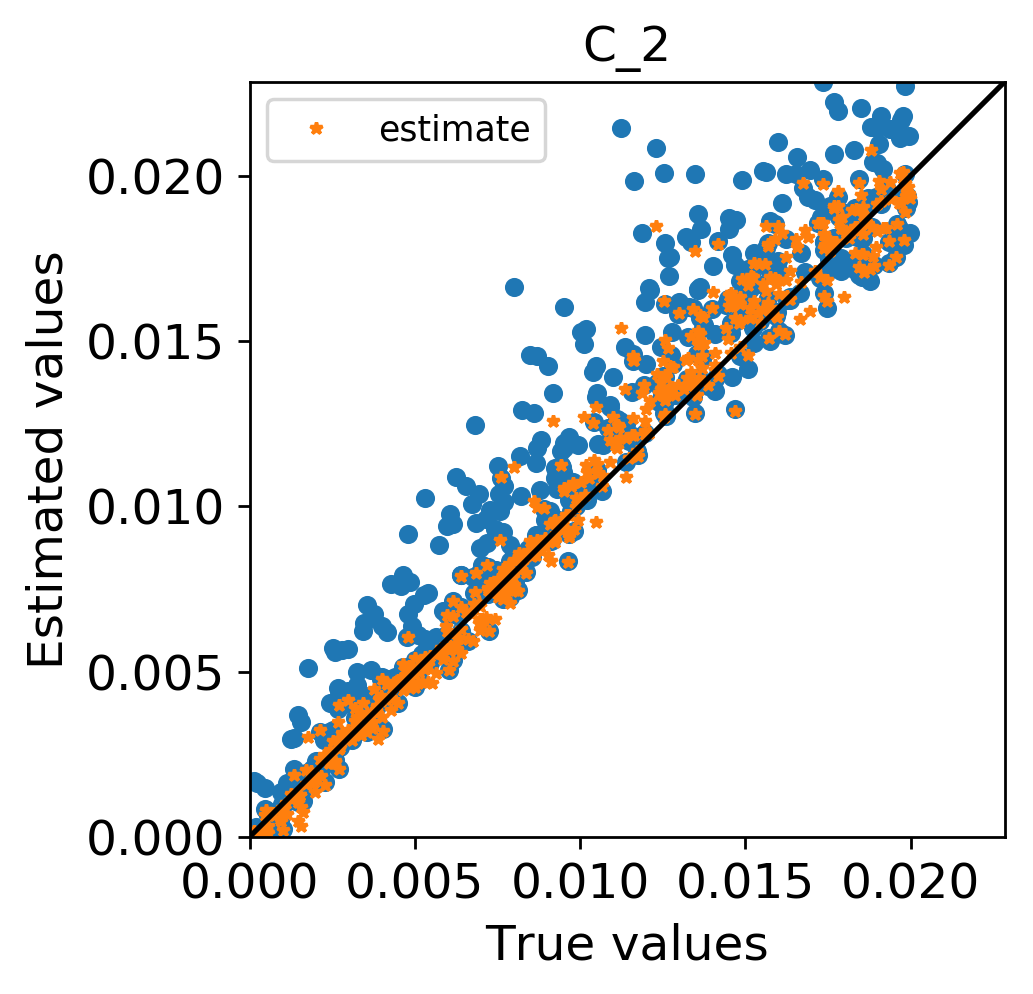

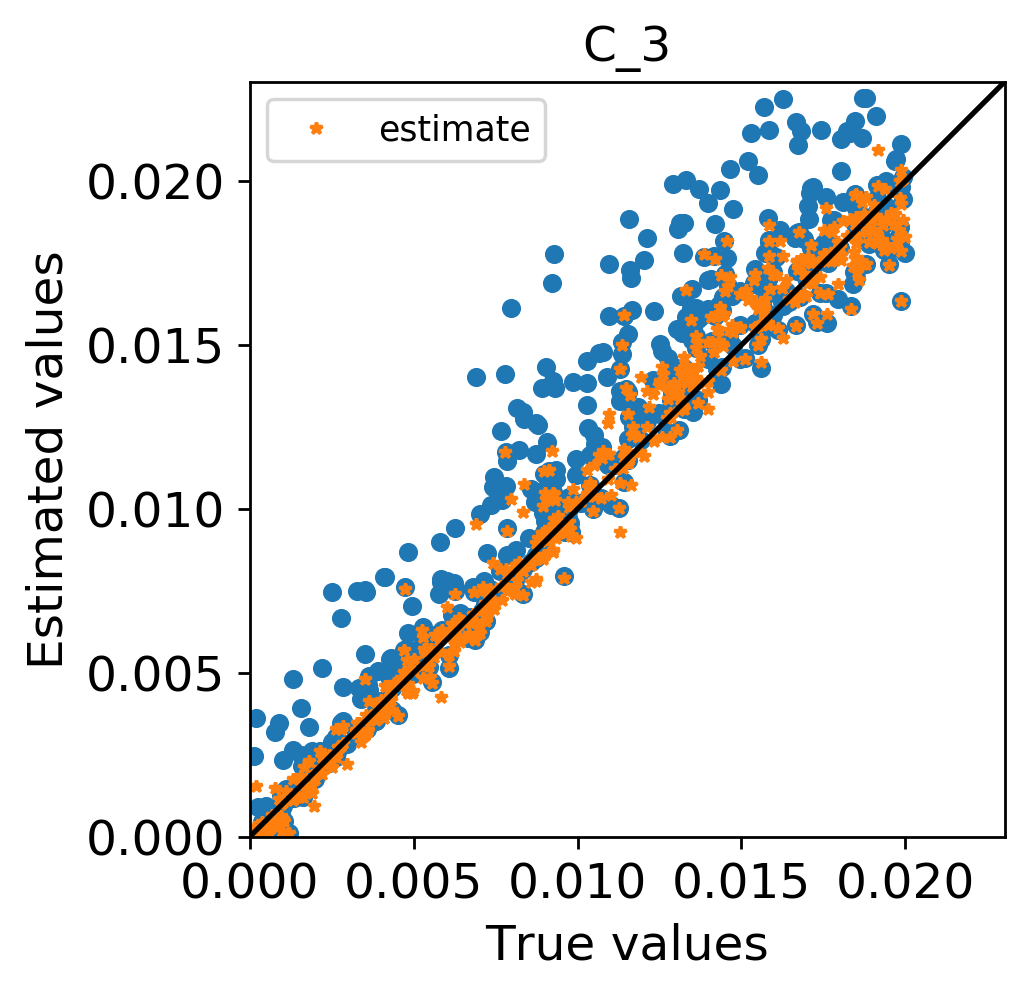

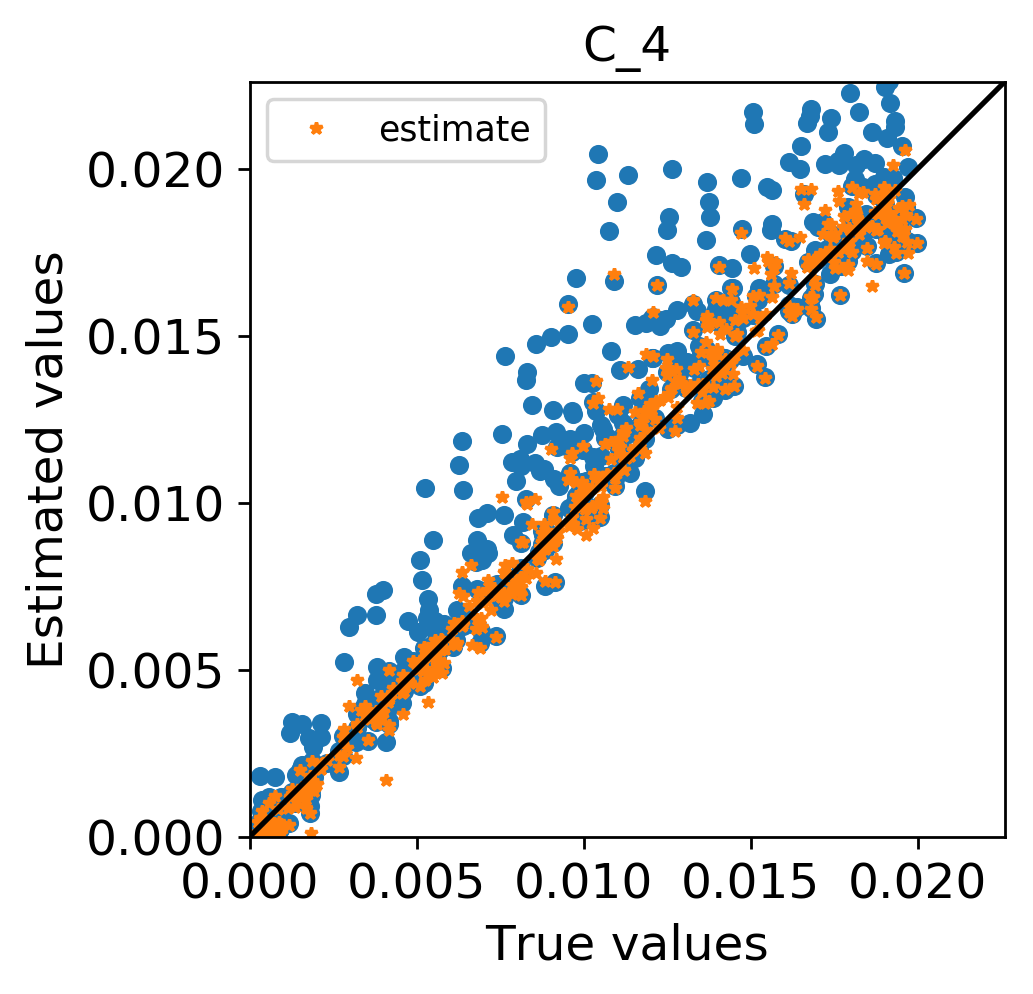

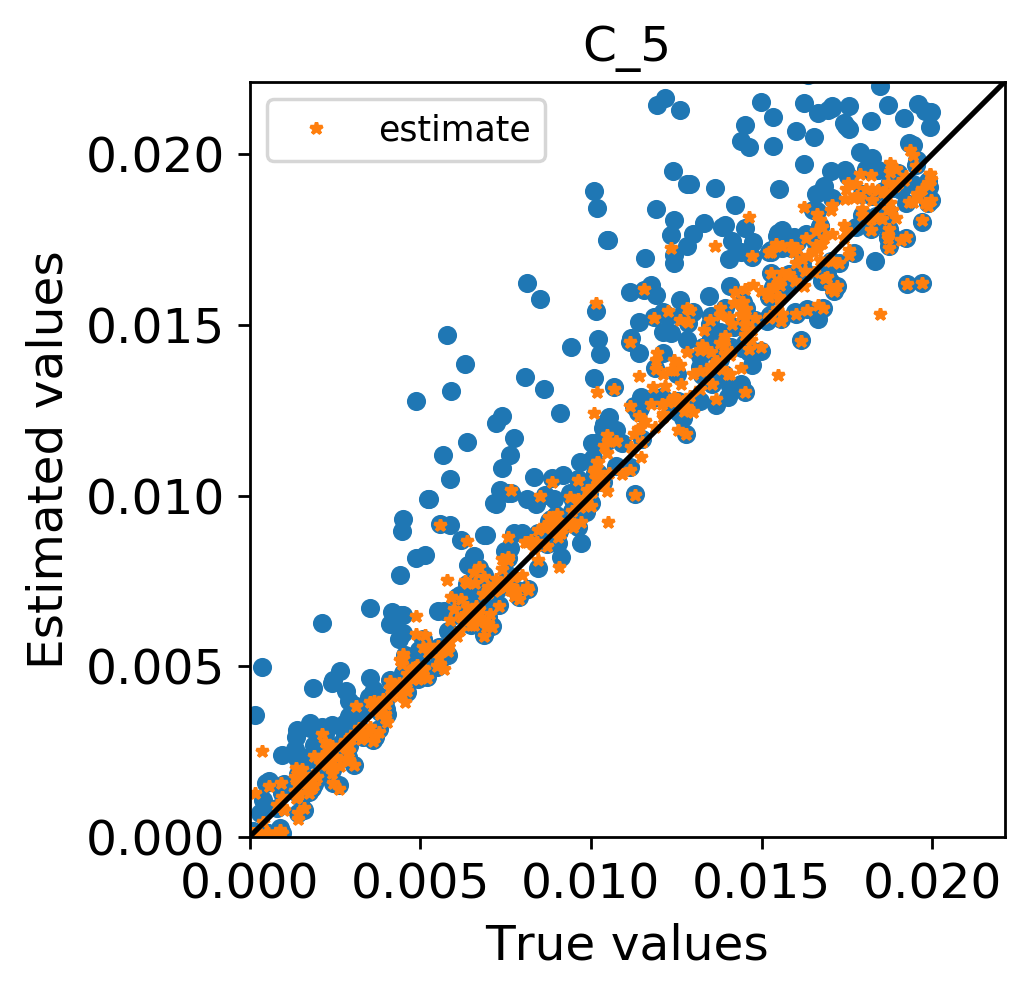

Standard Deviation sample: 761.5932105697367
Mean: 809.8415636579667
mode ModeResult(mode=array([-365.9563693]), count=array([1]))
m 637.0178858173908


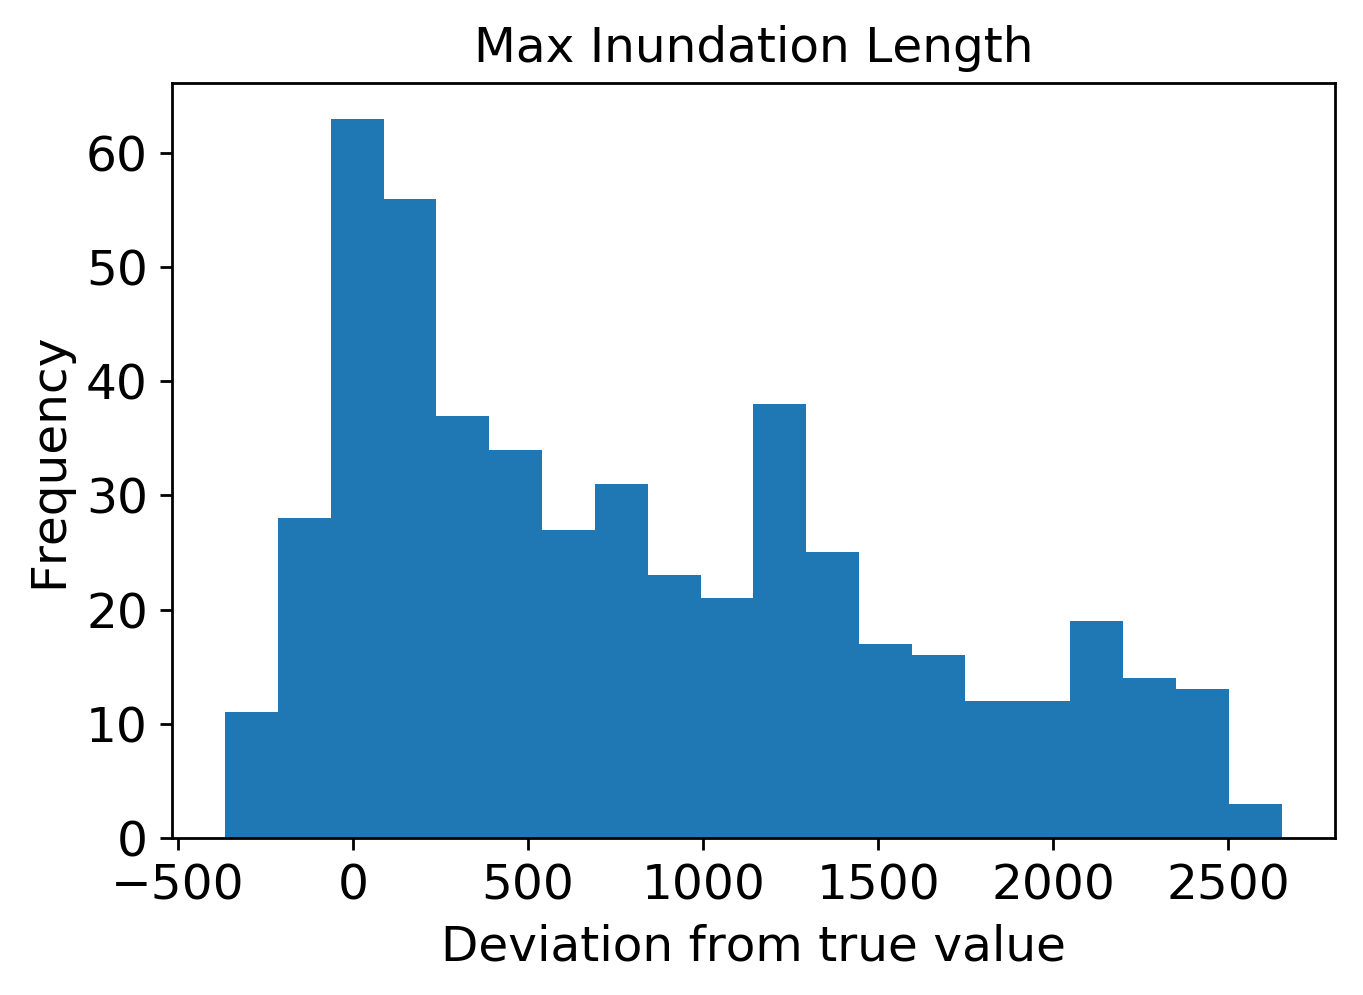

Standard Deviation sample: 0.7327884420573142
Mean: -0.40934788644799014
mode ModeResult(mode=array([-2.24709864]), count=array([1]))
m -0.31687430953728013


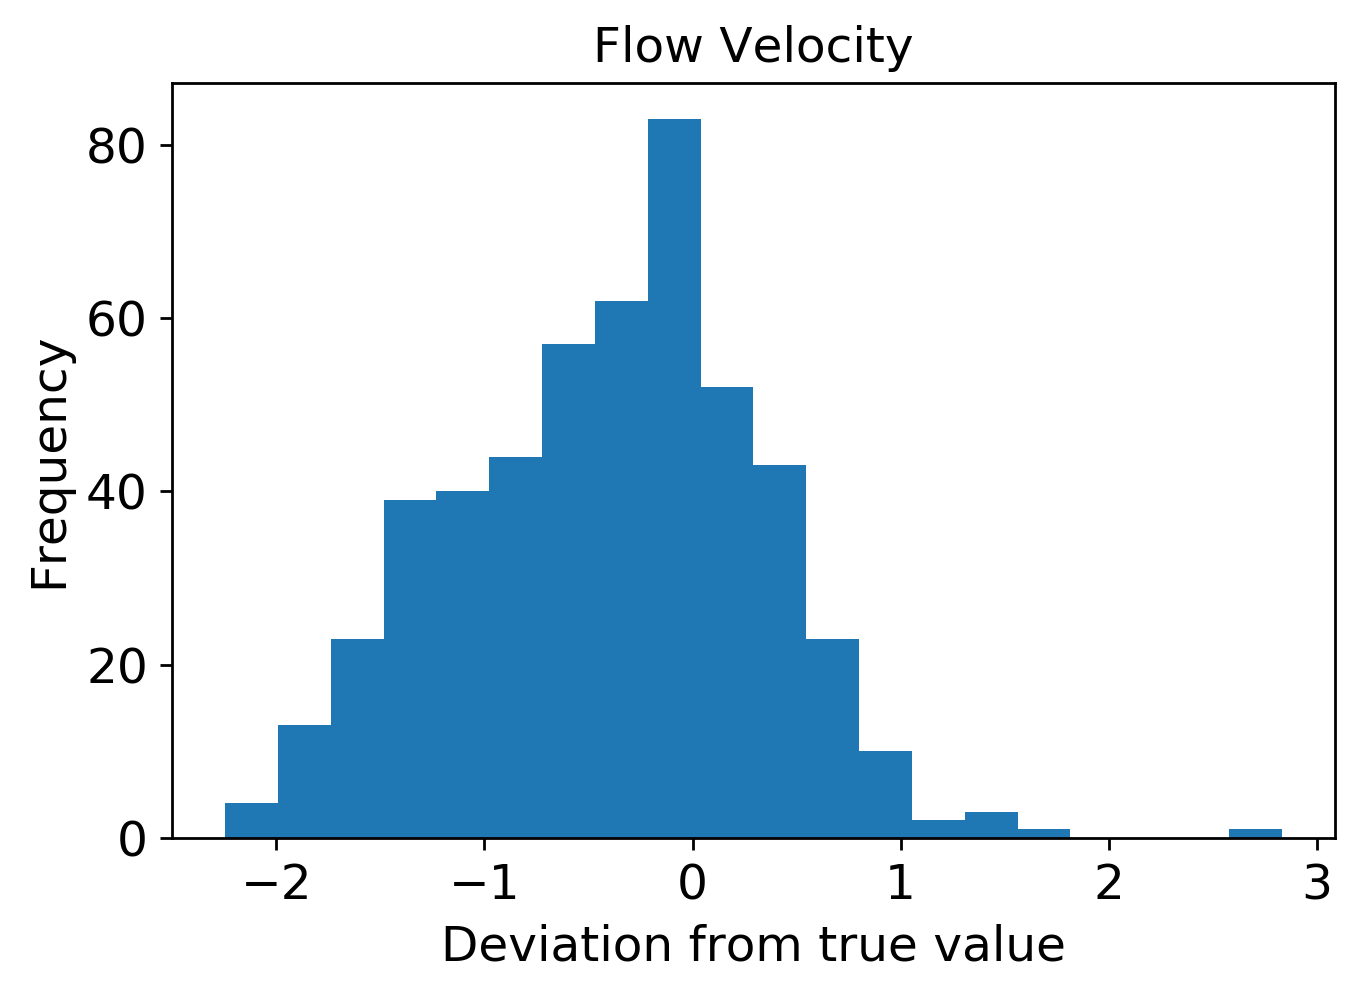

Standard Deviation sample: 1.0165843146093578
Mean: -0.5880671415562339
mode ModeResult(mode=array([-5.41089431]), count=array([1]))
m -0.4868814073969109


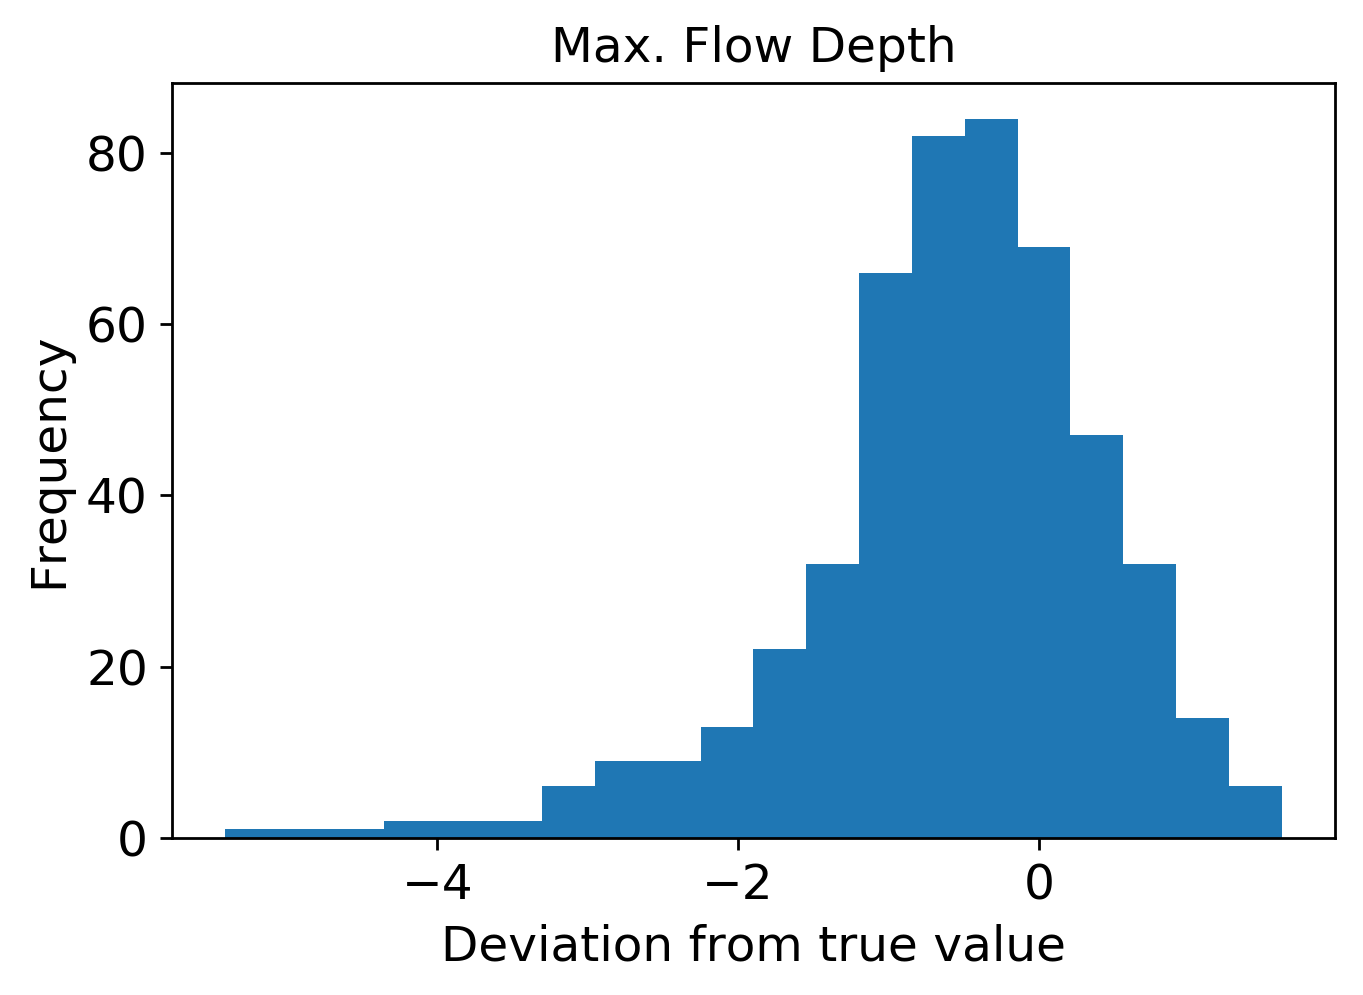

Standard Deviation sample: 0.0017924683921410113
Mean: 0.0013469143525848529
mode ModeResult(mode=array([-0.00324734]), count=array([1]))
m 0.0008712507485123247


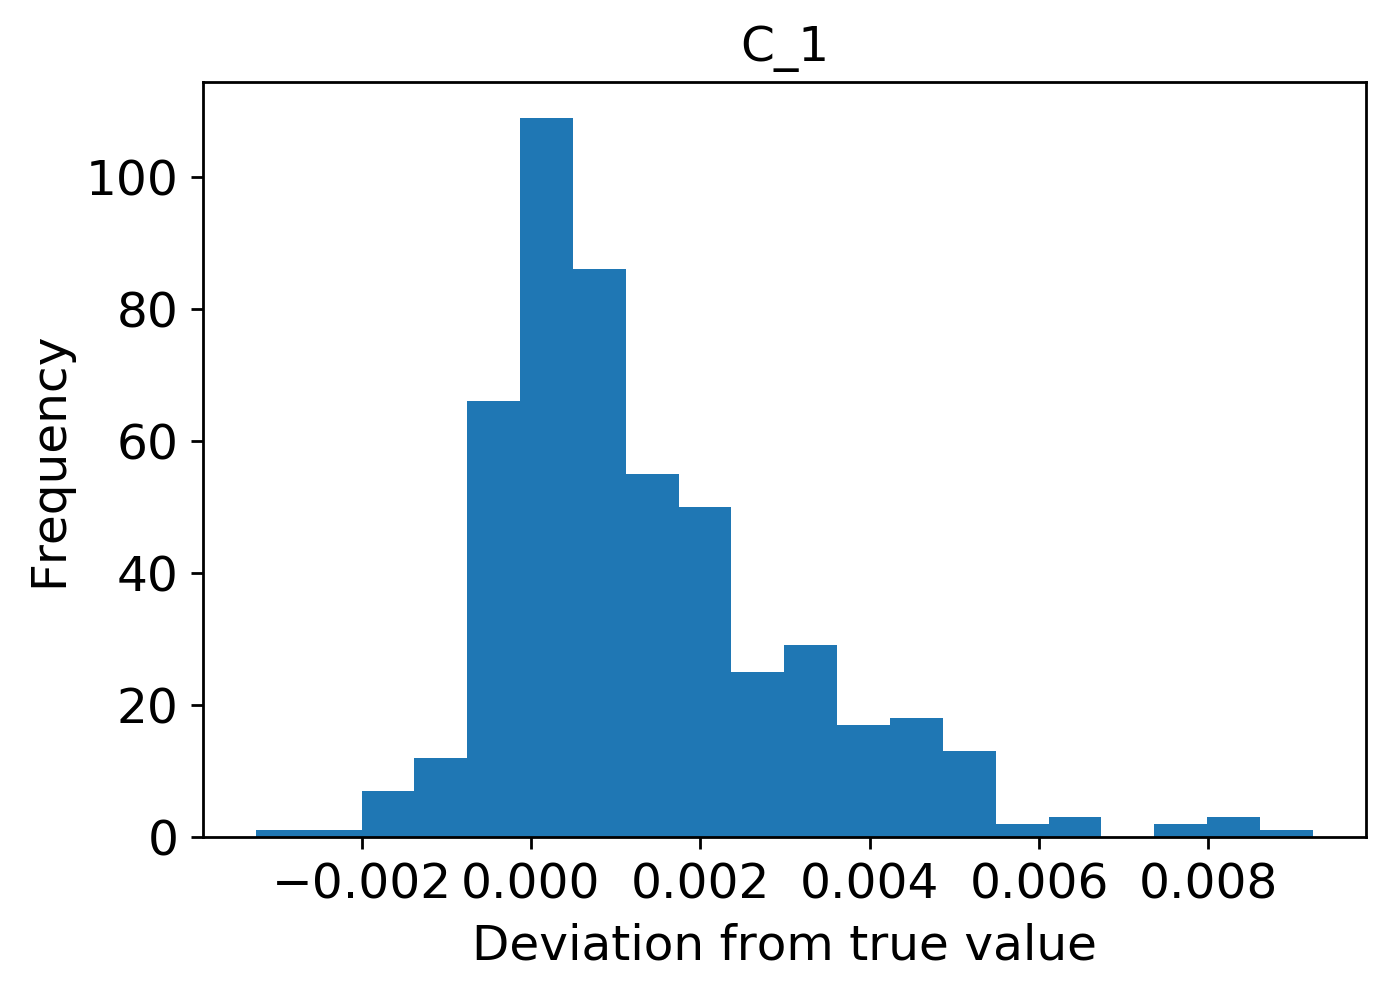

Standard Deviation sample: 0.0018083000113203254
Mean: 0.0012787628004137337
mode ModeResult(mode=array([-0.00199563]), count=array([1]))
m 0.0007758852047772657


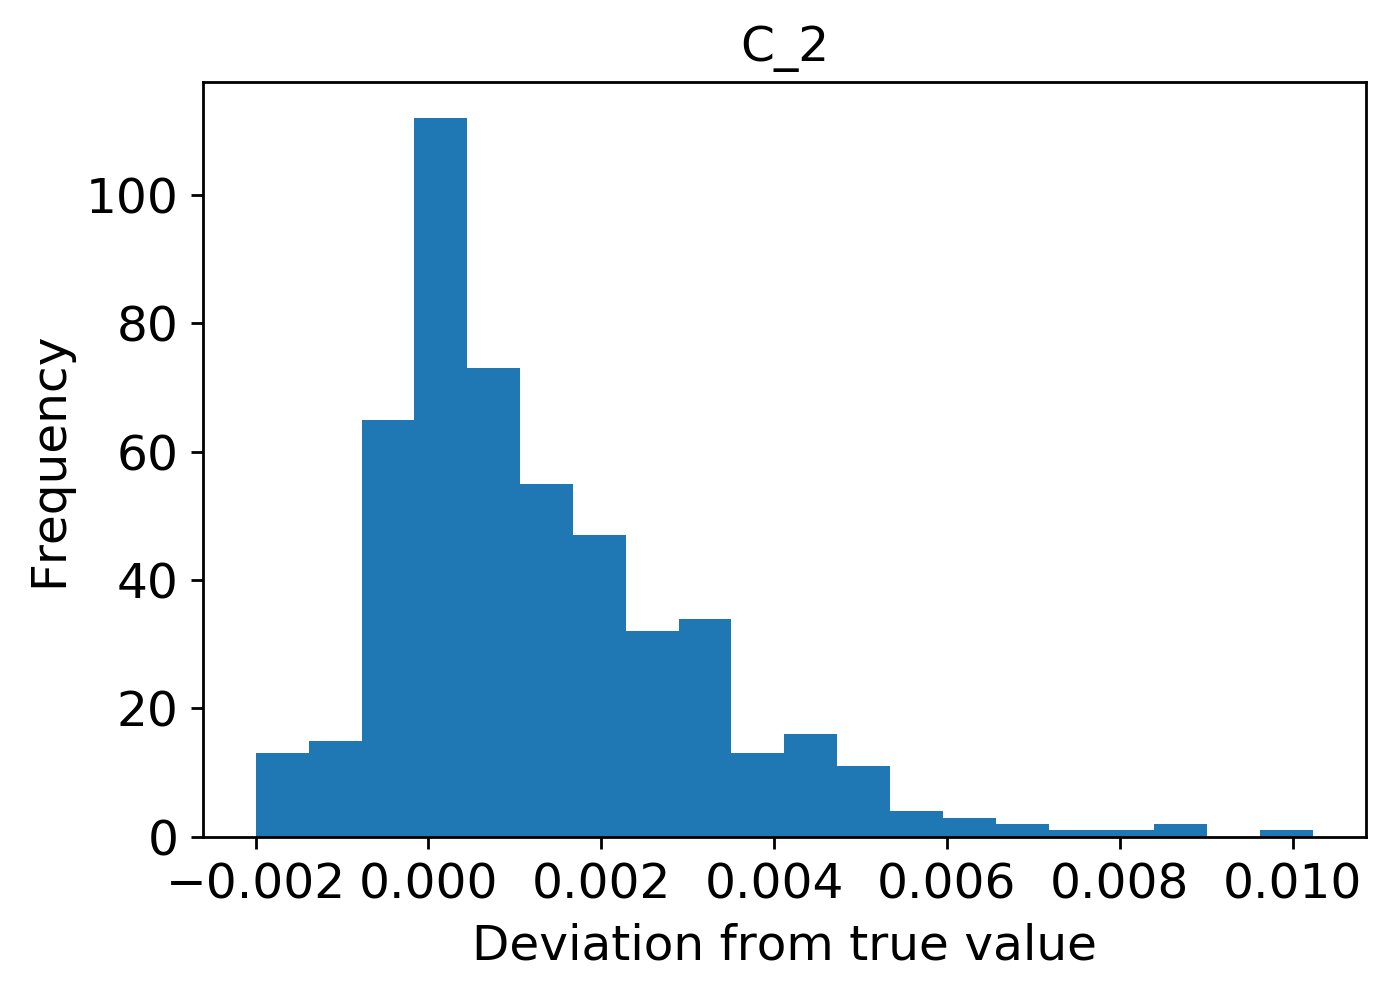

Standard Deviation sample: 0.0020092366033107973
Mean: 0.0013139207253426487
mode ModeResult(mode=array([-0.00351844]), count=array([1]))
m 0.0006748189148110539


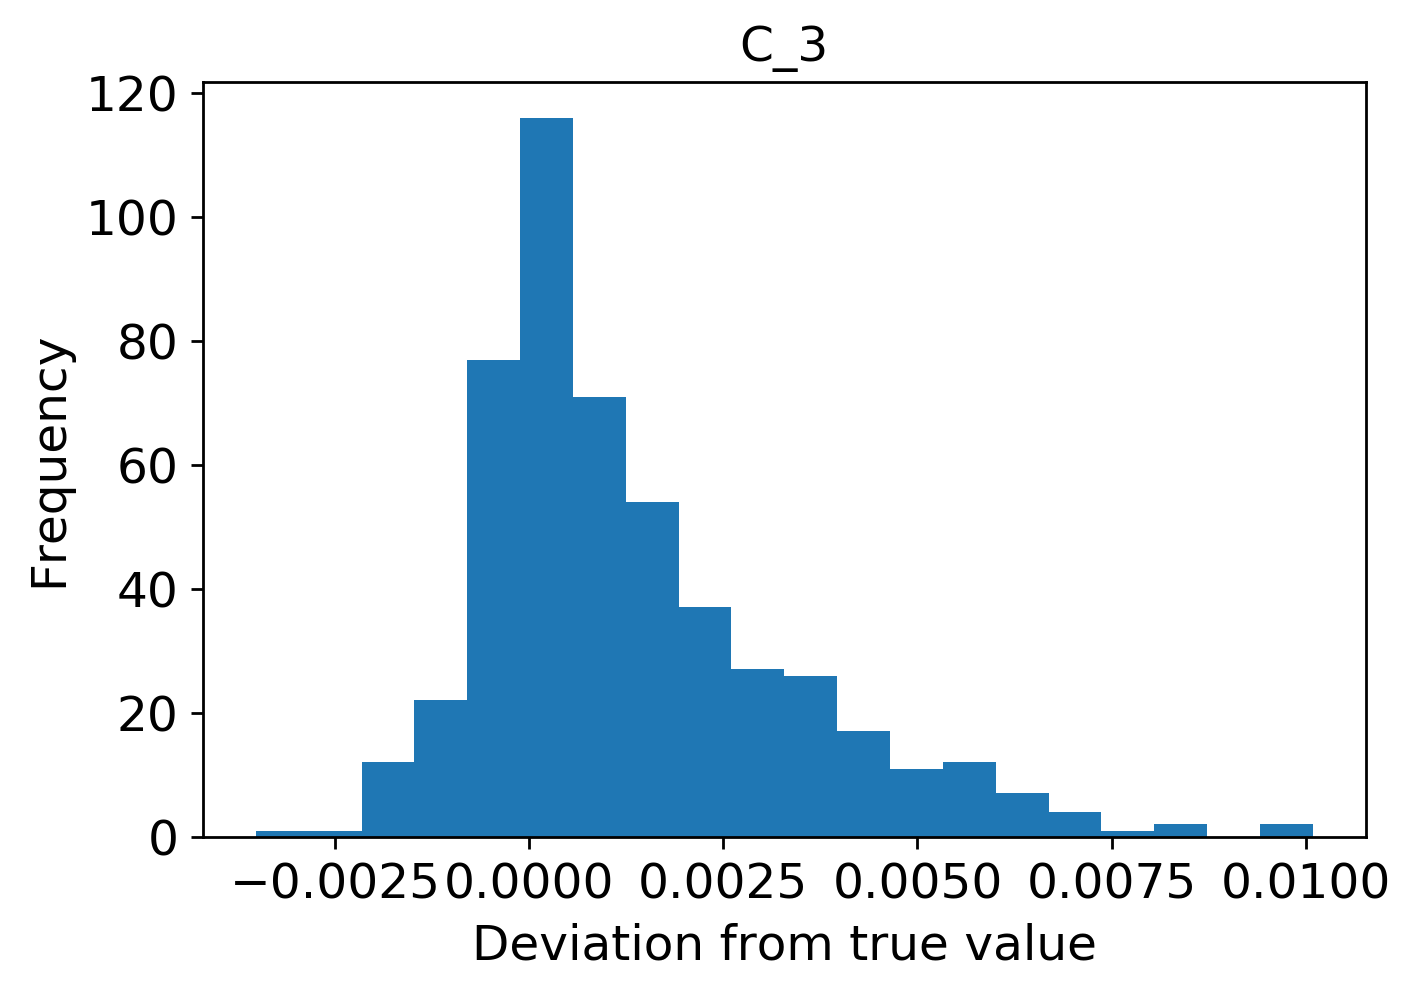

Standard Deviation sample: 0.002000467833383289
Mean: 0.0011224549547018876
mode ModeResult(mode=array([-0.00269858]), count=array([1]))
m 0.00045468560390727773


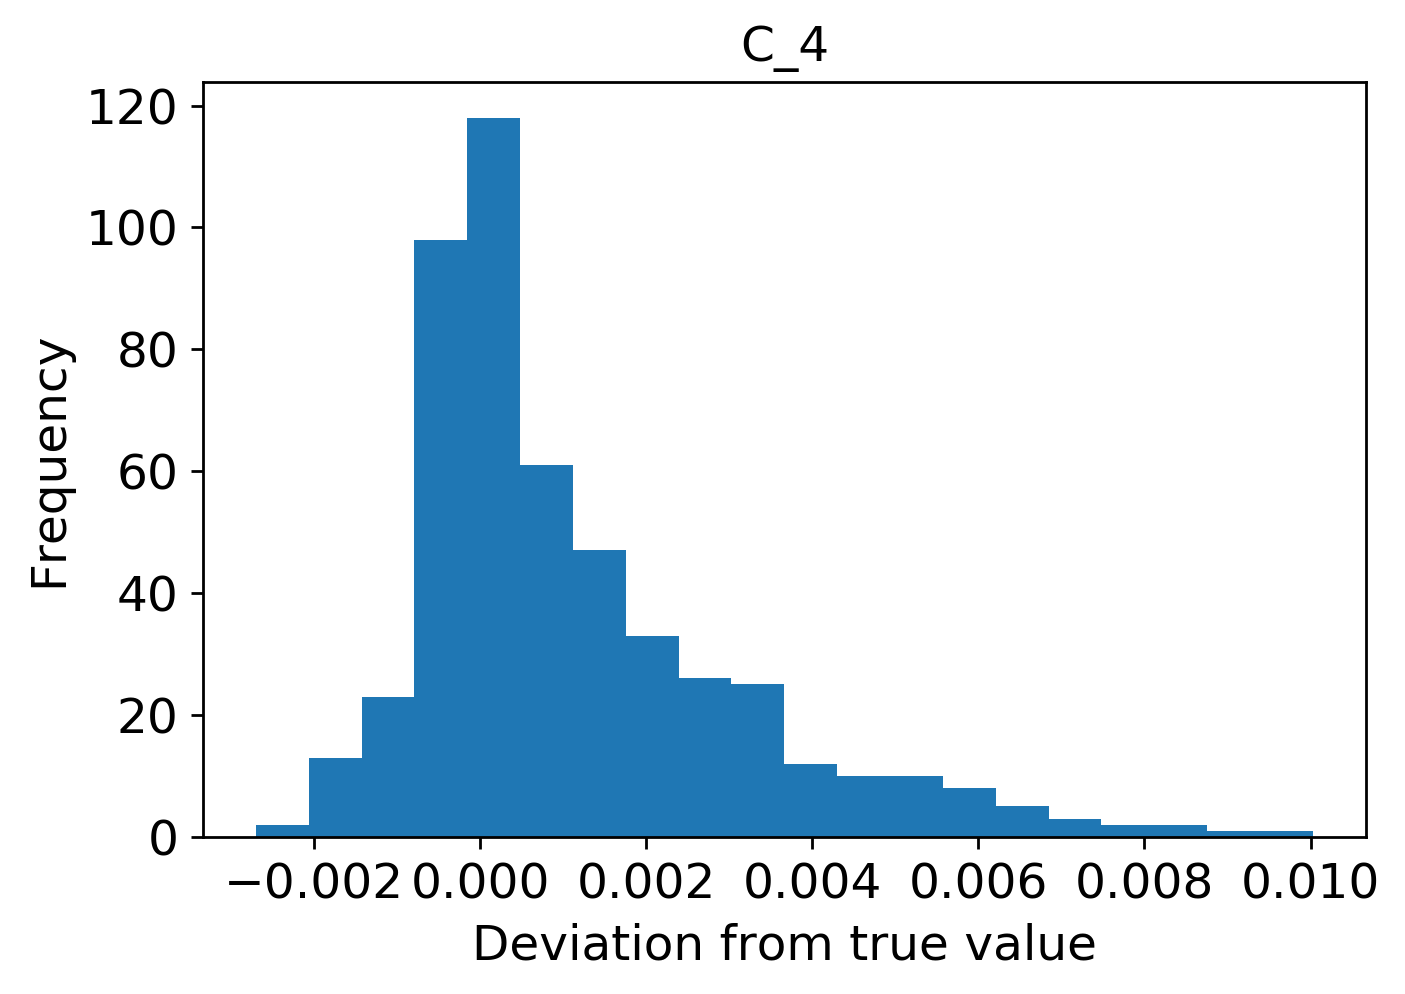

Standard Deviation sample: 0.002162820538955226
Mean: 0.0013735698756471091
mode ModeResult(mode=array([-0.00349329]), count=array([1]))
m 0.0007021133968874071


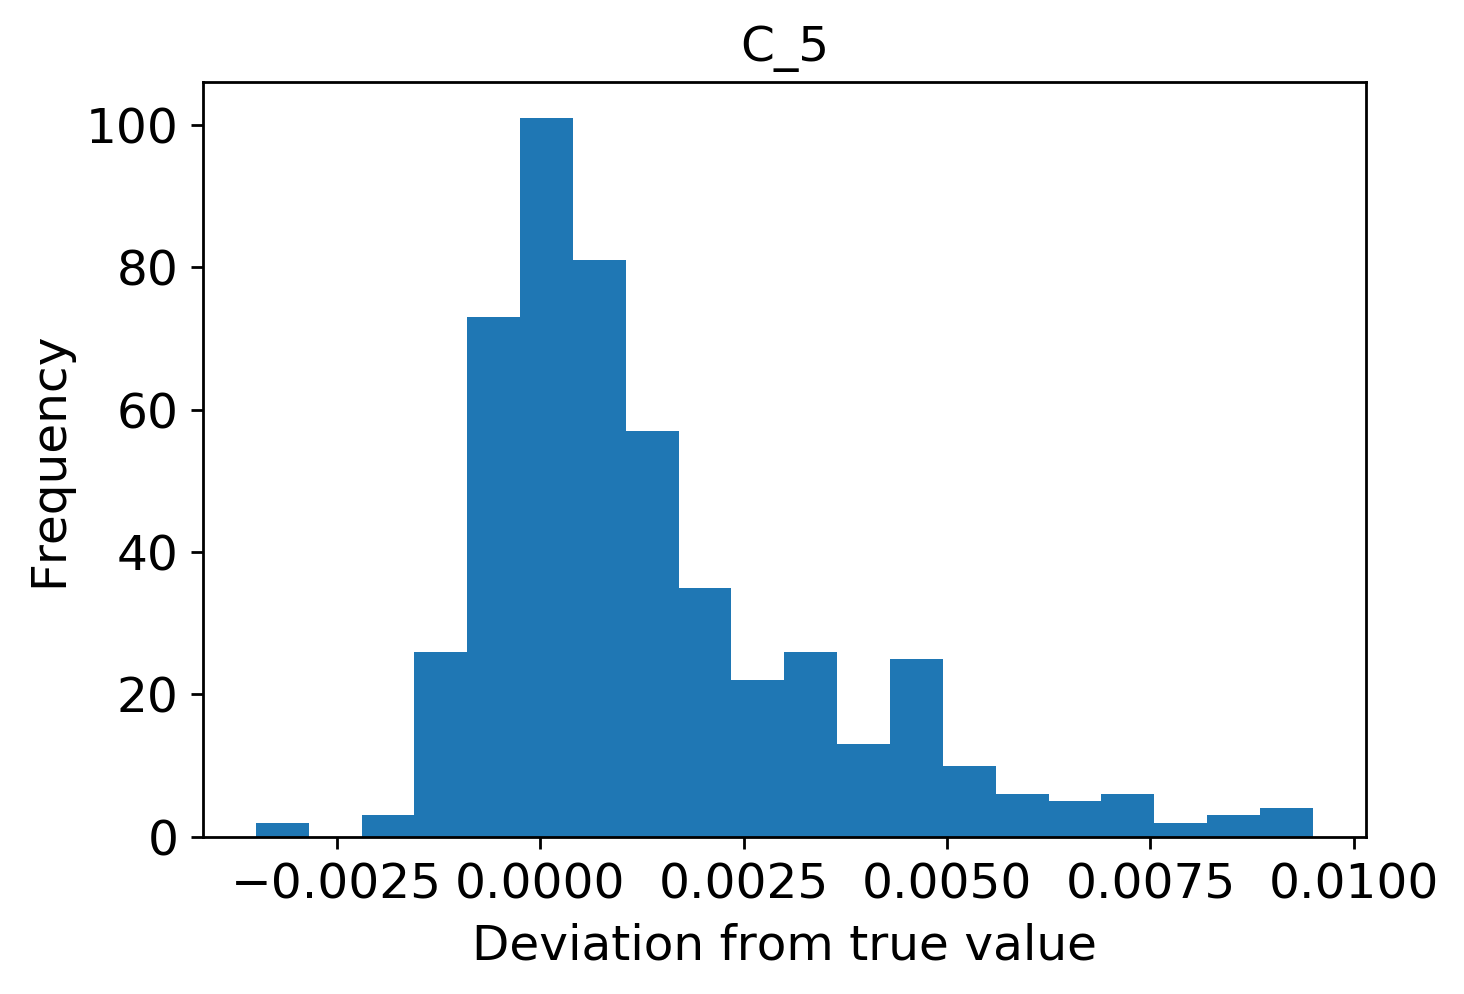

In [1]:
#Bias Check
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb
from scipy import stats

import ipdb
#ipdb.set_trace()

datadir = '/home/rimali2009/Journal_2/data_g5_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g5_j2_roi770_jogan_5500_400grid/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')

# Load test datasets

X_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')


# Normalize the test datasets
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
X_test_norm =  (X_test - min_x) / (max_x - min_x)


gclass = 5
gclass_name= ['500','420','354','297','250']
gclass_label = ["500 ${\mu}m$","420 ${\mu}m$","354 ${\mu}m$", "297 ${\mu}m$","250 ${\mu}m$"]
topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

# Load outcrop data
outcrop = pd.read_csv('../Journal_2/jogan_gs5.csv')
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
outcrop_num = len(outcrop['distance'])
print(outcrop)

#Preparation under interpolation
thick_interp_at_outcrop = np.zeros([X_test.shape[0],outcrop_num*gclass])
thick_interp = np.zeros([X_test.shape[0],coord_num*gclass])#Interpolated sample thickness data
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #Index number of sampling point in inverse analysis system
x = np.arange(0,coord_num*topodx,topodx)

# Interpolation of test datasets at the outcrop locations
for i in range(X_test.shape[0]):
    for j in range(gclass):
        f = interp1d(x,X_test_norm[i,j * coord_num : (j+1) * coord_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp_at_outcrop[i,outcrop_num*j:outcrop_num*(j+1)] = f(outcrop['distance']) #Supplemented data

    # Interpolation of test datasets at the grids of the forward model
    for j in range(gclass):
        f = interp1d(outcrop['distance'],thick_interp_at_outcrop[i,j * outcrop_num : (j+1) * outcrop_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp[i,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data
    


#Normalize data
thick_interp[thick_interp < 0] = 0
print(thick_interp)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
np.savetxt('outcrop_location_interp.txt',test_result_outcrop, delimiter=',')
test_result=np.loadtxt('outcrop_location_interp.txt', delimiter=',')
test_result_normal = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
resi=test_result-y_test
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5']
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
xymin=[770,1.5,1.5,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005]
stepmin=[770,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025]
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)], label='estimated')
for j in range(gclass):
    plt.plot(x,X_test_norm[0,j * coord_num : (j+1) * coord_num],'o',label='test')
    #plt.plot(outcrop['distance'], thick_interp_at_outcrop[0,outcrop_num*j:outcrop_num*(j+1)],'o',label='test')
plt.plot()
plt.legend()


for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(y_test[:,i],test_result[:,i],"o", markersize=4.5)
    plt.plot(y_test[:,i],test_result_normal[:,i],"*",label='estimate',markersize=3.5)
    x=y_test[:,i]
    y=test_result_normal[:,i]
    y2= test_result_normal[:, i]
    max_value = np.max([x, y, y2])
    min_value = np.min([x, y, y2])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('True values',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
    plt.legend()
    plt.axes().set_aspect('equal')
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    #plt.plot(x_lim, y_lim, color = 'k')
    plt.tick_params(labelsize=14,colors='k')
    plt.savefig(resdir+titlelabel[i] + 'outcrop_locationrev' + '.pdf')
    plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('mode',stats.mode(resi[:,i]))
    print('m',np.median(resi[:,i]))
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.pdf')
    plt.show()